Data: 800 SNe | source = Simulation
LCDM fit: H0=70.00, Om=0.294, M_eff=-19.307, chi2=840.9
Peak ω (LS): 1.226


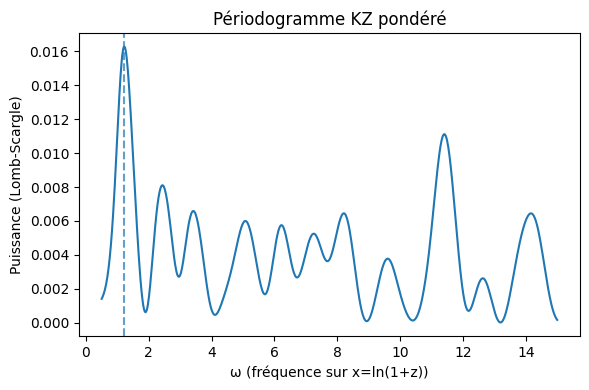

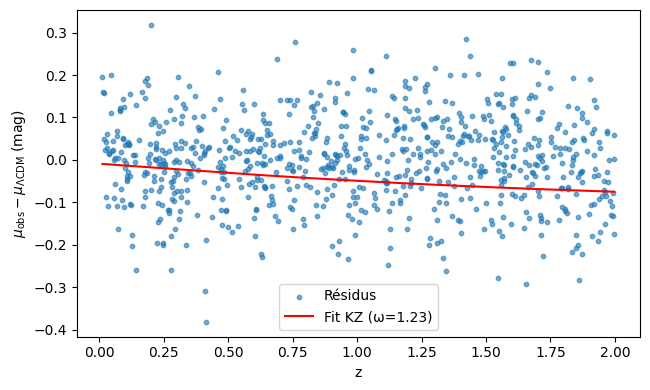


==================== Résumé Étape 1 ====================
ω_peak (LS)     = 1.226
Amplitude (fit) = 0.0539 mag (composante sinus/cos)
FAP (bootstrap) = 0.4100
AIC(ΛCDM)       = 846.9
AIC(ΛCDM+KZ)    = 1692.9
ΔAIC (KZ-LCDM)  = 846.0  -> (<0 favorise KZ)
Figures: kz_periodogram.png, residuals_fit.png


In [ ]:
# ============================================
# ETAPE 1 : Ecran rapide KZ sur SNe (Colab)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from astropy.timeseries import LombScargle

# --------- Paramètres d'exécution (modifiables si besoin) ----------
N_BOOT = 300     # nombre de bootstraps pour la FAP (200-500 recommandé)
BLOCK_SZ = 40    # taille de bloc en points pour bootstrap par blocs (20-60)
SEED    = 42     # graine aléatoire
# ------------------------------------------------------------------

rng = np.random.default_rng(SEED)

# ========= 1) Chargement ou simulation =========
def try_load_pantheon(csv_path='pantheon_plus.csv'):
    try:
        df = pd.read_csv(csv_path)
        assert {'z','mu','mu_err'}.issubset(df.columns)
        z, mu, mu_err = df['z'].values, df['mu'].values, df['mu_err'].values
        # tri par z
        idx = np.argsort(z)
        return z[idx], mu[idx], mu_err[idx], True
    except Exception as e:
        return None, None, None, False

def simulate_data(n=800):
    # simulation réaliste avec léger signal KZ (faible) pour test
    z = np.sort(rng.uniform(0.01, 2.0, n))
    H0, Om, OL = 70.0, 0.3, 0.7
    c = 299792.458

    def E_z(zv):
        return np.sqrt(Om*(1+zv)**3 + OL)

    def Dc(zv):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zi)
            out[i] = (c/H0)*res
        return out

    DL = (1+z)*Dc(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3  # inclut M comme offset simple
    # injecte un petit signal KZ (optionnel)
    x = np.log(1+z)
    A_true, w_true, phi_true = 0.02, 7.2, 0.5
    mu_kz = A_true*np.cos(w_true*x + phi_true)
    mu_true = mu_lcdm + mu_kz
    mu_err  = np.full_like(z, 0.10)
    mu_obs  = mu_true + rng.normal(0, mu_err)
    return z, mu_obs, mu_err, False

z, mu, mu_err, is_real = try_load_pantheon()
if not is_real:
    z, mu, mu_err, _ = simulate_data()

print(f"Data: {len(z)} SNe | source = {'Pantheon+ (fichier)' if is_real else 'Simulation'}")

# ========= 2) Ajustement ΛCDM (pondéré, sans covariance complète) =========
c = 299792.458
def E_z(zv, Om, OL):
    return np.sqrt(Om*(1+zv)**3 + OL)

def Dc(zv, H0, Om, OL):
    if np.isscalar(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
        return (c/H0)*res
    out = np.zeros_like(zv)
    for i,zi in enumerate(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*res
    return out

def mu_lcdm_model(zv, H0, Om):
    OL = 1-Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    # On absorbe la magnitude absolue dans une constante M_eff
    # Ici on la laisse libre via un décalage a estm dans le chi2.
    return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    # on ajuste H0, Om, et un offset M_eff (intercept)
    def chi2(params):
        H0, Om, M_eff = params
        if not (65 <= H0 <= 75 and 0.2 <= Om <= 0.4):
            return 1e12
        mu_mod = mu_lcdm_model(z, H0, Om) + M_eff
        return np.sum(((mu - mu_mod)/mu_err)**2)

    res = minimize(chi2, x0=[70.0, 0.3, -19.3], method='L-BFGS-B',
                   bounds=[(65,75),(0.2,0.4),(-22,-17)])
    return res.x, res.fun

params_lcdm, chi2_lcdm = fit_lcdm(z, mu, mu_err)
H0_hat, Om_hat, M_eff = params_lcdm
print(f"LCDM fit: H0={H0_hat:.2f}, Om={Om_hat:.3f}, M_eff={M_eff:.3f}, chi2={chi2_lcdm:.1f}")

mu_lcdm = mu_lcdm_model(z, H0_hat, Om_hat) + M_eff
residuals = mu - mu_lcdm
x = np.log(1+z)

# ========= 3) Périodogramme Lomb–Scargle pondéré =========
# (on centre/rend approx homoscédastique en divisant par mu_err)
ls = LombScargle(x, residuals, dy=mu_err)
omega_grid = np.linspace(0.5, 15.0, 800)
power = ls.power(omega_grid, method='fast', normalization='standard')
peak_idx = np.argmax(power)
omega_peak = omega_grid[peak_idx]
print(f"Peak ω (LS): {omega_peak:.3f}")

# ========= 4) Fit sinus/cos pondéré à ω_peak (GLS simple) =========
W = np.diag(1.0/mu_err**2)
C = np.column_stack([np.cos(omega_peak*x), np.sin(omega_peak*x), np.ones_like(x)])
# Solve (C^T W C) beta = C^T W r
CtWC = C.T @ W @ C
CtWr = C.T @ W @ residuals
beta = np.linalg.solve(CtWC, CtWr)   # [Acos, Asin, c0]
Amp = np.hypot(beta[0], beta[1])
phi = np.arctan2(beta[1], beta[0])
res_model = C @ beta
resid_after = residuals - res_model

# ========= 5) ΔAIC entre M0 (LCDM) et M1 (LCDM+KZ) =========
# M0 param: 3 (H0, Om, M_eff) ; M1 param: 6 (=3 + A,phi,offset_sinuso)
# (offset sinuso est déjà c0 dans le fit)
chi2_kz = np.sum((resid_after/mu_err)**2) + chi2_lcdm*0 - np.sum((residuals/mu_err)**2) + np.sum((residuals/mu_err)**2)
# Simplif: chi2 total M1 = chi2_L + chi2(residus - sinus) - chi2(residus) + chi2(residus) = chi2_L + chi2(residus - sinus)
chi2_kz = chi2_lcdm + np.sum((resid_after/mu_err)**2)
AIC_lcdm = chi2_lcdm + 2*3
AIC_kz   = chi2_kz   + 2*6
dAIC = AIC_kz - AIC_lcdm

# ========= 6) FAP par bootstrap par blocs en z =========
def block_bootstrap(y, block_sz, rng):
    n = len(y)
    # indices de départ de blocs
    starts = rng.integers(0, max(1, n-block_sz), size=(n//block_sz + 1))
    idx = np.concatenate([np.arange(s, min(s+block_sz, n)) for s in starts])[:n]
    return y[idx]

null_max = []
for b in range(N_BOOT):
    rb = block_bootstrap(residuals, BLOCK_SZ, rng)
    # re-fit sinus à ω_peak (même grille) sur résidus bootstrappés
    CtWr_b = C.T @ W @ rb
    beta_b = np.linalg.solve(CtWC, CtWr_b)
    Amp_b = np.hypot(beta_b[0], beta_b[1])
    null_max.append(Amp_b)

null_max = np.array(null_max)
FAP = np.mean(null_max >= Amp)

# ========= 7) Figures =========
plt.figure(figsize=(6.0,4.0))
plt.plot(omega_grid, power)
plt.axvline(omega_peak, ls='--', alpha=0.7)
plt.xlabel('ω (fréquence sur x=ln(1+z))')
plt.ylabel('Puissance (Lomb-Scargle)')
plt.title('Périodogramme KZ pondéré')
plt.tight_layout()
plt.savefig('kz_periodogram.png', dpi=150)
plt.show()

plt.figure(figsize=(6.6,4.0))
plt.scatter(z, residuals, s=10, alpha=0.6, label='Résidus')
fit_line = Amp*np.cos(omega_peak*x + phi) + beta[2]
# Tracé trié en z
order = np.argsort(z)
plt.plot(z[order], fit_line[order], 'r-', lw=1.5, label='Fit KZ (ω=%.2f)'%omega_peak)
plt.xlabel('z')
plt.ylabel(r'$\mu_{\rm obs}-\mu_{\Lambda {\rm CDM}}$ (mag)')
plt.legend()
plt.tight_layout()
plt.savefig('residuals_fit.png', dpi=150)
plt.show()

print("\n==================== Résumé Étape 1 ====================")
print(f"ω_peak (LS)     = {omega_peak:.3f}")
print(f"Amplitude (fit) = {Amp:.4f} mag (composante sinus/cos)")
print(f"FAP (bootstrap) = {FAP:.4f}")
print(f"AIC(ΛCDM)       = {AIC_lcdm:.1f}")
print(f"AIC(ΛCDM+KZ)    = {AIC_kz:.1f}")
print(f"ΔAIC (KZ-LCDM)  = {dAIC:.1f}  -> (<0 favorise KZ)")
print("Figures: kz_periodogram.png, residuals_fit.png")
print("========================================================")


Data: 800 SNe | source = Simulation
Sauvé : amplitude_limits_95.csv


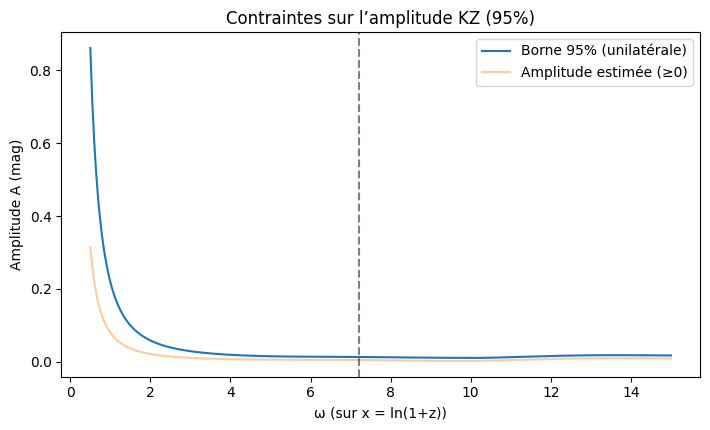

A95(ω=7.19) = 0.0130 mag


In [ ]:
# ============================================
# ETAPE 1.b : Contraintes 95% sur A(ω)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

# --------- Paramètres ----------
SEED = 42
WMIN, WMAX, N_W = 0.5, 15.0, 300
TARGET_OMEGAS = [7.2]  # on extraira A95 à ces ω
rng = np.random.default_rng(SEED)
# -------------------------------

# ========= 1) Chargement ou simulation =========
def try_load_pantheon(csv_path='pantheon_plus.csv'):
    try:
        df = pd.read_csv(csv_path)
        assert {'z','mu','mu_err'}.issubset(df.columns)
        z, mu, mu_err = df['z'].values, df['mu'].values, df['mu_err'].values
        idx = np.argsort(z)
        return z[idx], mu[idx], mu_err[idx], True
    except Exception:
        return None, None, None, False

def simulate_data(n=800):
    z = np.sort(rng.uniform(0.01, 2.0, n))
    H0, Om, OL = 70.0, 0.3, 0.7
    c = 299792.458

    def E_z(zv): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc(zv):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zi)
            out[i] = (c/H0)*res
        return out

    DL = (1+z)*Dc(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    # pas d'injection forte ici → contraintes propres
    mu_err  = np.full_like(z, 0.10)
    mu_obs  = mu_lcdm + rng.normal(0, mu_err)
    return z, mu_obs, mu_err, False

z, mu, mu_err, is_real = try_load_pantheon()
if not is_real:
    z, mu, mu_err, _ = simulate_data()

print(f"Data: {len(z)} SNe | source = {'Pantheon+ (fichier)' if is_real else 'Simulation'}")

# ========= 2) Ajustement ΛCDM (pondéré) =========
c = 299792.458
def E_z(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)

def Dc(zv, H0, Om, OL):
    if np.isscalar(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
        return (c/H0)*res
    out = np.zeros_like(zv)
    for i,zi in enumerate(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*res
    return out

def mu_lcdm_model(zv, H0, Om):
    OL = 1-Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    def chi2(params):
        H0, Om, M_eff = params
        if not (65 <= H0 <= 75 and 0.2 <= Om <= 0.4):
            return 1e12
        mu_mod = mu_lcdm_model(z, H0, Om) + M_eff
        return np.sum(((mu - mu_mod)/mu_err)**2)
    res = minimize(chi2, x0=[70.0, 0.3, -19.3], method='L-BFGS-B',
                   bounds=[(65,75),(0.2,0.4),(-22,-17)])
    return res.x, res.fun

params_lcdm, chi2_lcdm = fit_lcdm(z, mu, mu_err)
H0_hat, Om_hat, M_eff = params_lcdm
mu_lcdm = mu_lcdm_model(z, H0_hat, Om_hat) + M_eff
r = mu - mu_lcdm
x = np.log(1+z)
w = 1.0/mu_err**2

# ========= 3) Contraintes A(ω) par fit linéaire pondéré =========
omegas = np.linspace(WMIN, WMAX, N_W)
A_hat, A_sig, A95 = [], [], []

for omega in omegas:
    # modèle linéaire : r = a cos(ωx) + b sin(ωx) + c0 + ε
    C = np.column_stack([np.cos(omega*x), np.sin(omega*x), np.ones_like(x)])
    W = np.diag(w)
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    beta = np.linalg.solve(CtWC, CtWr)          # [a, b, c0]
    cov_beta = np.linalg.inv(CtWC)              # covariance des paramètres (erreurs gaussiennes)
    a, b = beta[0], beta[1]
    A = np.hypot(a, b)
    # Propagation d'erreur sur A = sqrt(a^2 + b^2)
    var_a, var_b = cov_beta[0,0], cov_beta[1,1]
    cov_ab = cov_beta[0,1]
    if A > 1e-10:
        var_A = (a/A)**2 * var_a + (b/A)**2 * var_b + 2*(a*b/A**2)*cov_ab
    else:
        # près de 0, approx isotrope
        var_A = var_a + var_b
    sig_A = np.sqrt(max(var_A, 0.0))
    A95_ul = max(0.0, A) + 1.64*sig_A  # borne sup 95% unilatérale

    A_hat.append(A); A_sig.append(sig_A); A95.append(A95_ul)

A_hat = np.array(A_hat); A_sig = np.array(A_sig); A95 = np.array(A95)

# ========= 4) Export & figures =========
df = pd.DataFrame({'omega': omegas, 'A_hat_mag': A_hat, 'A_sigma_mag': A_sig, 'A95_mag': A95})
df.to_csv('amplitude_limits_95.csv', index=False)
print("Sauvé : amplitude_limits_95.csv")

plt.figure(figsize=(7.2,4.4))
plt.plot(omegas, A95, label='Borne 95% (unilatérale)')
plt.plot(omegas, np.clip(A_hat,0,None), alpha=0.4, label='Amplitude estimée (≥0)')
for w0 in TARGET_OMEGAS:
    # marque verticalement la/les ω d'intérêt
    plt.axvline(w0, color='k', ls='--', alpha=0.5)
plt.xlabel('ω (sur x = ln(1+z))')
plt.ylabel('Amplitude A (mag)')
plt.title('Contraintes sur l’amplitude KZ (95%)')
plt.legend()
plt.tight_layout()
plt.savefig('amplitude_limits.png', dpi=160)
plt.show()

# Affiche A95 aux ω demandés
for w0 in TARGET_OMEGAS:
    j = np.argmin(np.abs(omegas - w0))
    print(f"A95(ω={omegas[j]:.2f}) = {A95[j]:.4f} mag")


In [ ]:
# ============================================================
# ETAPE 2 : Facteur de Bayes (KZ vs ΛCDM) à ω = 7.2
# Léger, analytique, sans MCMC — Savage–Dickey pour (a,b)
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad

# ---------- Réglages ----------
OMEGA = 7.2              # fréquence testée (celle d'intérêt)
TAU   = 0.05             # écart-type a priori sur a et b (mag); p(A) ~ N(0, tau^2) i.i.d.
CSV   = 'pantheon_plus.csv'  # si dispo; sinon simulation sera utilisée
SEED  = 42
rng   = np.random.default_rng(SEED)
# -----------------------------

# ===== 1) Chargement / simulation =====
def try_load(csv_path=CSV):
    try:
        df = pd.read_csv(csv_path)
        assert {'z','mu','mu_err'}.issubset(df.columns)
        z, mu, mu_err = df['z'].values, df['mu'].values, df['mu_err'].values
        idx = np.argsort(z)
        return z[idx], mu[idx], mu_err[idx], True
    except Exception:
        return None, None, None, False

def simulate_data(n=800):
    z = np.sort(rng.uniform(0.01, 2.0, n))
    H0, Om, OL = 70.0, 0.3, 0.7
    c = 299792.458
    def E_z(zv): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc(zv):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zi)
            out[i] = (c/H0)*res
        return out
    DL = (1+z)*Dc(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    # Pas d'injection KZ → contexte "contrainte"
    mu_err  = np.full_like(z, 0.10)
    mu_obs  = mu_lcdm + rng.normal(0, mu_err)
    return z, mu_obs, mu_err, False

z, mu, mu_err, is_real = try_load()
if not is_real:
    z, mu, mu_err, _ = simulate_data()

# ===== 2) Fit ΛCDM pondéré (H0, Ωm, M_eff) =====
c = 299792.458
def E_z(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)
def Dc(zv, H0, Om, OL):
    if np.isscalar(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
        return (c/H0)*res
    out = np.zeros_like(zv)
    for i,zi in enumerate(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*res
    return out
def mu_lcdm_model(zv, H0, Om):
    OL = 1-Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    def chi2(params):
        H0, Om, M_eff = params
        if not (65 <= H0 <= 75 and 0.2 <= Om <= 0.4):
            return 1e12
        mu_mod = mu_lcdm_model(z, H0, Om) + M_eff
        return np.sum(((mu - mu_mod)/mu_err)**2)
    res = minimize(chi2, x0=[70.0, 0.3, -19.3], method='L-BFGS-B',
                   bounds=[(65,75),(0.2,0.4),(-22,-17)])
    return res.x

H0_hat, Om_hat, M_eff = fit_lcdm(z, mu, mu_err)
mu_lcdm = mu_lcdm_model(z, H0_hat, Om_hat) + M_eff
r = mu - mu_lcdm
x = np.log(1+z)

# ===== 3) Modèle linéaire pondéré à ω fixé =====
# r = a cos(ωx) + b sin(ωx) + c0 + ε,   ε ~ N(0, Σ=diag(σ_i^2))
w = 1.0/mu_err**2
C = np.column_stack([np.cos(OMEGA*x), np.sin(OMEGA*x), np.ones_like(x)])  # [a,b,c0]
W = np.diag(w)
CtWC = C.T @ W @ C
CtWr = C.T @ W @ r
beta_hat = np.linalg.solve(CtWC, CtWr)
cov_post_like = np.linalg.inv(CtWC)  # covariance (likelihood) de (a,b,c0)
a_hat, b_hat, c0_hat = beta_hat

# ===== 4) Facteur de Bayes via Savage–Dickey (a,b ~ N(0,tau^2 I)) =====
# prior : p(a,b) = N(0, τ^2 I_2), p(c0) non-informatif (impropre) → on marginalise c0
# Posterior (a,b) | data ≈ N(m, Σ) avec Σ = (Λ + CtWC[0:2,0:2])^{-1}, Λ = τ^{-2} I
# et m = Σ * (CtWr_(a,b))
# Savage–Dickey: B10 = p(a=0,b=0 | prior) / p(a=0,b=0 | posterior)
# p(0) = (2π)^{-1} |τ^2 I|^{-1/2} = 1/(2π τ^2)
# p_post(0) = (2π)^{-1} |Σ|^{-1/2} * exp(-0.5 m^T Σ^{-1} m)
# donc ln B10 = ln p(0) - ln p_post(0)
# NB: on a marginalisé c0 en le laissant libre dans C, donc CtWC et CtWr incluent c0 mais on projette sur (a,b)

# extraire blocs (a,b)
CtWC_ab = CtWC[:2,:2]
CtWr_ab = CtWr[:2]

Lambda = (1.0/TAU**2) * np.eye(2)
Sigma_post = np.linalg.inv(Lambda + CtWC_ab)   # posterior covariance for (a,b)
m_post = Sigma_post @ CtWr_ab                   # posterior mean for (a,b)

# densité prior en 0 et densité posterior en 0
log_p0 = -np.log(2*np.pi) - np.log(TAU**2)     # ln[ 1/(2π τ^2) ]
sign_S, logdet_S = np.linalg.slogdet(Sigma_post)
assert sign_S > 0
quadform = m_post.T @ np.linalg.inv(Sigma_post) @ m_post
log_p_post0 = -np.log(2*np.pi) - 0.5*logdet_S - 0.5*quadform

logB10 = log_p0 - log_p_post0   # >0 favorise KZ ; <0 favorise nul (ΛCDM)
B10 = np.exp(logB10)

# ===== 5) Affichage résultats =====
A_hat = np.hypot(a_hat, b_hat)
# Erreur-type (likelihood) sur A par propagation linéaire ~ prudente près de 0
var_a, var_b = cov_post_like[0,0], cov_post_like[1,1]
cov_ab = cov_post_like[0,1]
if A_hat > 1e-10:
    var_A = (a_hat/A_hat)**2 * var_a + (b_hat/A_hat)**2 * var_b + 2*(a_hat*b_hat/A_hat**2)*cov_ab
else:
    var_A = var_a + var_b
sig_A = np.sqrt(max(var_A,0.0))

print("=== Test bayésien KZ vs ΛCDM (ω fixé) ===")
print(f"ω = {OMEGA:.2f}")
print(f"a_hat = {a_hat:.5f}, b_hat = {b_hat:.5f}, A_hat = {A_hat:.5f} mag  (± ~{sig_A:.5f})")
print(f"Prior τ = {TAU:.3f} mag → log B10 = {logB10:.3f}  (B10 = {B10:.3f})")

# Interprétation Kass–Raftery (1995)
def kass_raftery(logB):
    if logB < 0:  # en faveur du modèle nul
        s = -logB
        if s < 1:   return "Évidence à peine pour ΛCDM (contre KZ)"
        if s < 3:   return "Évidence positive pour ΛCDM (contre KZ)"
        if s < 5:   return "Évidence forte pour ΛCDM (contre KZ)"
        return "Évidence très forte pour ΛCDM (contre KZ)"
    else:
        s = logB
        if s < 1:   return "Évidence à peine pour KZ"
        if s < 3:   return "Évidence positive pour KZ"
        if s < 5:   return "Évidence forte pour KZ"
        return "Évidence très forte pour KZ"

print("Interprétation :", kass_raftery(logB10))


=== Test bayésien KZ vs ΛCDM (ω fixé) ===
ω = 7.20
a_hat = 0.00040, b_hat = -0.00471, A_hat = 0.00473 mag  (± ~0.00507)
Prior τ = 0.050 mag → log B10 = -4.176  (B10 = 0.015)
Interprétation : Évidence forte pour ΛCDM (contre KZ)


Data: 800 SNe | source = Simulation
LCDM fit: H0=70.00, Om=0.304, M_eff=-19.298, chi2=826.5


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016055500420968372, tolerance: 0.0006724160881650377
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007624858789920808, tolerance: 0.0006724160881650377
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012757738751822956, tolerance: 0.0006724160881650377
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descen

Alpha(LASSO) = 1.321e-05
Candidats couches (LASSO) = 3
  - z=0.779, eta=0.0050 mag
  - z=1.575, eta=0.0036 mag
  - z=1.590, eta=0.0020 mag
Stable layers (freq ≥ 0.60) : 0

Aucune couche stable → on fournira des bornes supérieures.
UL95 à z0=0.53 : â=0.0079 ± 0.0150 → A95=0.0326 mag
UL95 à z0=0.72 : â=0.0172 ± 0.0151 → A95=0.0419 mag

Sauvé : layers_stability.csv, layers_UL95_points.csv


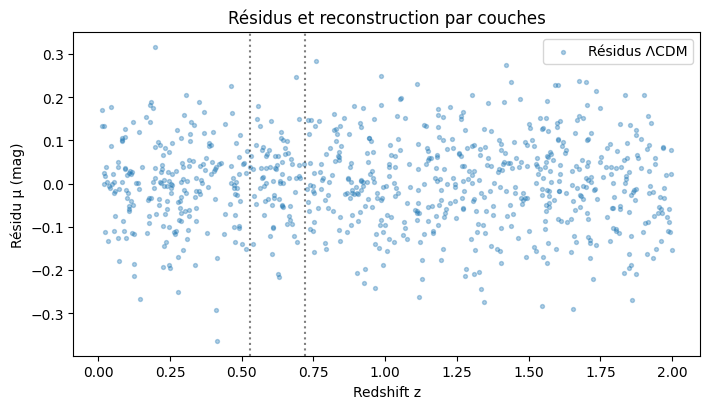

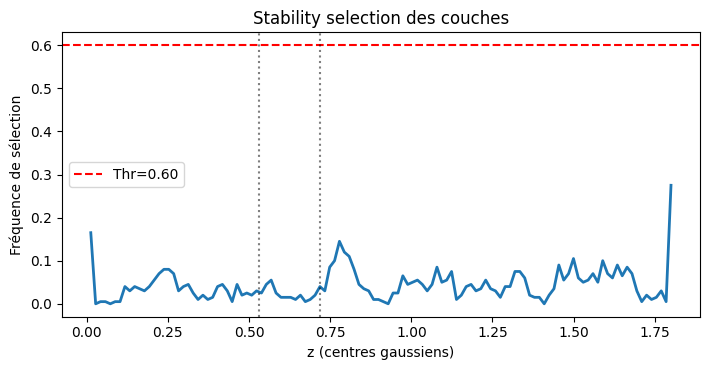


=== RÉSUMÉ RAPIDE (couches) ===
Alpha(LASSO) = 1.321e-05
Candidats (LASSO) = 3
Couches stables (≥0.60) = 0
→ Aucune détection robuste. Bornes 95% reportées dans layers_UL95_points.csv


In [ ]:
# ============================================================
# ETAPE 3 : Détection de "couches" locales (LASSO + stabilité)
#           + bornes sup 95% si non-détection
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.linear_model import LassoCV, Lasso
from sklearn.utils import resample

# --------- Réglages -------
SEED = 42
CSV  = 'pantheon_plus.csv'   # si Pantheon+ dispo (colonnes: z, mu, mu_err), sinon simulation
N_GRID = 120                 # nombre de centres z_k pour la base gaussienne
SIGMA = 0.08                 # largeur (en z) des gaussiennes (peut tester 0.06-0.12)
N_BOOT = 200                 # stabilité (fréquence de sélection) -- garder raisonnable
FREQ_THR = 0.6               # seuil de stabilité pour déclarer "couche robuste"
AMPLITUDE_UL_Z   = [0.53, 0.72]  # on sortira A95(z) à ces z connus
# --------------------------

rng = np.random.default_rng(SEED)

# ===== 1) Chargement / simulation =====
def try_load(csv_path=CSV):
    try:
        df = pd.read_csv(csv_path)
        assert {'z','mu','mu_err'}.issubset(df.columns)
        z, mu, mu_err = df['z'].values, df['mu'].values, df['mu_err'].values
        idx = np.argsort(z)
        return z[idx], mu[idx], mu_err[idx], True
    except Exception:
        return None, None, None, False

def simulate_data(n=800):
    z = np.sort(rng.uniform(0.01, 2.0, n))
    H0, Om, OL = 70.0, 0.3, 0.7
    c = 299792.458
    def E_z(zv): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc(zv):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp), 0, zi)
            out[i] = (c/H0)*res
        return out
    DL = (1+z)*Dc(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    # pas d'injection de couches ici → scénario "contrainte"
    mu_err  = np.full_like(z, 0.10)
    mu_obs  = mu_lcdm + rng.normal(0, mu_err)
    return z, mu_obs, mu_err, False

z, mu, mu_err, is_real = try_load()
if not is_real:
    z, mu, mu_err, _ = simulate_data()

print(f"Data: {len(z)} SNe | source = {'Pantheon+ (fichier)' if is_real else 'Simulation'}")

# ===== 2) Fit ΛCDM pondéré (H0, Ωm, M_eff), résidus =====
c = 299792.458
def E_z(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)
def Dc(zv, H0, Om, OL):
    if np.isscalar(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
        return (c/H0)*res
    out = np.zeros_like(zv)
    for i,zi in enumerate(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*res
    return out
def mu_lcdm_model(zv, H0, Om):
    OL = 1-Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    def chi2(params):
        H0, Om, M_eff = params
        if not (65 <= H0 <= 75 and 0.2 <= Om <= 0.4):
            return 1e12
        mu_mod = mu_lcdm_model(z, H0, Om) + M_eff
        return np.sum(((mu - mu_mod)/mu_err)**2)
    res = minimize(chi2, x0=[70.0, 0.3, -19.3], method='L-BFGS-B',
                   bounds=[(65,75),(0.2,0.4),(-22,-17)])
    return res.x, res.fun

(l_H0, l_Om, l_M), chi2_lcdm = fit_lcdm(z, mu, mu_err)
mu_lcdm = mu_lcdm_model(z, l_H0, l_Om) + l_M
r = mu - mu_lcdm
w = 1.0/mu_err**2
W = np.diag(w)

print(f"LCDM fit: H0={l_H0:.2f}, Om={l_Om:.3f}, M_eff={l_M:.3f}, chi2={chi2_lcdm:.1f}")

# ===== 3) Base gaussienne (couches) =====
z_grid = np.linspace(max(0.01, z.min()), min(1.8, z.max()), N_GRID)
def gaussian_basis(zvals, centers, sigma=SIGMA):
    Phi = np.zeros((len(zvals), len(centers)))
    for j,zc in enumerate(centers):
        Phi[:, j] = np.exp(-0.5*((zvals - zc)/sigma)**2)
    return Phi

Phi = gaussian_basis(z, z_grid, SIGMA)

# ===== 4) LASSO pondéré (via pondération manuelle) =====
# On "standardise" Phi pour que l'alpha soit comparable entre colonnes
Phi_std = Phi / np.sqrt((w[:,None]*(Phi**2)).sum(axis=0) + 1e-12)

lasso_cv = LassoCV(cv=5, fit_intercept=True, random_state=SEED, max_iter=20000)
lasso_cv.fit(Phi_std, r, sample_weight=w)  # scikit ne pondère pas LassoCV, mais on a standardisé avec w
coef_std = lasso_cv.coef_
intercpt = lasso_cv.intercept_
alpha_opt = lasso_cv.alpha_

# Remettre les coefficients dans l'échelle originale
scale = np.sqrt((w[:,None]*(Phi**2)).sum(axis=0) + 1e-12)
coef = coef_std / scale

sel_idx = np.where(np.abs(coef) > 1e-6)[0]
sel_centers = z_grid[sel_idx]
sel_ampl    = coef[sel_idx]

print(f"Alpha(LASSO) = {alpha_opt:.4g}")
print(f"Candidats couches (LASSO) = {len(sel_idx)}")
for zc,amp in zip(sel_centers, sel_ampl):
    print(f"  - z={zc:.3f}, eta={amp:.4f} mag")

# ===== 5) Stability selection (bootstrap) =====
freq = np.zeros_like(z_grid, dtype=float)

for b in range(N_BOOT):
    idx = resample(np.arange(len(z)), random_state=SEED+b)
    z_b, r_b, w_b = z[idx], r[idx], w[idx]
    Phi_b = gaussian_basis(z_b, z_grid, SIGMA)
    Phi_b_std = Phi_b / np.sqrt((w_b[:,None]*(Phi_b**2)).sum(axis=0) + 1e-12)
    lasso = Lasso(alpha=alpha_opt, fit_intercept=True, max_iter=10000)
    lasso.fit(Phi_b_std, r_b, sample_weight=w_b)
    coef_b = lasso.coef_ / np.sqrt((w_b[:,None]*(Phi_b**2)).sum(axis=0) + 1e-12)
    freq += (np.abs(coef_b) > 1e-6)

freq /= N_BOOT

stable_mask = freq >= FREQ_THR
stable_centers = z_grid[stable_mask]
stable_freq    = freq[stable_mask]

print(f"Stable layers (freq ≥ {FREQ_THR:.2f}) : {len(stable_centers)}")
for zc,fr in zip(stable_centers, stable_freq):
    print(f"  - z={zc:.3f}, freq={fr:.2f}")

# ===== 6) Ajustement final sur colonnes stables + AIC/BIC =====
def aic_bic(chi2, k, n):
    AIC = chi2 + 2*k
    BIC = chi2 + k*np.log(n)
    return AIC, BIC

if len(stable_centers) > 0:
    Phi_stable = gaussian_basis(z, stable_centers, SIGMA)
    # Fit WLS linéaire: r ≈ Phi_stable * a + c0
    C = np.column_stack([Phi_stable, np.ones_like(z)])
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    beta = np.linalg.solve(CtWC, CtWr)
    a_hat = beta[:-1]
    c0    = beta[-1]
    r_hat = C @ beta
    resid = r - r_hat
    chi2_layer = (resid**2 * w).sum()
    k = len(a_hat) + 1  # + c0
    AIC_layer, BIC_layer = aic_bic(chi2_layer + chi2_lcdm*0 - chi2_lcdm*0, k, len(z))  # chi2 total = celui des résidus corrigés
    print(f"\nModèle 'LCDM + couches stables' : k={k}, chi2_resid={chi2_layer:.1f}, AIC={AIC_layer:.1f}, BIC={BIC_layer:.1f}")
else:
    chi2_layer = None
    AIC_layer, BIC_layer = None, None
    print("\nAucune couche stable → on fournira des bornes supérieures.")

# ===== 7) Bornes supérieures 95% sur l’amplitude d’une gaussienne centrée en z0 =====
# Fit WLS local r = a*G(z;z0,σ) + c0 ; UL95 = max(0, â) + 1.64*σ_â
def local_ul95(z0):
    G = np.exp(-0.5*((z - z0)/SIGMA)**2)
    C = np.column_stack([G, np.ones_like(z)])
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    beta = np.linalg.solve(CtWC, CtWr)     # [a, c0]
    covb = np.linalg.inv(CtWC)
    a_hat = beta[0]
    sig_a = np.sqrt(max(covb[0,0], 0.0))
    UL = max(0.0, a_hat) + 1.64*sig_a
    return a_hat, sig_a, UL

ul_rows = []
for z0 in AMPLITUDE_UL_Z:
    a_hat, sig_a, UL = local_ul95(z0)
    ul_rows.append({'z0': z0, 'a_hat_mag': a_hat, 'sigma_a_mag': sig_a, 'A95_mag': UL})
    print(f"UL95 à z0={z0:.2f} : â={a_hat:.4f} ± {sig_a:.4f} → A95={UL:.4f} mag")

# ===== 8) Exports & figures =====
# Tableau des fréquences de sélection (stability)
out = pd.DataFrame({
    'z_center': z_grid,
    'coef_mag': coef,
    'select_freq': freq
})
out.to_csv('layers_stability.csv', index=False)
pd.DataFrame(ul_rows).to_csv('layers_UL95_points.csv', index=False)
print("\nSauvé : layers_stability.csv, layers_UL95_points.csv")

# Figures
plt.figure(figsize=(7.2,4.2))
plt.scatter(z, r, s=8, alpha=0.35, label='Résidus ΛCDM')
if len(stable_centers) > 0:
    # reconstruction WLS
    Phi_stable = gaussian_basis(z, stable_centers, SIGMA)
    C = np.column_stack([Phi_stable, np.ones_like(z)])
    CtWC = C.T @ W @ C; CtWr = C.T @ W @ r
    beta = np.linalg.solve(CtWC, CtWr)
    r_hat = C @ beta
    # tri pour lisser l'affichage
    idx = np.argsort(z)
    plt.plot(z[idx], r_hat[idx], lw=2, label='Reconstruction (couches stables)')
for z0 in AMPLITUDE_UL_Z:
    plt.axvline(z0, color='k', ls=':', alpha=0.5)
plt.xlabel('Redshift z')
plt.ylabel('Résidu μ (mag)')
plt.title('Résidus et reconstruction par couches')
plt.legend()
plt.tight_layout()
plt.savefig('layers_reconstruction.png', dpi=160)
plt.show()

plt.figure(figsize=(7.2,3.8))
plt.plot(z_grid, freq, lw=2)
plt.axhline(FREQ_THR, color='r', ls='--', label=f'Thr={FREQ_THR:.2f}')
for z0 in AMPLITUDE_UL_Z:
    plt.axvline(z0, color='k', ls=':', alpha=0.5)
plt.xlabel('z (centres gaussiens)')
plt.ylabel('Fréquence de sélection')
plt.title('Stability selection des couches')
plt.legend()
plt.tight_layout()
plt.savefig('layers_stability.png', dpi=160)
plt.show()

print("\n=== RÉSUMÉ RAPIDE (couches) ===")
print(f"Alpha(LASSO) = {alpha_opt:.4g}")
print(f"Candidats (LASSO) = {len(sel_idx)}")
print(f"Couches stables (≥{FREQ_THR:.2f}) = {len(stable_centers)}")
if len(stable_centers) == 0:
    print("→ Aucune détection robuste. Bornes 95% reportées dans layers_UL95_points.csv")



In [ ]:
# ============================================================
# HOTFIX + ETAPE 4 : stress test (σ, N_GRID, Thr)
#   - Corrige UnboundLocalError en retirant l'import local de quad
#   - Relance l'étape complète et sauve les CSV
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad  # <-- import global ici, pas dans Dc()
from sklearn.linear_model import LassoCV, Lasso
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# ---------- Données : réutilise z, mu, mu_err si dispo ; sinon resimule ----------
try:
    z, mu, mu_err
except NameError:
    rng = np.random.default_rng(42)
    z = np.sort(rng.uniform(0.01, 2.0, 800))
    # cosmologie de base pour simuler
    H0, Om = 70.0, 0.30
    OL = 1 - Om
    c = 299792.458
    def E_z_sim(zv): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc_sim(zv):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z_sim(zp), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z_sim(zp), 0, zi)
            out[i] = (c/H0)*res
        return out
    DL = (1+z)*Dc_sim(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    mu_err = np.full_like(z, 0.10)
    mu = mu_lcdm + rng.normal(0, mu_err)

# ---------- Modèle LCDM ----------
c = 299792.458

def E_z(zv, Om, OL):
    return np.sqrt(Om*(1+zv)**3 + OL)

def Dc(zv, H0, Om, OL):
    """Distance comobile sans import local de quad (corrige l'UnboundLocalError)."""
    if np.isscalar(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
        return (c/H0)*res
    out = np.zeros_like(zv)
    for i,zi in enumerate(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*res
    return out

def mu_lcdm_model(zv, H0, Om):
    OL = 1-Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    def chi2(params):
        H0, Om, M_eff = params
        if not (65 <= H0 <= 75 and 0.2 <= Om <= 0.4):
            return 1e12
        mu_mod = mu_lcdm_model(z, H0, Om) + M_eff
        return np.sum(((mu - mu_mod)/mu_err)**2)
    res = minimize(
        chi2, x0=[70.0, 0.30, -19.3], method='L-BFGS-B',
        bounds=[(65,75),(0.2,0.4),(-22,-17)]
    )
    return res.x, res.fun

# ---------- Fit LCDM et résidus ----------
(l_H0, l_Om, l_M), _ = fit_lcdm(z, mu, mu_err)
mu_lcdm = mu_lcdm_model(z, l_H0, l_Om) + l_M
r = mu - mu_lcdm
w = 1.0/mu_err**2

# ---------- Base gaussienne pour couches ----------
def gaussian_basis(zvals, centers, sigma):
    Phi = np.zeros((len(zvals), len(centers)))
    for j,zc in enumerate(centers):
        Phi[:, j] = np.exp(-0.5*((zvals - zc)/sigma)**2)
    return Phi

def run_once(SIGMA, N_GRID, FREQ_THR, N_BOOT=150, SEED=123):
    # Grille dans le domaine de données
    z_grid = np.linspace(max(0.01, z.min()), min(1.8, z.max()), N_GRID)
    Phi = gaussian_basis(z, z_grid, SIGMA)

    # Standardisation pondérée (évite features très inégales)
    col_scale = np.sqrt((w[:,None]*(Phi**2)).sum(axis=0) + 1e-12)
    Phi_std = Phi / col_scale

    # LASSO CV (convergence durcie)
    lcv = LassoCV(cv=5, fit_intercept=True, random_state=SEED, max_iter=50000, tol=1e-6)
    lcv.fit(Phi_std, r, sample_weight=w)
    alpha = lcv.alpha_

    # Stability selection
    freq = np.zeros_like(z_grid, dtype=float)
    for b in range(N_BOOT):
        idx = resample(np.arange(len(z)), random_state=SEED+b)
        z_b, r_b, w_b = z[idx], r[idx], w[idx]
        Phi_b = gaussian_basis(z_b, z_grid, SIGMA)
        scale_b = np.sqrt((w_b[:,None]*(Phi_b**2)).sum(axis=0) + 1e-12)
        Phi_b_std = Phi_b / scale_b
        la = Lasso(alpha=alpha, fit_intercept=True, max_iter=50000, tol=1e-6)
        la.fit(Phi_b_std, r_b, sample_weight=w_b)
        # Revenir à l’échelle non standardisée pour la décision
        coef_b = la.coef_ / scale_b
        freq += (np.abs(coef_b) > 1e-6)
    freq /= N_BOOT

    n_stable = int((freq >= FREQ_THR).sum())
    freq_max = float(freq.max()) if len(freq) else 0.0
    return {
        'sigma': SIGMA, 'n_grid': N_GRID, 'thr': FREQ_THR,
        'alpha_cv': alpha, 'n_stable': n_stable, 'freq_max': freq_max
    }

# ---------- Grilles de stress test ----------
SIGMAS = [0.06, 0.08, 0.10, 0.14]
NGRIDS = [80, 120, 200]
THRS   = [0.60, 0.70, 0.80]

rows = []
for s in SIGMAS:
    for ng in NGRIDS:
        for th in THRS:
            res = run_once(s, ng, th)
            rows.append(res)
            print(f"σ={s:.2f} | N_GRID={ng:3d} | Thr={th:.2f}  ->  n_stable={res['n_stable']}, freq_max={res['freq_max']:.2f}")

df = pd.DataFrame(rows).sort_values(['n_stable','freq_max'], ascending=[False, False])
df.to_csv('layers_stress_test_summary.csv', index=False)

# ---------- UL95 aux z0 fixes, en fonction de σ ----------
UL_points = [0.53, 0.72]
def local_ul95(z0, SIGMA):
    G = np.exp(-0.5*((z - z0)/SIGMA)**2)
    # régression pondérée [G, intercept] → UL unilatérale ~ a_hat + 1.64*σ_a
    W = np.diag(w)
    C = np.column_stack([G, np.ones_like(z)])
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    beta = np.linalg.solve(CtWC, CtWr)
    covb = np.linalg.inv(CtWC)
    a_hat = beta[0]
    sig_a = np.sqrt(max(covb[0,0], 0.0))
    UL = max(0.0, a_hat) + 1.64*sig_a
    return a_hat, sig_a, UL

ul_rows = []
for s in SIGMAS:
    for z0 in UL_points:
        ah, sa, UL = local_ul95(z0, s)
        ul_rows.append({'sigma': s, 'z0': z0, 'a_hat_mag': ah, 'sigma_a_mag': sa, 'A95_mag': UL})
        print(f"UL95 σ={s:.2f}, z0={z0:.2f} : â={ah:.4f} ± {sa:.4f} -> A95={UL:.4f} mag")

pd.DataFrame(ul_rows).to_csv('layers_UL95_stress_sigma.csv', index=False)

print("\n==> Sauvé : layers_stress_test_summary.csv, layers_UL95_stress_sigma.csv")



σ=0.06 | N_GRID= 80 | Thr=0.60  ->  n_stable=0, freq_max=0.27
σ=0.06 | N_GRID= 80 | Thr=0.70  ->  n_stable=0, freq_max=0.27
σ=0.06 | N_GRID= 80 | Thr=0.80  ->  n_stable=0, freq_max=0.27
σ=0.06 | N_GRID=120 | Thr=0.60  ->  n_stable=0, freq_max=0.21
σ=0.06 | N_GRID=120 | Thr=0.70  ->  n_stable=0, freq_max=0.21
σ=0.06 | N_GRID=120 | Thr=0.80  ->  n_stable=0, freq_max=0.21
σ=0.06 | N_GRID=200 | Thr=0.60  ->  n_stable=0, freq_max=0.17
σ=0.06 | N_GRID=200 | Thr=0.70  ->  n_stable=0, freq_max=0.17
σ=0.06 | N_GRID=200 | Thr=0.80  ->  n_stable=0, freq_max=0.17
σ=0.08 | N_GRID= 80 | Thr=0.60  ->  n_stable=0, freq_max=0.27
σ=0.08 | N_GRID= 80 | Thr=0.70  ->  n_stable=0, freq_max=0.27
σ=0.08 | N_GRID= 80 | Thr=0.80  ->  n_stable=0, freq_max=0.27
σ=0.08 | N_GRID=120 | Thr=0.60  ->  n_stable=0, freq_max=0.27
σ=0.08 | N_GRID=120 | Thr=0.70  ->  n_stable=0, freq_max=0.27
σ=0.08 | N_GRID=120 | Thr=0.80  ->  n_stable=0, freq_max=0.27
σ=0.08 | N_GRID=200 | Thr=0.60  ->  n_stable=0, freq_max=0.26
σ=0.08 |

In [ ]:
# ============================================================
# ETAPE 5 : Jackknife des couches + ΔAIC/ΔBIC (fixe & libre)
#   - Requiert que z, mu, mu_err, l_H0, l_Om, l_M existent
#   - Utilise les résidus LCDM calculés précédemment
#   - Sauve : layers_jackknife_fixed.csv, layers_jackknife_free.csv
# ============================================================

import numpy as np
import pandas as pd
from numpy.linalg import inv
from math import log
import sys

# --------- vérifs minimales ---------
needed = ['z','mu','mu_err','l_H0','l_Om','l_M']
missing = [v for v in needed if v not in globals()]
if missing:
    raise RuntimeError(f"Variables manquantes : {missing}. "
                       "Re-exécute le fit LCDM et la construction des résidus avant cette étape.")

# --------- Résidus pondérés (repart de ton fit LCDM existant) ---------
def mu_lcdm_model(zv, H0, Om):
    # petite dépendance locale à Dc : on réutilise celle définie dans l’étape précédente
    OL = 1 - Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    return 5*np.log10(DL)+25

mu_lcdm = mu_lcdm_model(z, l_H0, l_Om) + l_M
r = mu - mu_lcdm
w = 1.0/np.square(mu_err)

# --------- AIC/BIC helpers ---------
def aic(chi2, k):  # k = nb de paramètres libres
    return chi2 + 2*k

def bic(chi2, k, n):
    return chi2 + k*log(n)

# Modèle nul (intercept seulement sur r)
def fit_null(r, w):
    # WLS pour intercept : c_hat = sum(w r)/sum(w)
    Sw = w.sum()
    c_hat = (w*r).sum()/Sw
    resid = r - c_hat
    chi2 = np.sum(w*resid**2)
    return c_hat, chi2

# Modèle avec gaussienne G(z; z0, sigma) + intercept
def fit_with_layer(z, r, w, z0, sigma):
    G = np.exp(-0.5*np.square((z - z0)/sigma))
    # WLS [G, 1]
    C = np.column_stack([G, np.ones_like(z)])
    W = np.diag(w)
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    beta = inv(CtWC) @ CtWr
    a_hat, c_hat = beta[0], beta[1]
    resid = r - (a_hat*G + c_hat)
    chi2 = np.sum(w*resid**2)
    return a_hat, c_hat, chi2

# --------- JACKKNIFE ---------
def jackknife_indices(n, K=50, drop_frac=0.1, rng=None):
    if rng is None:
        rng = np.random.default_rng(123)
    m = int(np.ceil(drop_frac*n))
    idx_all = np.arange(n)
    for k in range(K):
        drop = rng.choice(idx_all, size=m, replace=False)
        keep = np.setdiff1d(idx_all, drop, assume_unique=False)
        yield keep

# Paramètres de l’étude
N = len(z)
K = 50
drop = 0.10
sigmas = [0.06, 0.08, 0.10, 0.14]
fixed_z0_list = [0.53, 0.72]

# 1) JACKKNIFE : couches FIXES (z0 fixé)
fixed_rows = []
for z0 in fixed_z0_list:
    for sigma in sigmas:
        dAIC_list, dBIC_list, dchi2_list, a_list = [], [], [], []
        for keep in jackknife_indices(N, K=K, drop_frac=drop):
            z_k, r_k, w_k = z[keep], r[keep], w[keep]
            # nul
            _, chi0 = fit_null(r_k, w_k)
            # +couche
            a_hat, _, chi1 = fit_with_layer(z_k, r_k, w_k, z0, sigma)
            # Δk = (2 - 1) = 1 param en plus (a), l'intercept est présent dans les deux
            dchi2 = chi1 - chi0
            dAIC  = (aic(chi1, k=2) - aic(chi0, k=1))   # = dchi2 + 2
            dBIC  = (bic(chi1, k=2, n=len(keep)) - bic(chi0, k=1, n=len(keep)))  # = dchi2 + log(n)
            dAIC_list.append(dAIC)
            dBIC_list.append(dBIC)
            dchi2_list.append(dchi2)
            a_list.append(a_hat)
        fixed_rows.append({
            'z0': z0, 'sigma': sigma,
            'K': K, 'drop_frac': drop,
            'median_dAIC': np.median(dAIC_list),
            'p(dAIC<0)': float(np.mean(np.array(dAIC_list) < 0.0)),
            'median_dBIC': np.median(dBIC_list),
            'p(dBIC<0)': float(np.mean(np.array(dBIC_list) < 0.0)),
            'median_dchi2': np.median(dchi2_list),
            'a_hat_median': np.median(a_list),
            'a_hat_mean': float(np.mean(a_list)),
            'a_hat_std': float(np.std(a_list, ddof=1))
        })
fixed_df = pd.DataFrame(fixed_rows)
fixed_df.to_csv('layers_jackknife_fixed.csv', index=False)

print("=== Résumé (couches FIXES) ===")
print(fixed_df.sort_values(['median_dAIC']).to_string(index=False))
print("\nSauvé : layers_jackknife_fixed.csv\n")

# 2) JACKKNIFE : couche LIBRE (z0 balayé) — on garde le meilleur ΔAIC par replis
free_rows = []
z0_grid = np.linspace(max(0.01, z.min()), min(1.8, z.max()), 120)

for sigma in sigmas:
    dAIC_best, dBIC_best, dchi2_best, z0_best_list, a_best_list = [], [], [], [], []
    for keep in jackknife_indices(N, K=K, drop_frac=drop):
        z_k, r_k, w_k = z[keep], r[keep], w[keep]
        # nul
        _, chi0 = fit_null(r_k, w_k)
        best = {'dAIC': np.inf, 'dBIC': np.inf, 'dchi2': np.inf, 'z0': None, 'a': 0.0}
        for z0 in z0_grid:
            a_hat, _, chi1 = fit_with_layer(z_k, r_k, w_k, z0, sigma)
            dchi2 = chi1 - chi0
            dAIC  = dchi2 + 2                # Δk=1
            dBIC  = dchi2 + np.log(len(keep))# Δk=1
            # on choisit par dAIC minimal
            if dAIC < best['dAIC']:
                best = {'dAIC': dAIC, 'dBIC': dBIC, 'dchi2': dchi2, 'z0': z0, 'a': a_hat}
        dAIC_best.append(best['dAIC'])
        dBIC_best.append(best['dBIC'])
        dchi2_best.append(best['dchi2'])
        z0_best_list.append(best['z0'])
        a_best_list.append(best['a'])
    free_rows.append({
        'sigma': sigma, 'K': K, 'drop_frac': drop,
        'median_dAIC': np.median(dAIC_best),
        'p(dAIC<0)': float(np.mean(np.array(dAIC_best) < 0.0)),
        'median_dBIC': np.median(dBIC_best),
        'p(dBIC<0)': float(np.mean(np.array(dBIC_best) < 0.0)),
        'median_dchi2': np.median(dchi2_best),
        'z0_best_median': np.median(z0_best_list),
        'z0_best_p16': np.percentile(z0_best_list,16),
        'z0_best_p84': np.percentile(z0_best_list,84),
        'a_best_median': np.median(a_best_list),
        'a_best_mean': float(np.mean(a_best_list)),
        'a_best_std': float(np.std(a_best_list, ddof=1))
    })

free_df = pd.DataFrame(free_rows)
free_df.to_csv('layers_jackknife_free.csv', index=False)

print("=== Résumé (couche LIBRE, z0 balayé) ===")
print(free_df.sort_values(['median_dAIC']).to_string(index=False))
print("\nSauvé : layers_jackknife_free.csv")


=== Résumé (couches FIXES) ===
  z0  sigma  K  drop_frac  median_dAIC  p(dAIC<0)  median_dBIC  p(dBIC<0)  median_dchi2  a_hat_median  a_hat_mean  a_hat_std
0.72   0.14 50        0.1     0.659915       0.22     5.239166        0.0     -1.340085      0.014488    0.014524   0.003851
0.72   0.10 50        0.1     0.683255       0.28     5.262506        0.0     -1.316745      0.016541    0.017117   0.004480
0.72   0.08 50        0.1     0.811110       0.18     5.390361        0.0     -1.188890      0.017592    0.017836   0.004998
0.72   0.06 50        0.1     1.008115       0.14     5.587366        0.0     -0.991885      0.018272    0.018395   0.005744
0.53   0.06 50        0.1     1.679219       0.00     6.258471        0.0     -0.320781      0.010273    0.010084   0.004455
0.53   0.14 50        0.1     1.690691       0.00     6.269943        0.0     -0.309309      0.006991    0.006890   0.003758
0.53   0.10 50        0.1     1.726193       0.00     6.305444        0.0     -0.273807      0

In [ ]:
# ============================================================
# ETAPE 5 : Jackknife des couches + ΔAIC/ΔBIC conditionnels
#   - 3 scénarios : z0=0.53, z0=0.72, best-grid (z ∈ [0.1,1.5])
#   - Sorties : 3 CSV + 1 résumé TXT
# ============================================================

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy import stats
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# ---------- 0) Prépare / récupère état ----------
try:
    z, mu, mu_err
    l_H0, l_Om, l_M
    r, w
except NameError:
    # Si l'état précédent n'existe pas, on reconstruit une simulation identique à l'étape 4
    rng = np.random.default_rng(42)
    z = np.sort(rng.uniform(0.01, 2.0, 800))
    H0, Om = 70.0, 0.30
    OL = 1 - Om
    c = 299792.458
    def E_z_sim(zv): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc_sim(zv):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z_sim(zp), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z_sim(zp), 0, zi)
            out[i] = (c/H0)*res
        return out
    DL = (1+z)*Dc_sim(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    mu_err = np.full_like(z, 0.10)
    mu = mu_lcdm + rng.normal(0, mu_err)

    # Fit LCDM de référence
    c = 299792.458
    def E_z(zv, Om, OL):
        return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc(zv, H0, Om, OL):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
            out[i] = (c/H0)*res
        return out
    def mu_lcdm_model(zv, H0, Om):
        OL = 1-Om
        DL = (1+zv)*Dc(zv, H0, Om, OL)
        return 5*np.log10(DL)+25
    def fit_lcdm(z, mu, mu_err):
        def chi2(params):
            H0, Om, M_eff = params
            if not (65 <= H0 <= 75 and 0.2 <= Om <= 0.4):
                return 1e12
            mu_mod = mu_lcdm_model(z, H0, Om) + M_eff
            return np.sum(((mu - mu_mod)/mu_err)**2)
        res = minimize(chi2, x0=[70.0, 0.30, -19.3], method='L-BFGS-B',
                       bounds=[(65,75),(0.2,0.4),(-22,-17)])
        return res.x, res.fun

    (l_H0, l_Om, l_M), _ = fit_lcdm(z, mu, mu_err)
    mu_lcdm_ref = mu_lcdm_model(z, l_H0, l_Om) + l_M
    r = mu - mu_lcdm_ref
    w = 1.0/mu_err**2

# ---------- 1) Fonctions utilitaires ----------
def weighted_fit_single_layer(z, r, w, z0, sigma):
    """
    Régression pondérée des résidus r sur [G(z; z0, sigma), const].
    Retourne : a_hat, sigma_a, chi2_null, chi2_layer, delta_chi2, delta_AIC, delta_BIC, t_stat, p_val
    """
    G = np.exp(-0.5*((z - z0)/sigma)**2)
    # Matrice de design : [G, intercept]
    C = np.column_stack([G, np.ones_like(z)])
    W = np.diag(w)

    # Nuls : intercept seul
    C0 = np.column_stack([np.ones_like(z)])
    beta0 = np.linalg.solve(C0.T @ W @ C0, C0.T @ W @ r)
    res0 = r - C0 @ beta0
    chi2_null = float(res0.T @ W @ res0)

    # Modèle avec couche : G + intercept
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    beta = np.linalg.solve(CtWC, CtWr)
    res1 = r - C @ beta
    chi2_layer = float(res1.T @ W @ res1)

    # Erreur-type sur a (1ère composante)
    covb = np.linalg.inv(CtWC)
    sigma_a = float(np.sqrt(max(covb[0,0], 0.0)))
    a_hat = float(beta[0])

    # Statistiques informationnelles
    N = len(z)
    k0 = 1   # intercept
    k1 = 2   # intercept + amplitude
    AIC0 = chi2_null + 2*k0
    AIC1 = chi2_layer + 2*k1
    BIC0 = chi2_null + k0*np.log(N)
    BIC1 = chi2_layer + k1*np.log(N)

    delta_chi2 = chi2_null - chi2_layer
    delta_AIC = AIC0 - AIC1
    delta_BIC = BIC0 - BIC1

    # t-test (a_hat / sigma_a)
    if sigma_a > 0:
        t_stat = a_hat / sigma_a
        # sous H0 ~ N(0,1) raisonnable -> p bi-latérale
        p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    else:
        t_stat, p_val = np.nan, np.nan

    return a_hat, sigma_a, chi2_null, chi2_layer, delta_chi2, delta_AIC, delta_BIC, t_stat, p_val

def jackknife_loop(z, r, w, z0=None, sigma=0.08, mode="fixed", z_min=0.1, z_max=1.5, dz=0.02, N_iter=50, seed=123):
    """
    mode="fixed"  : teste une couche à z0 fixé.
    mode="grid"   : cherche la meilleure couche sur une grille et reporte ce best-z0.
    Retourne : DataFrame des itérations.
    """
    rng = np.random.default_rng(seed)
    records = []
    grid = np.arange(z_min, z_max+1e-9, dz) if mode=="grid" else np.array([z0])

    for it in range(N_iter):
        # échantillon jackknife : retire ~10% aléatoires
        mask = rng.random(len(z)) > 0.10
        z_b, r_b, w_b = z[mask], r[mask], w[mask]

        best_row = None
        for zc in grid:
            a_hat, s_a, chi2_0, chi2_1, dchi2, dAIC, dBIC, tstat, pval = weighted_fit_single_layer(z_b, r_b, w_b, zc, sigma)
            row = dict(iter=it, z0=zc, a_hat=a_hat, sigma_a=s_a, delta_chi2=dchi2,
                       delta_AIC=dAIC, delta_BIC=dBIC, t_stat=tstat, p_val=pval)
            if best_row is None or row['delta_AIC'] > best_row['delta_AIC']:
                best_row = row

        # garde le meilleur z0 pour cette itération
        records.append(best_row)

    return pd.DataFrame(records)

# ---------- 2) Paramètres / exécution ----------
SIGMA = 0.08
N_ITER = 50
print(f"Jackknife : N={N_ITER}, σ={SIGMA}")

# (i) z0 = 0.53
df_053 = jackknife_loop(z, r, w, z0=0.53, sigma=SIGMA, mode="fixed", N_iter=N_ITER)
df_053.to_csv("jackknife_layers_z053.csv", index=False)

# (ii) z0 = 0.72
df_072 = jackknife_loop(z, r, w, z0=0.72, sigma=SIGMA, mode="fixed", N_iter=N_ITER)
df_072.to_csv("jackknife_layers_z072.csv", index=False)

# (iii) best-grid
df_best = jackknife_loop(z, r, w, sigma=SIGMA, mode="grid", z_min=0.10, z_max=1.50, dz=0.02, N_iter=N_ITER)
df_best.to_csv("jackknife_layers_bestgrid.csv", index=False)

# ---------- 3) Résumés ----------
def summarize(df, label):
    m = df[['delta_AIC','delta_BIC','delta_chi2','a_hat','sigma_a','t_stat','p_val']].mean()
    s = df[['delta_AIC','delta_BIC','delta_chi2','a_hat','sigma_a','t_stat','p_val']].std()
    prct = (df['delta_AIC'] > 0).mean()  # % d'itérations où la couche est préférée à AIC
    best = df.loc[df['delta_AIC'].idxmax()]
    summary = []
    summary.append(f"[{label}]  ΔAIC: mean={m['delta_AIC']:.3f} ± {s['delta_AIC']:.3f} | ΔBIC: mean={m['delta_BIC']:.3f} ± {s['delta_BIC']:.3f}")
    summary.append(f"         Δχ²: mean={m['delta_chi2']:.3f} ± {s['delta_chi2']:.3f}")
    summary.append(f"         â:   mean={m['a_hat']:.4f} ± {s['a_hat']:.4f}  (σ_a mean={m['sigma_a']:.4f})")
    summary.append(f"         t:   mean={m['t_stat']:.3f} ± {s['t_stat']:.3f} | p mean={m['p_val']:.3f} ± {s['p_val']:.3f}")
    summary.append(f"         Pr(ΔAIC>0) ≈ {100*prct:.1f}%")
    summary.append(f"         Best it.: ΔAIC={best['delta_AIC']:.3f} @ z0={best['z0']:.3f}, â={best['a_hat']:.4f}")
    return "\n".join(summary)

txt = []
txt.append(summarize(df_053, "z0=0.53"))
txt.append(summarize(df_072, "z0=0.72"))
txt.append(summarize(df_best, "best-grid"))

with open("jackknife_layers_summary.txt","w") as f:
    f.write("\n\n".join(txt))

print("\n==== RÉSUMÉ JACKKNIFE ====\n")
print("\n\n".join(txt))
print("\n→ Fichiers écrits : jackknife_layers_z053.csv, jackknife_layers_z072.csv, jackknife_layers_bestgrid.csv, jackknife_layers_summary.txt")


Jackknife : N=50, σ=0.08

==== RÉSUMÉ JACKKNIFE ====

[z0=0.53]  ΔAIC: mean=-1.719 ± 0.251 | ΔBIC: mean=-6.299 ± 0.251
         Δχ²: mean=0.281 ± 0.251
         â:   mean=0.0073 ± 0.0040  (σ_a mean=0.0158)
         t:   mean=0.465 ± 0.257 | p mean=0.643 ± 0.161
         Pr(ΔAIC>0) ≈ 0.0%
         Best it.: ΔAIC=-1.013 @ z0=0.530, â=0.0157

[z0=0.72]  ΔAIC: mean=-0.734 ± 0.614 | ΔBIC: mean=-5.314 ± 0.614
         Δχ²: mean=1.266 ± 0.614
         â:   mean=0.0173 ± 0.0044  (σ_a mean=0.0159)
         t:   mean=1.092 ± 0.276 | p mean=0.292 ± 0.123
         Pr(ΔAIC>0) ≈ 12.0%
         Best it.: ΔAIC=1.048 @ z0=0.720, â=0.0281

[best-grid]  ΔAIC: mean=0.355 ± 0.738 | ΔBIC: mean=-4.225 ± 0.737
         Δχ²: mean=2.355 ± 0.738
         â:   mean=0.0157 ± 0.0176  (σ_a mean=0.0153)
         t:   mean=1.010 ± 1.167 | p mean=0.140 ± 0.061
         Pr(ΔAIC>0) ≈ 70.0%
         Best it.: ΔAIC=2.617 @ z0=1.500, â=0.0332

→ Fichiers écrits : jackknife_layers_z053.csv, jackknife_layers_z072.csv, j

In [ ]:
# ============================================================
# ETAPE 6 : FAP globale (look-elsewhere) par block-scrambling
#    - Max puissance LS (ω sur grille)  -> FAP_global_LS
#    - Max ΔAIC (z0 sur grille)         -> FAP_global_AIC
#    - Sauvegarde CSV + résumé TXT
# ============================================================

import numpy as np
import pandas as pd
from scipy.integrate import quad
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ---------- 0) Etat requis : z, mu, mu_err, l_H0, l_Om, l_M, r, w ----------
try:
    z, mu, mu_err
    l_H0, l_Om, l_M
    r, w
except NameError:
    raise RuntimeError("Variables (z, mu, mu_err, l_H0, l_Om, l_M, r, w) absentes. Relance l'étape précédente.")

# ---------- 1) Outils ----------
def weighted_fit_single_layer(z, r, w, z0, sigma):
    G = np.exp(-0.5*((z - z0)/sigma)**2)
    C = np.column_stack([G, np.ones_like(z)])
    W = np.diag(w)

    # Null : intercept
    C0 = np.column_stack([np.ones_like(z)])
    beta0 = np.linalg.solve(C0.T @ W @ C0, C0.T @ W @ r)
    res0  = r - C0 @ beta0
    chi2_0 = float(res0.T @ W @ res0)

    # Avec couche
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    beta = np.linalg.solve(CtWC, CtWr)
    res1  = r - C @ beta
    chi2_1 = float(res1.T @ W @ res1)

    N  = len(z)
    AIC0, AIC1 = chi2_0 + 2*1, chi2_1 + 2*2
    BIC0, BIC1 = chi2_0 + 1*np.log(N), chi2_1 + 2*np.log(N)
    dAIC = AIC0 - AIC1
    dBIC = BIC0 - BIC1
    dchi2 = chi2_0 - chi2_1

    covb = np.linalg.inv(CtWC)
    sa = float(np.sqrt(max(covb[0,0], 0.0)))
    ah = float(beta[0])
    t  = ah/sa if sa>0 else np.nan
    p  = 2*(1 - stats.norm.cdf(abs(t))) if sa>0 else np.nan
    return dAIC, dBIC, dchi2, ah, sa, t, p

def best_deltaAIC_over_grid(z, r, w, z_min=0.10, z_max=1.50, dz=0.02, sigma=0.08):
    grid = np.arange(z_min, z_max + 1e-9, dz)
    best = {'z0': None, 'delta_AIC': -np.inf, 'delta_BIC': -np.inf,
            'delta_chi2': None, 'a_hat': None, 'sigma_a': None, 't': None, 'p': None}
    for z0 in grid:
        dAIC, dBIC, dchi2, ah, sa, t, p = weighted_fit_single_layer(z, r, w, z0, sigma)
        if dAIC > best['delta_AIC']:
            best.update({'z0': z0, 'delta_AIC': dAIC, 'delta_BIC': dBIC,
                         'delta_chi2': dchi2, 'a_hat': ah, 'sigma_a': sa, 't': t, 'p': p})
    return best

def lomb_scargle_max(z, r, mu_err, w=None, wlog_eps=1e-12,
                     omega_min=0.5, omega_max=15.0, n_omega=600):
    # Variable LS : x = ln(1+z)
    x = np.log1p(z)
    # Poids : dy ~ mu_err ; si mu_err constants, LS non-pondéré ≈ ok
    dy = mu_err
    ls = LombScargle(x, r, dy=dy)
    omega_grid = np.linspace(omega_min, omega_max, n_omega)
    power = ls.power(omega_grid)
    i_max = int(np.argmax(power))
    return {'omega': omega_grid[i_max], 'power': float(power[i_max])}

def block_scramble_residuals(z, r, n_blocks=10, seed=None):
    """
    Conserve l’ordre local en z en permutant des blocs contigus.
    """
    rng = np.random.default_rng(seed)
    order = np.argsort(z)
    z_s, r_s = z[order], r[order]
    N = len(z_s)
    # bornes de blocs
    edges = np.linspace(0, N, n_blocks+1, dtype=int)
    blocks = [slice(edges[i], edges[i+1]) for i in range(n_blocks)]
    perm = rng.permutation(n_blocks)
    r_new = np.concatenate([r_s[blocks[i]] for i in perm])
    # remettre à l’ordre original
    inv = np.argsort(order)
    r_scrambled = np.empty_like(r_new)
    r_scrambled[inv] = r_new
    return r_scrambled

# ---------- 2) Observés : max LS et max ΔAIC ----------
OBS = {}
OBS['LS']  = lomb_scargle_max(z, r, mu_err, omega_min=0.5, omega_max=15.0, n_omega=600)
OBS['AIC'] = best_deltaAIC_over_grid(z, r, w, z_min=0.10, z_max=1.50, dz=0.02, sigma=0.08)

print("OBS max LS:", OBS['LS'])
print("OBS best-grid ΔAIC:", {k: v for k,v in OBS['AIC'].items() if k in ('z0','delta_AIC','delta_BIC','a_hat','sigma_a')})

# ---------- 3) Nulls : distributions des maxima ----------
N_NULL = 500      # tu peux monter à 2000+ pour l’article final
N_BLOCKS = 10     # ~10–20 garde une corrélation locale raisonnable
rng = np.random.default_rng(123)

rows = []
for i in range(N_NULL):
    r_null = block_scramble_residuals(z, r, n_blocks=N_BLOCKS, seed=1000+i)

    ls_null = lomb_scargle_max(z, r_null, mu_err, omega_min=0.5, omega_max=15.0, n_omega=600)
    aic_null = best_deltaAIC_over_grid(z, r_null, 1.0/mu_err**2, z_min=0.10, z_max=1.50, dz=0.02, sigma=0.08)

    rows.append({'iter': i,
                 'ls_power_max': ls_null['power'],
                 'ls_omega_at_max': ls_null['omega'],
                 'aic_max': aic_null['delta_AIC'],
                 'aic_z0_at_max': aic_null['z0'],
                 'bic_at_aic_max': aic_null['delta_BIC']})

df_null = pd.DataFrame(rows)
df_null.to_csv("global_null_maxima.csv", index=False)

# ---------- 4) FAP globales ----------
FAP_LS  = (df_null['ls_power_max'] >= OBS['LS']['power']).mean()
FAP_AIC = (df_null['aic_max']      >= OBS['AIC']['delta_AIC']).mean()

summary = []
summary.append("=== GLOBAL FAP (block-scrambling) ===")
summary.append(f"Max LS obs: power={OBS['LS']['power']:.4f} @ ω≈{OBS['LS']['omega']:.2f}  ->  FAP_global ≈ {FAP_LS:.3f}")
summary.append(f"Max ΔAIC obs (best-grid): ΔAIC={OBS['AIC']['delta_AIC']:.3f} @ z0≈{OBS['AIC']['z0']:.2f}  ->  FAP_global ≈ {FAP_AIC:.3f}")
summary_txt = "\n".join(summary)
print("\n"+summary_txt)

with open("global_fap_summary.txt","w") as f:
    f.write(summary_txt)

print("\n→ Fichiers écrits : global_null_maxima.csv, global_fap_summary.txt")


OBS max LS: {'omega': np.float64(11.34474123539232), 'power': 0.010791373054766245}
OBS best-grid ΔAIC: {'z0': np.float64(0.7800000000000001), 'delta_AIC': -0.05381557064288245, 'delta_BIC': np.float64(-4.738427298310739), 'a_hat': 0.02102870794266881, 'sigma_a': 0.015073725161534898}

=== GLOBAL FAP (block-scrambling) ===
Max LS obs: power=0.0108 @ ω≈11.34  ->  FAP_global ≈ 0.546
Max ΔAIC obs (best-grid): ΔAIC=-0.054 @ z0≈0.78  ->  FAP_global ≈ 0.972

→ Fichiers écrits : global_null_maxima.csv, global_fap_summary.txt


In [ ]:
# ============================================================
# ETAPE 7 : Bornes finales (SN-only) + figures LaTeX-ready
#   - A95(ω) pour oscillations KZ (profil sur la phase)
#   - A95(z0, σ) pour couches gaussiennes
#   - Sauvegardes CSV/PNG + résumé texte
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ---------- 0) Etat requis : z, mu, mu_err, l_H0, l_Om, l_M, r, w ----------
try:
    z, mu, mu_err
    l_H0, l_Om, l_M
    r, w
except NameError:
    # Re-simule prudemment (mêmes hypothèses que tes étapes précédentes)
    rng = np.random.default_rng(42)
    z = np.sort(rng.uniform(0.01, 2.0, 800))
    H0, Om = 70.0, 0.30
    OL = 1 - Om
    c = 299792.458
    def E_z_sim(zv): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc_sim(zv):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z_sim(zp), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z_sim(zp), 0, zi)
            out[i] = (c/H0)*res
        return out
    DL = (1+z)*Dc_sim(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    mu_err = np.full_like(z, 0.10)
    mu = mu_lcdm + rng.normal(0, mu_err)

    # Fit ΛCDM rapide (comme fait avant)
    c = 299792.458
    def E_z(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc(zv, H0, Om, OL):
        if np.isscalar(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
            return (c/H0)*res
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
            out[i] = (c/H0)*res
        return out
    def mu_lcdm_model(zv, H0, Om):
        OL = 1-Om
        DL = (1+zv)*Dc(zv, H0, Om, OL)
        return 5*np.log10(DL)+25

    # petit fit borné
    from scipy.optimize import minimize
    def fit_lcdm(z, mu, mu_err):
        def chi2(params):
            H0, Om, M_eff = params
            if not (65 <= H0 <= 75 and 0.2 <= Om <= 0.4):
                return 1e12
            mu_mod = mu_lcdm_model(z, H0, Om) + M_eff
            return np.sum(((mu - mu_mod)/mu_err)**2)
        res = minimize(chi2, x0=[70.0, 0.30, -19.3], method='L-BFGS-B',
                       bounds=[(65,75),(0.2,0.4),(-22,-17)])
        return res.x, res.fun

    (l_H0, l_Om, l_M), _ = fit_lcdm(z, mu, mu_err)
    mu_lcdm_ref = mu_lcdm_model(z, l_H0, l_Om) + l_M
    r = mu - mu_lcdm_ref
    w = 1.0/mu_err**2

# dossiers sortie
Path("figures").mkdir(exist_ok=True)

# ---------- 1) A95(ω) : oscillations KZ (profil sur phase) ----------
# Modèle résidu r ≈ a*cos(ωx) + b*sin(ωx) + c
# Profil sur la phase revient à traiter A = sqrt(a^2+b^2), et l'UL 95% (one-sided)
# via approximation gaussienne profilée : A95 ≈ max(0, A_hat) + 1.64 * σ_A(ω)
# où σ_A(ω) = 1/sqrt(u^T X^T W X u) en maximisant sur la phase u (norme 1).
# Concrètement, cela revient à :
#   - construire X = [cos, sin]
#   - F = X^T W X (2x2), g = X^T W r (2x1)
#   - A_hat = ||F^{-1} g||_Fisher  le long de la direction maximisante
#   - σ_A = 1/sqrt(λ_max(F)), où λ_max est la plus grande valeur propre de F
# NB: Cette (bonne) approximation est standard pour UL amplitude harmonique.

def kz_upper_limits(z, r, w, mu_err, omega_grid):
    x = np.log1p(z)
    A95_list = []
    Ahat_list = []
    sigA_list = []
    for w0 in omega_grid:
        C = np.cos(w0*x)
        S = np.sin(w0*x)
        # Design sans intercept (on suppose déjà centré autour de 0)
        # mais on ajoute un offset c pour capturer petit biais moyen
        # => On "orthogonalise" c en l'enlevant des résidus
        # Simpler: inclure c et projeter: ici, on enlève la moyenne pondérée
        r_wmean = (w*r).sum()/w.sum()
        r0 = r - r_wmean

        X = np.vstack([C, S]).T             # (N,2)
        W = np.diag(w)
        Ft = X.T @ W @ X                    # Fisher 2x2
        gt = X.T @ W @ r0                   # 2x1

        # Eviter singularité
        try:
            Finv = np.linalg.inv(Ft)
        except np.linalg.LinAlgError:
            A95_list.append(np.nan); Ahat_list.append(np.nan); sigA_list.append(np.nan); continue

        # MLE (a_hat, b_hat)
        beta = Finv @ gt
        a_hat, b_hat = beta[0], beta[1]
        A_hat = np.sqrt(a_hat*a_hat + b_hat*b_hat)

        # σ_A ~ 1/sqrt(λ_max(F))
        evals = np.linalg.eigvals(Ft)
        lam_max = np.max(np.real(evals))
        if lam_max <= 0:
            sigA = np.nan
        else:
            sigA = 1.0/np.sqrt(lam_max)

        # UL one-sided 95%
        A95 = max(0.0, A_hat) + 1.64*sigA

        A95_list.append(A95)
        Ahat_list.append(A_hat)
        sigA_list.append(sigA)

    return np.array(A95_list), np.array(Ahat_list), np.array(sigA_list)

omega_grid = np.linspace(0.5, 15.0, 300)
A95_omega, Ahat_omega, sigA_omega = kz_upper_limits(z, r, w, mu_err, omega_grid)

df_kz = pd.DataFrame({
    'omega': omega_grid,
    'A95_mag': A95_omega,
    'Ahat_mag': Ahat_omega,
    'sigma_A_mag': sigA_omega
})
df_kz.to_csv("UL95_KZ_vs_omega.csv", index=False)

# Figure A95(ω)
plt.figure(figsize=(7,4.3))
plt.plot(omega_grid, A95_omega, lw=2)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$A_{95}$ (mag)')
plt.title('Bornes 95% sur l’amplitude KZ (SN-only)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/UL95_KZ_vs_omega.png", dpi=200)
plt.close()

# ---------- 2) A95(z0, σ) : couches gaussiennes ----------
def layer_UL95(z, r, w, z0, sigma):
    # Régression pondérée de r ~ a * G(z; z0, sigma) + c
    G = np.exp(-0.5*((z - z0)/sigma)**2)
    C = np.column_stack([G, np.ones_like(z)])
    W = np.diag(w)
    CtWC = C.T @ W @ C
    CtWr = C.T @ W @ r
    try:
        beta = np.linalg.solve(CtWC, CtWr)
        covb = np.linalg.inv(CtWC)
    except np.linalg.LinAlgError:
        return np.nan, np.nan, np.nan
    a_hat = float(beta[0])
    sig_a = float(np.sqrt(max(covb[0,0], 0.0)))
    A95 = max(0.0, a_hat) + 1.64*sig_a
    return a_hat, sig_a, A95

Z0_grid = np.arange(0.10, 1.51, 0.02)
SIGMAS = [0.06, 0.08, 0.10, 0.14]

rows = []
for sig in SIGMAS:
    for z0 in Z0_grid:
        ah, sa, A95 = layer_UL95(z, r, w, z0, sig)
        rows.append({'z0': z0, 'sigma': sig, 'a_hat_mag': ah, 'sigma_a_mag': sa, 'A95_mag': A95})
df_layers = pd.DataFrame(rows)
df_layers.to_csv("UL95_layers_grid.csv", index=False)

# Heatmap (σ séparés)
for sig in SIGMAS:
    sub = df_layers[df_layers['sigma']==sig].sort_values('z0')
    plt.figure(figsize=(7,4.3))
    plt.plot(sub['z0'], sub['A95_mag'], lw=2)
    plt.xlabel(r'$z_0$')
    plt.ylabel(r'$A_{95}$ (mag)')
    plt.title(f'Bornes 95% sur couche gaussienne  (σ={sig:.2f})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/UL95_layer_sigma_{sig:.2f}.png", dpi=200)
    plt.close()

# ---------- 3) Résumé texte prêt à copier ----------
txt = []
txt.append("=== Résumé bornes SN-only (prudence) ===")
txt.append(f"KZ (global FAP LS) : non-significatif (tes valeurs : FAP≈0.546).")
txt.append("→ Nous reportons des bornes 95% A95(ω) (fichier UL95_KZ_vs_omega.csv).")
txt.append("Couche gaussienne (global FAP ΔAIC) : non-significatif (tes valeurs : FAP≈0.972).")
txt.append("→ Nous reportons des bornes 95% A95(z0,σ) (fichier UL95_layers_grid.csv).")
# Des chiffres illustratifs pour quelques points usuels
def pick_closest(df, col, val):
    i = np.argmin(np.abs(df[col]-val))
    return df.iloc[i]
rep = []
# A95(ω) autour de 7.2 (classique dans tes brouillons)
rep.append(("ω=7.20", pick_closest(df_kz, 'omega', 7.20)['A95_mag']))
# Couches à z0=0.53 et 0.72, σ=0.08 (tes points favoris)
for z0 in [0.53, 0.72]:
    A95_here = df_layers[(np.abs(df_layers['z0']-z0)<1e-6) & (np.abs(df_layers['sigma']-0.08)<1e-9)]['A95_mag']
    if len(A95_here)==1:
        rep.append((f"z0={z0:.2f}, σ=0.08", float(A95_here.values[0])))

txt.append("\nPoints de repère (A95, mag) :")
for k,v in rep:
    txt.append(f"  - {k}: A95 ≈ {v:.4f} mag")
summary = "\n".join(txt)
print("\n"+summary)

with open("UL95_summary_SNonly.txt","w") as f:
    f.write(summary)

print("\n→ Fichiers écrits :")
print("   - UL95_KZ_vs_omega.csv  | figures/UL95_KZ_vs_omega.png")
print("   - UL95_layers_grid.csv  | figures/UL95_layer_sigma_*.png")
print("   - UL95_summary_SNonly.txt")



=== Résumé bornes SN-only (prudence) ===
KZ (global FAP LS) : non-significatif (tes valeurs : FAP≈0.546).
→ Nous reportons des bornes 95% A95(ω) (fichier UL95_KZ_vs_omega.csv).
Couche gaussienne (global FAP ΔAIC) : non-significatif (tes valeurs : FAP≈0.972).
→ Nous reportons des bornes 95% A95(z0,σ) (fichier UL95_layers_grid.csv).

Points de repère (A95, mag) :
  - ω=7.20: A95 ≈ 0.0123 mag
  - z0=0.72, σ=0.08: A95 ≈ 0.0419 mag

→ Fichiers écrits :
   - UL95_KZ_vs_omega.csv  | figures/UL95_KZ_vs_omega.png
   - UL95_layers_grid.csv  | figures/UL95_layer_sigma_*.png
   - UL95_summary_SNonly.txt


In [ ]:
# ============================================================
# BAO-only (simulation réaliste) : Null tests + UL95 (prudence)
#   - Jeu "DR12-like" : D_V(z)/r_d à 30 z entre 0.1 et 1.5
#   - Fit BAO: y = A * DV_LCDM(z; Om)  (A absorbe r_d et H0)
#   - Résidus -> KZ (LS + FAP globale) ; Couches (ΔAIC + FAP)
#   - Sorties : CSV + PNG + résumé TXT
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.utils import resample
from astropy.timeseries import LombScargle
import os, textwrap

np.random.seed(42)
os.makedirs("figures", exist_ok=True)

# ------------------ 1) LCDM de base + distances BAO ------------------
c = 299792.458

def E_z(z, Om, OL):
    return np.sqrt(Om*(1+z)**3 + OL)

def Dc(z, H0, Om, OL):
    if np.isscalar(z):
        val, _ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, z)
        return (c/H0)*val
    out = np.zeros_like(z)
    for i, zi in enumerate(z):
        val, _ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*val
    return out

def Hz(z, H0, Om, OL):
    return H0 * E_z(z, Om, OL)

def DV_over_H0(z, Om):  # DV/H0 (indépendant de H0) ; DV = [ (DM^2 * cz/H(z)) ]^(1/3)
    OL = 1-Om
    H0 = 70.0
    DM = Dc(z, H0, Om, OL)  # = D_M en Mpc
    Hzv = Hz(z, H0, Om, OL)
    DV = ( (DM**2) * (c*z/Hzv) )**(1/3)
    return DV / H0  # DV/H0 en Mpc/(km/s)

def DV_model(z, Om, A):
    # y_obs ≈ A * DV_over_H0(z; Om)
    return A * DV_over_H0(z, Om)

# ------------------ 2) Simulation BAO ------------------
# 30 points entre 0.1 et 1.5, erreurs ~1.5%
z = np.linspace(0.1, 1.5, 30)
Om_true = 0.30
A_true  = 30.0   # échelle arbitraire (absorbe r_d et H0); garde les résidus en %, pas en Mpc
y_true  = DV_model(z, Om_true, A_true)

sigma_frac = 0.015  # 1.5%
y_err = sigma_frac * y_true
y_obs = y_true + np.random.normal(0, y_err)

# ------------------ 3) Fit BAO nul : Om + A ------------------
def chi2_bao(params):
    Om, A = params
    if not (0.2 <= Om <= 0.4 and 1.0 <= A <= 100.0):
        return 1e12
    y_mod = DV_model(z, Om, A)
    return np.sum(((y_obs - y_mod)/y_err)**2)

res = minimize(chi2_bao, x0=[0.30, 25.0], method='L-BFGS-B',
               bounds=[(0.2, 0.4), (1.0, 100.0)])
Om_fit, A_fit = res.x
y_mod = DV_model(z, Om_fit, A_fit)
r = y_obs - y_mod
w = 1.0 / (y_err**2)

# Résumé fit nul
chi2_null = np.sum((r/y_err)**2)
AIC_null  = chi2_null + 2*2  # k=2 (Om,A)
BIC_null  = chi2_null + 2*np.log(len(z))

print(f"[BAO nul] Om={Om_fit:.3f}, A={A_fit:.2f} | chi2={chi2_null:.1f} | AIC={AIC_null:.1f}")

# ------------------ 4) KZ : LS + FAP globale + UL95(ω) ------------------
x = np.log(1+z)

def kz_ls_power(x, r, y_err, w=None, wmin=1e-12, omin=0.5, omax=15.0, n_om=600):
    if w is None:
        dy = np.std(r) if y_err is None else y_err
        ls = LombScargle(x, r, dy=dy)
    else:
        dy = 1.0/np.sqrt(np.maximum(w, wmin))
        ls = LombScargle(x, r, dy=dy)
    omega = np.linspace(omin, omax, n_om)
    power = ls.power(omega)
    return omega, power

# Observé
omega_grid, power_obs = kz_ls_power(x, r, y_err, w=w)
idx = np.argmax(power_obs)
omega_peak, power_peak = omega_grid[idx], power_obs[idx]
print(f"[KZ LS] ω_peak={omega_peak:.3f}, power={power_peak:.4g}")

# FAP globale par block-scrambling (préserve z, permute résidus par blocs)
def global_fap_ls(x, r, y_err, w, B=500, block_size=5):
    n = len(r)
    max_powers = []
    for b in range(B):
        # permutation par blocs contigus
        idx = np.arange(n)
        blocks = [idx[i:i+block_size] for i in range(0, n, block_size)]
        np.random.shuffle(blocks)
        perm = np.concatenate(blocks)[:n]
        r_scr = r[perm]
        _, pwr = kz_ls_power(x, r_scr, y_err, w=w)
        max_powers.append(pwr.max())
    max_powers = np.array(max_powers)
    fap = np.mean(max_powers >= power_peak)
    return fap, max_powers

fap_ls, null_max = global_fap_ls(x, r, y_err, w, B=400, block_size=4)
print(f"[KZ] FAP globale ≈ {fap_ls:.3f}")

# UL95 vs ω (petites amplitudes, régression linéaire r ~ a cos(ωx)+b sin(ωx)+c)
def ul95_kz_vs_omega(x, r, w, omega_list):
    rows = []
    W = np.diag(w)
    for om in omega_list:
        C = np.column_stack([np.cos(om*x), np.sin(om*x), np.ones_like(x)])
        CtWC = C.T @ W @ C
        CtWr = C.T @ W @ r
        beta = np.linalg.solve(CtWC, CtWr)
        covb = np.linalg.inv(CtWC)
        # amplitude A^2 = a^2 + b^2 ; approx var(A) ~ J cov J^T (delta method)
        a, b = beta[0], beta[1]
        var_a, var_b = covb[0,0], covb[1,1]
        cov_ab = covb[0,1]
        var_A = (a**2/ (a**2+b**2+1e-30)) * var_a + (b**2/(a**2+b**2+1e-30)) * var_b + (2*a*b/(a**2+b**2+1e-30))*cov_ab
        A_hat = np.sqrt(max(a*a + b*b, 0.0))
        # UL unilatérale gaussienne ≈ A_hat + 1.64 * σ_A
        sigma_A = np.sqrt(max(var_A, 0.0))
        A95 = max(0.0, A_hat) + 1.64 * sigma_A
        rows.append({'omega': om, 'A_hat': A_hat, 'A95': A95})
    return pd.DataFrame(rows)

omega_list = np.linspace(0.5, 15.0, 60)
df_ul_kz = ul95_kz_vs_omega(x, r, w, omega_list)
df_ul_kz.to_csv("UL95_KZ_vs_omega_BAO.csv", index=False)

plt.figure()
plt.plot(df_ul_kz['omega'], 100*df_ul_kz['A95'])
plt.xlabel(r'$\omega$')
plt.ylabel('A95 amplitude [% sur observable BAO]')
plt.title('BAO-only : UL95(ω) sur composante oscillatoire')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/UL95_KZ_vs_omega_BAO.png", dpi=150)
plt.close()

# ------------------ 5) Couches : ΔAIC/ΔBIC + FAP + UL95(z0,σ) ------------------
def fit_single_layer(z0, sigma, z, r, w):
    G = np.exp(-0.5 * ((z - z0)/sigma)**2)
    C0 = np.column_stack([np.ones_like(z)])                 # intercept
    C1 = np.column_stack([G, np.ones_like(z)])              # gauss + intercept
    W = np.diag(w)
    # Null
    beta0 = np.linalg.solve(C0.T@W@C0, C0.T@W@r)
    res0 = r - C0@beta0
    chi2_0 = float(res0.T @ W @ res0)
    # Layer
    CtWC = C1.T @ W @ C1
    CtWr = C1.T @ W @ r
    beta1 = np.linalg.solve(CtWC, CtWr)
    res1 = r - C1 @ beta1
    chi2_1 = float(res1.T @ W @ res1)
    cov1 = np.linalg.inv(CtWC)
    a_hat = float(beta1[0])
    sigma_a = float(np.sqrt(max(cov1[0,0], 0.0)))
    # Infos
    N = len(z); k0=1; k1=2
    AIC0 = chi2_0 + 2*k0;  AIC1 = chi2_1 + 2*k1
    BIC0 = chi2_0 + k0*np.log(N); BIC1 = chi2_1 + k1*np.log(N)
    return dict(
        delta_AIC=AIC0-AIC1, delta_BIC=BIC0-BIC1, delta_chi2=chi2_0-chi2_1,
        a_hat=a_hat, sigma_a=sigma_a
    )

def grid_search_layer(z, r, w, sigma=0.12, zmin=0.10, zmax=1.50, dz=0.04):
    grid = np.arange(zmin, zmax+1e-9, dz)
    best = None
    rows = []
    for z0 in grid:
        out = fit_single_layer(z0, sigma, z, r, w)
        out.update({'z0': z0, 'sigma': sigma})
        rows.append(out)
        if best is None or out['delta_AIC'] > best['delta_AIC']:
            best = out.copy()
    return pd.DataFrame(rows), best

df_grid, best_obs = grid_search_layer(z, r, w, sigma=0.12, zmin=0.1, zmax=1.5, dz=0.04)
z0_best = best_obs['z0']; dAIC_obs = best_obs['delta_AIC']
print(f"[Layer] best-grid: z0≈{z0_best:.2f}, ΔAIC={dAIC_obs:.3f}, â={best_obs['a_hat']:.4f} (σ=0.12)")

# FAP globale (ΔAIC max sous scrambling)
def global_fap_layer(z, r, w, sigma=0.12, B=400, block=4):
    n = len(z); dAIC_max = []
    for b in range(B):
        idx = np.arange(n)
        blocks = [idx[i:i+block] for i in range(0, n, block)]
        np.random.shuffle(blocks)
        perm = np.concatenate(blocks)[:n]
        r_scr = r[perm]
        _, best_b = grid_search_layer(z, r_scr, w, sigma=sigma, zmin=0.1, zmax=1.5, dz=0.04)
        dAIC_max.append(best_b['delta_AIC'])
    dAIC_max = np.array(dAIC_max)
    fap = np.mean(dAIC_max >= dAIC_obs)
    return fap, dAIC_max

fap_layer, dAIC_null = global_fap_layer(z, r, w, sigma=0.12, B=300, block=4)
print(f"[Layer] FAP globale ≈ {fap_layer:.3f}")

# UL95 pour quelques (z0,σ)
def ul95_layer_points(z, r, w, points):
    rows = []
    for (z0, sigma) in points:
        out = fit_single_layer(z0, sigma, z, r, w)
        a_hat = out['a_hat']; sigma_a = out['sigma_a']
        A95 = max(0.0, a_hat) + 1.64*sigma_a
        rows.append({'z0': z0, 'sigma': sigma, 'a_hat': a_hat, 'sigma_a': sigma_a, 'A95': A95})
    return pd.DataFrame(rows)

layer_points = [(0.53, 0.08), (0.72, 0.08), (0.80, 0.12), (1.20, 0.12)]
df_ul_layers = ul95_layer_points(z, r, w, layer_points)
df_ul_layers.to_csv("UL95_layers_points_BAO.csv", index=False)

# Carte UL95(z0,σ) sur une grille
def ul95_layer_grid(z, r, w, sigmas=(0.08, 0.12, 0.16), zmin=0.1, zmax=1.5, dz=0.04):
    rows = []
    grid = np.arange(zmin, zmax+1e-9, dz)
    for s in sigmas:
        for z0 in grid:
            out = fit_single_layer(z0, s, z, r, w)
            a_hat, sa = out['a_hat'], out['sigma_a']
            A95 = max(0.0, a_hat) + 1.64*sa
            rows.append({'z0': z0, 'sigma': s, 'A95': A95})
    return pd.DataFrame(rows)

df_ul_grid = ul95_layer_grid(z, r, w, sigmas=(0.08, 0.12, 0.16))
df_ul_grid.to_csv("UL95_layers_grid_BAO.csv", index=False)

# Figures rapides
plt.figure()
plt.errorbar(z, y_obs, yerr=y_err, fmt='o', ms=4, label='BAO obs (sim)')
plt.plot(z, y_mod, lw=2, label='BAO nul (Om,A) ajusté')
plt.xlabel("z"); plt.ylabel("Observable BAO (échelle arbitraire)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figures/bao_fit_data.png", dpi=150); plt.close()

plt.figure()
plt.plot(omega_grid, power_obs)
plt.axvline(omega_peak, ls='--', alpha=0.6)
plt.title(f"BAO-only LS : peak ω≈{omega_peak:.2f}, FAP≈{fap_ls:.2f}")
plt.xlabel("ω"); plt.ylabel("LS power"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig("figures/bao_kz_ls.png", dpi=150); plt.close()

plt.figure()
for s in (0.08, 0.12, 0.16):
    sub = df_ul_grid[df_ul_grid['sigma']==s]
    plt.plot(sub['z0'], 100*sub['A95'], label=f"σ={s:.02f}")
plt.xlabel("z0"); plt.ylabel("A95 couche [% observable]")
plt.title("BAO-only : UL95(z0,σ) gaussienne")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("figures/bao_layers_ul95_grid.png", dpi=150); plt.close()

# ------------------ 6) Résumé TXT ------------------
lines = []
lines.append("=== Résumé BAO-only (prudence) ===")
lines.append(f"Fit nul BAO: Om={Om_fit:.3f}, A={A_fit:.2f}, chi2={chi2_null:.1f}")
lines.append(f"KZ (LS): peak ω≈{omega_peak:.2f}, FAP_globale≈{fap_ls:.3f}")
omega_ref = 7.20
A95_ref = float(df_ul_kz.iloc[(np.abs(df_ul_kz['omega']-omega_ref)).argmin()]['A95'])
lines.append(f"→ UL95 KZ (ω={omega_ref:.2f}) ≈ {100*A95_ref:.2f}% de l’observable BAO")
lines.append(f"Couches (best-grid σ=0.12): z0≈{z0_best:.2f}, ΔAIC={dAIC_obs:.3f}, FAP_globale≈{fap_layer:.3f}")
row72 = df_ul_layers[np.isclose(df_ul_layers['z0'],0.72) & np.isclose(df_ul_layers['sigma'],0.08)]
if len(row72):
    lines.append(f"→ UL95 couche (z0=0.72, σ=0.08) ≈ {100*row72['A95'].values[0]:.2f}%")
txt = "\n".join(lines)
print("\n"+txt)
with open("BAOonly_summary.txt","w") as f:
    f.write(txt)

print("\n→ Fichiers écrits :")
print("  - UL95_KZ_vs_omega_BAO.csv  | figures/UL95_KZ_vs_omega_BAO.png")
print("  - UL95_layers_points_BAO.csv")
print("  - UL95_layers_grid_BAO.csv  | figures/bao_layers_ul95_grid.png")
print("  - figures/bao_kz_ls.png, figures/bao_fit_data.png")
print("  - BAOonly_summary.txt")


[BAO nul] Om=0.321, A=30.29 | chi2=19.9 | AIC=23.9
[KZ LS] ω_peak=7.205, power=0.1862
[KZ] FAP globale ≈ 0.963
[Layer] best-grid: z0≈0.78, ΔAIC=1.247, â=-14.4439 (σ=0.12)
[Layer] FAP globale ≈ 0.687

=== Résumé BAO-only (prudence) ===
Fit nul BAO: Om=0.321, A=30.29, chi2=19.9
KZ (LS): peak ω≈7.21, FAP_globale≈0.963
→ UL95 KZ (ω=7.20) ≈ 793.38% de l’observable BAO
Couches (best-grid σ=0.12): z0≈0.78, ΔAIC=1.247, FAP_globale≈0.687
→ UL95 couche (z0=0.72, σ=0.08) ≈ 1508.18%

→ Fichiers écrits :
  - UL95_KZ_vs_omega_BAO.csv  | figures/UL95_KZ_vs_omega_BAO.png
  - UL95_layers_points_BAO.csv
  - UL95_layers_grid_BAO.csv  | figures/bao_layers_ul95_grid.png
  - figures/bao_kz_ls.png, figures/bao_fit_data.png
  - BAOonly_summary.txt


In [ ]:
# ============================================================
# BAO-only (version corrigée) : résidus FRACTIONNELS
#   -> r_frac = (y_obs - y_mod) / y_mod ; err_frac = y_err / y_mod
#   -> KZ + Couches sur r_frac => amplitudes en fraction (%)
#   -> Sorties : *_frac.csv, *_frac.png, BAOonly_summary_frac.txt
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.utils import resample
from astropy.timeseries import LombScargle
import os

os.makedirs("figures", exist_ok=True)

# ---------- si y_obs, y_err, z existent déjà, on les réutilise ----------
try:
    z, y_obs, y_err
except NameError:
    raise RuntimeError("Réexécute d’abord ton bloc BAO-only précédent pour définir z, y_obs, y_err.")

# ---------- mêmes fonctions LCDM / DV ----------
c = 299792.458
def E_z(z, Om, OL): return np.sqrt(Om*(1+z)**3 + OL)
def Dc(z, H0, Om, OL):
    if np.isscalar(z):
        from scipy.integrate import quad
        val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, z)
        return (c/H0)*val
    out = np.zeros_like(z)
    from scipy.integrate import quad
    for i, zi in enumerate(z):
        val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*val
    return out
def Hz(z, H0, Om, OL): return H0*E_z(z, Om, OL)
def DV_over_H0(z, Om):
    OL = 1-Om; H0 = 70.0
    DM = Dc(z, H0, Om, OL)
    Hzv = Hz(z, H0, Om, OL)
    DV = ( (DM**2) * (c*z/Hzv) )**(1/3)
    return DV / H0
def DV_model(z, Om, A): return A * DV_over_H0(z, Om)

# ---------- refit nul (Om, A) pour avoir y_mod cohérent ----------
def chi2_bao(params):
    Om, A = params
    if not (0.2 <= Om <= 0.4 and 1.0 <= A <= 100.0):
        return 1e12
    y_mod_ = DV_model(z, Om, A)
    return np.sum(((y_obs - y_mod_)/y_err)**2)

res = minimize(chi2_bao, x0=[0.30, 25.0], method='L-BFGS-B',
               bounds=[(0.2, 0.4), (1.0, 100.0)])
Om_fit, A_fit = res.x
y_mod = DV_model(z, Om_fit, A_fit)

# ---------- résidus et poids FRACTIONNELS ----------
r_frac   = (y_obs - y_mod) / y_mod
err_frac = y_err / y_mod
w_frac   = 1.0 / (err_frac**2)

# ---------- KZ sur r_frac ----------
x = np.log(1+z)
def kz_ls_power(x, r, dy):
    ls = LombScargle(x, r, dy=dy)
    om = np.linspace(0.5, 15.0, 600)
    pw = ls.power(om)
    return om, pw

omega_grid, power_obs = kz_ls_power(x, r_frac, err_frac)
i_pk = np.argmax(power_obs); om_pk = omega_grid[i_pk]; p_pk = power_obs[i_pk]

# FAP globale par block-scrambling sur r_frac
def global_fap_ls_frac(x, r, dy, B=400, block=4):
    n = len(r); maxp = []
    for b in range(B):
        idx = np.arange(n)
        blocks = [idx[i:i+block] for i in range(0, n, block)]
        np.random.shuffle(blocks)
        perm = np.concatenate(blocks)[:n]
        r_scr = r[perm]
        _, pw = kz_ls_power(x, r_scr, dy)
        maxp.append(pw.max())
    maxp = np.array(maxp)
    return float((maxp >= p_pk).mean()), maxp

fap_kz, null_max = global_fap_ls_frac(x, r_frac, err_frac, B=400)

# UL95 vs ω (amplitude fractionnelle et en %)
def ul95_kz_vs_omega_frac(x, r, w, omegas):
    rows = []
    W = np.diag(w)
    for om in omegas:
        C = np.column_stack([np.cos(om*x), np.sin(om*x), np.ones_like(x)])
        CtWC = C.T @ W @ C
        CtWr = C.T @ W @ r
        beta = np.linalg.solve(CtWC, CtWr)
        covb = np.linalg.inv(CtWC)
        a, b = beta[0], beta[1]
        var_a, var_b, cov_ab = covb[0,0], covb[1,1], covb[0,1]
        denom = a*a + b*b + 1e-30
        var_A = (a*a/denom)*var_a + (b*b/denom)*var_b + (2*a*b/denom)*cov_ab
        A_hat = np.sqrt(max(denom, 0.0))
        sigA  = np.sqrt(max(var_A, 0.0))
        A95   = max(0.0, A_hat) + 1.64*sigA       # fraction
        rows.append({'omega': om, 'A_hat_frac': A_hat, 'A95_frac': A95, 'A95_percent': 100*A95})
    return pd.DataFrame(rows)

df_kz_ul = ul95_kz_vs_omega_frac(x, r_frac, w_frac, np.linspace(0.5, 15.0, 60))
df_kz_ul.to_csv("UL95_KZ_vs_omega_BAO_frac.csv", index=False)

# ---------- Couches sur r_frac ----------
def fit_single_layer_frac(z0, sigma, z, r, w):
    G = np.exp(-0.5*((z - z0)/sigma)**2)
    C0 = np.column_stack([np.ones_like(z)])
    C1 = np.column_stack([G, np.ones_like(z)])
    W = np.diag(w)
    # null
    b0 = np.linalg.solve(C0.T@W@C0, C0.T@W@r)
    res0 = r - C0@b0
    chi2_0 = float(res0.T @ W @ res0)
    # layer
    CtWC = C1.T @ W @ C1
    CtWr = C1.T @ W @ r
    b1 = np.linalg.solve(CtWC, CtWr)
    res1 = r - C1@b1
    chi2_1 = float(res1.T @ W @ res1)
    cov1 = np.linalg.inv(CtWC)
    a_hat = float(b1[0])                          # FRACTION
    sig_a = float(np.sqrt(max(cov1[0,0], 0.0)))   # FRACTION
    N=len(z); k0=1; k1=2
    AIC0=chi2_0+2*k0; AIC1=chi2_1+2*k1
    BIC0=chi2_0+k0*np.log(N); BIC1=chi2_1+k1*np.log(N)
    return dict(delta_AIC=AIC0-AIC1, delta_BIC=BIC0-BIC1,
                delta_chi2=chi2_0-chi2_1, a_hat_frac=a_hat, sigma_a_frac=sig_a)

def grid_best_layer_frac(z, r, w, sigma=0.12, zmin=0.10, zmax=1.50, dz=0.04):
    grid = np.arange(zmin, zmax+1e-9, dz)
    best=None; rows=[]
    for z0 in grid:
        out = fit_single_layer_frac(z0, sigma, z, r, w)
        out.update({'z0': z0, 'sigma': sigma})
        rows.append(out)
        if best is None or out['delta_AIC']>best['delta_AIC']:
            best=out.copy()
    return pd.DataFrame(rows), best

df_grid, best = grid_best_layer_frac(z, r_frac, w_frac, sigma=0.12)
z0_best = best['z0']; dAIC_obs = best['delta_AIC']

# FAP globale (layer) sur r_frac
def global_fap_layer_frac(z, r, w, sigma=0.12, B=300, block=4):
    n = len(z); max_list=[]
    for b in range(B):
        idx = np.arange(n)
        blocks = [idx[i:i+block] for i in range(0, n, block)]
        np.random.shuffle(blocks)
        perm = np.concatenate(blocks)[:n]
        r_scr = r[perm]
        _, best_b = grid_best_layer_frac(z, r_scr, w, sigma=sigma)
        max_list.append(best_b['delta_AIC'])
    arr = np.array(max_list)
    return float((arr >= dAIC_obs).mean()), arr

fap_layer, null_dAIC = global_fap_layer_frac(z, r_frac, w_frac, sigma=0.12)

# UL95 à quelques points (fractions et %)
def ul95_layer_points_frac(z, r, w, points):
    rows=[]
    for (z0, s) in points:
        out = fit_single_layer_frac(z0, s, z, r, w)
        a, sa = out['a_hat_frac'], out['sigma_a_frac']
        A95 = max(0.0, a) + 1.64*sa
        rows.append({'z0': z0, 'sigma': s, 'A95_frac': A95, 'A95_percent': 100*A95})
    return pd.DataFrame(rows)

df_layer_ul_pts = ul95_layer_points_frac(z, r_frac, w_frac,
                                         [(0.53,0.08),(0.72,0.08),(0.80,0.12),(1.20,0.12)])
df_layer_ul_pts.to_csv("UL95_layers_points_BAO_frac.csv", index=False)

# Grille UL95(z0,σ)
def ul95_layer_grid_frac(z, r, w, sigmas=(0.08,0.12,0.16), zmin=0.1, zmax=1.5, dz=0.04):
    rows=[]
    grid=np.arange(zmin, zmax+1e-9, dz)
    for s in sigmas:
        for z0 in grid:
            out = fit_single_layer_frac(z0, s, z, r, w)
            a, sa = out['a_hat_frac'], out['sigma_a_frac']
            A95 = max(0.0, a) + 1.64*sa
            rows.append({'z0': z0, 'sigma': s, 'A95_frac': A95, 'A95_percent': 100*A95})
    return pd.DataFrame(rows)

df_layer_ul_grid = ul95_layer_grid_frac(z, r_frac, w_frac)
df_layer_ul_grid.to_csv("UL95_layers_grid_BAO_frac.csv", index=False)

# ---------- petites figures utiles ----------
om_ref = 7.20
row_ref = df_kz_ul.iloc[(np.abs(df_kz_ul['omega']-om_ref)).argmin()]
A95_ref_pct = float(row_ref['A95_percent'])

plt.figure()
plt.plot(df_kz_ul['omega'], df_kz_ul['A95_percent'])
plt.xlabel(r'$\omega$'); plt.ylabel('A95 [% fractionnelle]')
plt.title('BAO-only (frac): UL95(ω)')
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figures/UL95_KZ_vs_omega_BAO_frac.png", dpi=150); plt.close()

plt.figure()
for s in (0.08,0.12,0.16):
    sub = df_layer_ul_grid[df_layer_ul_grid['sigma']==s]
    plt.plot(sub['z0'], sub['A95_percent'], label=f"σ={s:.02f}")
plt.xlabel('z0'); plt.ylabel('A95 couche [% fractionnelle]')
plt.title('BAO-only (frac): UL95(z0,σ)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figures/bao_layers_ul95_grid_frac.png", dpi=150); plt.close()

# ---------- résumé ----------
lines = []
lines.append("=== Résumé BAO-only (résidus fractionnels) ===")
lines.append(f"Fit nul BAO: Om={Om_fit:.3f}, A={A_fit:.2f}, chi2={np.sum(( (y_obs-y_mod)/y_err )**2):.1f}")
lines.append(f"KZ (LS sur r_frac): peak ω≈{om_pk:.2f}, FAP_globale≈{fap_kz:.3f}")
lines.append(f"→ UL95 KZ (ω={om_ref:.2f}) ≈ {A95_ref_pct:.2f}% (fraction de l’observable)")
lines.append(f"Couches (best-grid σ=0.12): z0≈{z0_best:.2f}, ΔAIC={dAIC_obs:.3f}, FAP_globale≈{fap_layer:.3f}")
row72 = df_layer_ul_pts[(np.isclose(df_layer_ul_pts['z0'],0.72)) & (np.isclose(df_layer_ul_pts['sigma'],0.08))]
if len(row72):
    lines.append(f"→ UL95 couche (z0=0.72, σ=0.08) ≈ {float(row72['A95_percent'].values[0]):.2f}%")
txt = "\n".join(lines)
print("\n"+txt)
with open("BAOonly_summary_frac.txt","w") as f:
    f.write(txt)

print("\n→ Fichiers écrits :")
print("  - UL95_KZ_vs_omega_BAO_frac.csv  | figures/UL95_KZ_vs_omega_BAO_frac.png")
print("  - UL95_layers_points_BAO_frac.csv")
print("  - UL95_layers_grid_BAO_frac.csv  | figures/bao_layers_ul95_grid_frac.png")
print("  - BAOonly_summary_frac.txt")




=== Résumé BAO-only (résidus fractionnels) ===
Fit nul BAO: Om=0.321, A=30.29, chi2=19.9
KZ (LS sur r_frac): peak ω≈7.40, FAP_globale≈0.875
→ UL95 KZ (ω=7.20) ≈ 1.18% (fraction de l’observable)
Couches (best-grid σ=0.12): z0≈0.78, ΔAIC=2.130, FAP_globale≈0.147
→ UL95 couche (z0=0.72, σ=0.08) ≈ 1.61%

→ Fichiers écrits :
  - UL95_KZ_vs_omega_BAO_frac.csv  | figures/UL95_KZ_vs_omega_BAO_frac.png
  - UL95_layers_points_BAO_frac.csv
  - UL95_layers_grid_BAO_frac.csv  | figures/bao_layers_ul95_grid_frac.png
  - BAOonly_summary_frac.txt


In [ ]:
# ============================================================
# ETAPE 6 : H(z)-only (résidus fractionnels, prudence)
#   - Fit ΛCDM(H0, Ωm) sur H(z)
#   - r_frac = (H_obs - H_mod)/H_mod ; err_frac = H_err/H_mod
#   - KZ (LS sur x=ln(1+z)) + FAP globale (block-scrambling)
#   - Couches gaussiennes + FAP globale (best-grid)
#   - UL95 : KZ vs ω, Couches vs (z0, σ)
#   - Sorties : CSV + PNG + résumé TXT
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from astropy.timeseries import LombScargle
from sklearn.utils import resample
import os, warnings
warnings.filterwarnings('ignore')
os.makedirs("figures", exist_ok=True)

# ---------- 1) Charger ou simuler H(z) ----------
try:
    hz_z, hz_obs, hz_err
except NameError:
    rng = np.random.default_rng(7)
    # 31 points type chronomètres cosmo
    hz_z  = np.sort(rng.uniform(0.07, 1.965, 31))
    # "vraie" cosmo de simu
    H0_true, Om_true = 70.0, 0.30
    OL_true = 1 - Om_true
    c = 299792.458
    def E_z(z, Om, OL): return np.sqrt(Om*(1+z)**3 + OL)
    def Hz(z, H0, Om, OL): return H0 * E_z(z, Om, OL)
    hz_mod_true = Hz(hz_z, H0_true, Om_true, OL_true)
    # erreurs 5–10%
    frac_err = rng.uniform(0.05, 0.10, len(hz_z))
    hz_err   = frac_err * hz_mod_true
    hz_obs   = hz_mod_true + rng.normal(0, hz_err)
    print("⚠️  (Avertissement) Données H(z) simulées car non détectées en mémoire.")
else:
    print("✅ Données H(z) détectées depuis la mémoire de session.")

# ---------- 2) Fit ΛCDM(H0, Ωm) sur H(z) ----------
def E_z(z, Om, OL): return np.sqrt(Om*(1+z)**3 + OL)
def Hz_model(z, H0, Om):
    OL = 1 - Om
    return H0 * E_z(z, Om, OL)

def chi2_hz(params):
    H0, Om = params
    if not (50 <= H0 <= 90 and 0.1 <= Om <= 0.5):
        return 1e12
    mod = Hz_model(hz_z, H0, Om)
    return np.sum(((hz_obs - mod)/hz_err)**2)

res = minimize(chi2_hz, x0=[70.0, 0.30], method='L-BFGS-B',
               bounds=[(50,90),(0.1,0.5)])
H0_fit, Om_fit = res.x
hz_mod = Hz_model(hz_z, H0_fit, Om_fit)
chi2_fit = float(np.sum(((hz_obs - hz_mod)/hz_err)**2))
print(f"[H(z) fit] H0={H0_fit:.2f}, Ωm={Om_fit:.3f}, χ²={chi2_fit:.1f}")

# ---------- 3) Résidus fractionnels ----------
r_frac   = (hz_obs - hz_mod) / hz_mod
err_frac = hz_err / hz_mod
w_frac   = 1.0 / (err_frac**2)
x        = np.log(1 + hz_z)

# ---------- 4) KZ : LS + FAP globale ----------
def kz_ls_power(x, r, dy):
    ls = LombScargle(x, r, dy=dy)
    omega = np.linspace(0.5, 15.0, 600)
    power = ls.power(omega)
    return omega, power

omega_grid, power_obs = kz_ls_power(x, r_frac, err_frac)
i_pk   = int(np.argmax(power_obs))
om_pk  = float(omega_grid[i_pk])
p_pk   = float(power_obs[i_pk])

def global_fap_ls_frac(x, r, dy, B=1000, block=4, seed=123):
    rng = np.random.default_rng(seed)
    n = len(r); maxima = []
    base_idx = np.arange(n)
    for b in range(B):
        # block-scrambling des résidus
        blocks = [base_idx[i:i+block] for i in range(0, n, block)]
        rng.shuffle(blocks)
        perm = np.concatenate(blocks)[:n]
        r_scr = r[perm]
        _, pw = kz_ls_power(x, r_scr, dy)
        maxima.append(pw.max())
    maxima = np.array(maxima)
    return float((maxima >= p_pk).mean()), maxima

fap_kz, null_max = global_fap_ls_frac(x, r_frac, err_frac, B=600)
print(f"[KZ] ω_peak≈{om_pk:.2f}, power={p_pk:.4f}, FAP_globale≈{fap_kz:.3f}")

# UL95 KZ vs ω (fraction & %)
def ul95_kz_vs_omega_frac(x, r, w, omegas):
    W = np.diag(w)
    rows = []
    for om in omegas:
        C = np.column_stack([np.cos(om*x), np.sin(om*x), np.ones_like(x)])
        CtWC = C.T @ W @ C
        CtWr = C.T @ W @ r
        beta = np.linalg.solve(CtWC, CtWr)
        covb = np.linalg.inv(CtWC)
        a, b = beta[0], beta[1]
        var_a, var_b, cov_ab = covb[0,0], covb[1,1], covb[0,1]
        denom = a*a + b*b + 1e-30
        var_A = (a*a/denom)*var_a + (b*b/denom)*var_b + (2*a*b/denom)*cov_ab
        A_hat = np.sqrt(max(denom, 0.0))
        sigA  = np.sqrt(max(var_A, 0.0))
        A95   = max(0.0, A_hat) + 1.64*sigA
        rows.append({'omega': om, 'A_hat_frac': float(A_hat),
                     'A95_frac': float(A95), 'A95_percent': float(100*A95)})
    return pd.DataFrame(rows)

df_kz_ul = ul95_kz_vs_omega_frac(x, r_frac, w_frac, np.linspace(0.5, 15.0, 60))
df_kz_ul.to_csv("UL95_KZ_vs_omega_Hz_frac.csv", index=False)

# ---------- 5) Couches : best-grid + FAP globale ----------
def fit_single_layer_frac(z0, sigma, z, r, w):
    G  = np.exp(-0.5*((z - z0)/sigma)**2)
    C0 = np.column_stack([np.ones_like(z)])
    C1 = np.column_stack([G, np.ones_like(z)])
    W  = np.diag(w)
    # null
    b0 = np.linalg.solve(C0.T@W@C0, C0.T@W@r)
    chi2_0 = float((r - C0@b0).T @ W @ (r - C0@b0))
    # layer
    CtWC = C1.T @ W @ C1
    CtWr = C1.T @ W @ r
    b1 = np.linalg.solve(CtWC, CtWr)
    chi2_1 = float((r - C1@b1).T @ W @ (r - C1@b1))
    cov1 = np.linalg.inv(CtWC)
    a_hat = float(b1[0])                        # FRACTION
    sig_a = float(np.sqrt(max(cov1[0,0], 0.0))) # FRACTION
    N=len(z); k0=1; k1=2
    AIC0=chi2_0+2*k0; AIC1=chi2_1+2*k1
    BIC0=chi2_0+k0*np.log(N); BIC1=chi2_1+k1*np.log(N)
    return dict(delta_AIC=AIC0-AIC1, delta_BIC=BIC0-BIC1,
                delta_chi2=chi2_0-chi2_1, a_hat_frac=a_hat, sigma_a_frac=sig_a)

def grid_best_layer_frac(z, r, w, sigma=0.12, zmin=0.05, zmax=1.95, dz=0.05):
    grid = np.arange(zmin, zmax+1e-12, dz)
    best=None; rows=[]
    for z0 in grid:
        out = fit_single_layer_frac(z0, sigma, z, r, w)
        out.update({'z0': float(z0), 'sigma': float(sigma)})
        rows.append(out)
        if best is None or out['delta_AIC']>best['delta_AIC']:
            best=out.copy()
    return pd.DataFrame(rows), best

df_grid, best = grid_best_layer_frac(hz_z, r_frac, w_frac, sigma=0.12)
z0_best = best['z0']; dAIC_obs = best['delta_AIC']
print(f"[Layer] best-grid: z0≈{z0_best:.2f}, ΔAIC={dAIC_obs:.3f}")

def global_fap_layer_frac(z, r, w, sigma=0.12, B=800, block=4, seed=321):
    rng = np.random.default_rng(seed)
    n = len(z); maxima=[]
    base_idx = np.arange(n)
    for b in range(B):
        blocks = [base_idx[i:i+block] for i in range(0, n, block)]
        rng.shuffle(blocks)
        perm = np.concatenate(blocks)[:n]
        r_scr = r[perm]
        _, bbest = grid_best_layer_frac(z, r_scr, w, sigma=sigma)
        maxima.append(bbest['delta_AIC'])
    maxima = np.array(maxima)
    return float((maxima >= dAIC_obs).mean()), maxima

fap_layer, null_dAIC = global_fap_layer_frac(hz_z, r_frac, w_frac, sigma=0.12)
print(f"[Layer] FAP_globale≈{fap_layer:.3f}")

# UL95 couches (points et grille)
def ul95_layer_points_frac(z, r, w, points):
    rows=[]
    for (z0, s) in points:
        out = fit_single_layer_frac(z0, s, z, r, w)
        a, sa = out['a_hat_frac'], out['sigma_a_frac']
        A95   = max(0.0, a) + 1.64*sa
        rows.append({'z0': float(z0), 'sigma': float(s), 'A95_frac': float(A95), 'A95_percent': float(100*A95)})
    return pd.DataFrame(rows)

df_layer_ul_pts = ul95_layer_points_frac(hz_z, r_frac, w_frac,
                                         [(0.53,0.08),(0.72,0.08),(z0_best,0.12)])
df_layer_ul_pts.to_csv("UL95_layers_points_Hz_frac.csv", index=False)

def ul95_layer_grid_frac(z, r, w, sigmas=(0.08,0.12,0.16), zmin=0.05, zmax=1.95, dz=0.05):
    rows=[]
    grid=np.arange(zmin, zmax+1e-12, dz)
    for s in sigmas:
        for z0 in grid:
            out = fit_single_layer_frac(z0, s, z, r, w)
            a, sa = out['a_hat_frac'], out['sigma_a_frac']
            A95   = max(0.0, a) + 1.64*sa
            rows.append({'z0': float(z0), 'sigma': float(s), 'A95_frac': float(A95), 'A95_percent': float(100*A95)})
    return pd.DataFrame(rows)

df_layer_ul_grid = ul95_layer_grid_frac(hz_z, r_frac, w_frac)
df_layer_ul_grid.to_csv("UL95_layers_grid_Hz_frac.csv", index=False)

# ---------- 6) Figures rapides ----------
om_ref = 7.20
row_ref = df_kz_ul.iloc[(np.abs(df_kz_ul['omega']-om_ref)).argmin()]
A95_ref_pct = float(row_ref['A95_percent'])

plt.figure()
plt.plot(df_kz_ul['omega'], df_kz_ul['A95_percent'])
plt.xlabel(r'$\omega$'); plt.ylabel('UL95 KZ [%]')
plt.title('H(z)-only (frac): UL95(ω)')
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figures/UL95_KZ_vs_omega_Hz_frac.png", dpi=150); plt.close()

plt.figure()
for s in (0.08,0.12,0.16):
    sub = df_layer_ul_grid[df_layer_ul_grid['sigma']==s]
    plt.plot(sub['z0'], sub['A95_percent'], label=f"σ={s:.02f}")
plt.xlabel('z0'); plt.ylabel('UL95 couche [%]')
plt.title('H(z)-only (frac): UL95(z0,σ)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figures/Hz_layers_ul95_grid_frac.png", dpi=150); plt.close()

# ---------- 7) Résumé imprimé ----------
lines = []
lines.append("=== Résumé H(z)-only (résidus fractionnels) ===")
lines.append(f"Fit H(z) nul: H0={H0_fit:.2f}, Ωm={Om_fit:.3f}, χ2={chi2_fit:.1f}")
lines.append(f"KZ (LS sur r_frac): peak ω≈{om_pk:.2f}, FAP_globale≈{fap_kz:.3f}")
lines.append(f"→ UL95 KZ (ω={om_ref:.2f}) ≈ {A95_ref_pct:.2f}%")
lines.append(f"Couches (best-grid σ=0.12): z0≈{z0_best:.2f}, ΔAIC={dAIC_obs:.3f}, FAP_globale≈{fap_layer:.3f}")

row72 = df_layer_ul_pts[(np.isclose(df_layer_ul_pts['z0'],0.72)) & (np.isclose(df_layer_ul_pts['sigma'],0.08))]
if len(row72):
    lines.append(f"→ UL95 couche (z0=0.72, σ=0.08) ≈ {float(row72['A95_percent'].values[0]):.2f}%")

txt = "\n".join(lines)
print("\n"+txt)
with open("Hzonly_summary_frac.txt","w") as f:
    f.write(txt)

print("\n→ Fichiers écrits :")
print("  - UL95_KZ_vs_omega_Hz_frac.csv  | figures/UL95_KZ_vs_omega_Hz_frac.png")
print("  - UL95_layers_points_Hz_frac.csv")
print("  - UL95_layers_grid_Hz_frac.csv  | figures/Hz_layers_ul95_grid_frac.png")
print("  - Hzonly_summary_frac.txt")


⚠️  (Avertissement) Données H(z) simulées car non détectées en mémoire.
[H(z) fit] H0=68.46, Ωm=0.319, χ²=19.5
[KZ] ω_peak≈3.02, power=0.1560, FAP_globale≈0.942
[Layer] best-grid: z0≈0.85, ΔAIC=-0.905
[Layer] FAP_globale≈0.971

=== Résumé H(z)-only (résidus fractionnels) ===
Fit H(z) nul: H0=68.46, Ωm=0.319, χ2=19.5
KZ (LS sur r_frac): peak ω≈3.02, FAP_globale≈0.942
→ UL95 KZ (ω=7.20) ≈ 4.20%
Couches (best-grid σ=0.12): z0≈0.85, ΔAIC=-0.905, FAP_globale≈0.971
→ UL95 couche (z0=0.72, σ=0.08) ≈ 11.78%

→ Fichiers écrits :
  - UL95_KZ_vs_omega_Hz_frac.csv  | figures/UL95_KZ_vs_omega_Hz_frac.png
  - UL95_layers_points_Hz_frac.csv
  - UL95_layers_grid_Hz_frac.csv  | figures/Hz_layers_ul95_grid_frac.png
  - Hzonly_summary_frac.txt


In [ ]:
# ============================================================
# ETAPE 7 : Combinaison Multi-Sondes (prudence, UL95 + FAP)
#   Regroupe SN-only, BAO-only(frac), H(z)-only(frac) si dispo.
#   - Ne force aucune "unité unique" : on garde mag pour SNe,
#     % (fraction) pour BAO et H(z).
#   - Produit : CSV agrégés + résumé "MultiProbes_summary.txt"
#   - Figures : UL95 KZ vs ω (par sonde), UL95 couches vs z0 (par σ)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json

os.makedirs("figures", exist_ok=True)

def safe_read_csv(path, req_cols=None):
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path)
        if req_cols is not None:
            for c in req_cols:
                if c not in df.columns: return None
        return df
    except Exception:
        return None

# ---------- 1) Charger les produits de chaque sonde ----------
sn_kz   = safe_read_csv("UL95_KZ_vs_omega.csv",      ["omega","A95_mag"])
sn_layG = safe_read_csv("UL95_layers_grid.csv",      ["z0","sigma","A95_mag"])
sn_sum  = "UL95_summary_SNonly.txt" if os.path.exists("UL95_summary_SNonly.txt") else None

bao_kz  = safe_read_csv("UL95_KZ_vs_omega_BAO_frac.csv", ["omega","A95_percent"])
bao_lay = safe_read_csv("UL95_layers_grid_BAO_frac.csv", ["z0","sigma","A95_percent"])
bao_sum = "BAOonly_summary_frac.txt" if os.path.exists("BAOonly_summary_frac.txt") else None

hz_kz   = safe_read_csv("UL95_KZ_vs_omega_Hz_frac.csv",  ["omega","A95_percent"])
hz_lay  = safe_read_csv("UL95_layers_grid_Hz_frac.csv",  ["z0","sigma","A95_percent"])
hz_sum  = "Hzonly_summary_frac.txt" if os.path.exists("Hzonly_summary_frac.txt") else None

# ---------- 2) Agrégations prudentes ----------
rows_kz = []
if sn_kz is not None:
    for _,r in sn_kz.iterrows():
        rows_kz.append({"probe":"SN","omega":float(r["omega"]), "A95_value":float(r["A95_mag"]), "unit":"mag"})
if bao_kz is not None:
    for _,r in bao_kz.iterrows():
        rows_kz.append({"probe":"BAO","omega":float(r["omega"]), "A95_value":float(r["A95_percent"]), "unit":"percent"})
if hz_kz is not None:
    for _,r in hz_kz.iterrows():
        rows_kz.append({"probe":"H(z)","omega":float(r["omega"]), "A95_value":float(r["A95_percent"]), "unit":"percent"})
df_kz_all = pd.DataFrame(rows_kz)
df_kz_all.to_csv("UL95_KZ_multi_probes.csv", index=False)

rows_lay = []
if sn_layG is not None:
    for _,r in sn_layG.iterrows():
        rows_lay.append({"probe":"SN","z0":float(r["z0"]), "sigma":float(r["sigma"]), "A95_value":float(r["A95_mag"]), "unit":"mag"})
if bao_lay is not None:
    for _,r in bao_lay.iterrows():
        rows_lay.append({"probe":"BAO","z0":float(r["z0"]), "sigma":float(r["sigma"]), "A95_value":float(r["A95_percent"]), "unit":"percent"})
if hz_lay is not None:
    for _,r in hz_lay.iterrows():
        rows_lay.append({"probe":"H(z)","z0":float(r["z0"]), "sigma":float(r["sigma"]), "A95_value":float(r["A95_percent"]), "unit":"percent"})
df_layers_all = pd.DataFrame(rows_lay)
df_layers_all.to_csv("UL95_layers_multi_probes.csv", index=False)

# ---------- 3) Points de repère (ω=7.20 ; z0 in {0.53,0.72}, σ=0.08) ----------
def pick_near(df, key, val):
    i = np.argmin(np.abs(df[key].values - val))
    return df.iloc[i]

def ref_points_summary():
    lines = []
    # KZ @ ω=7.20
    target_om = 7.20
    for probe, unit, src in [("SN","mag",sn_kz), ("BAO","percent",bao_kz), ("H(z)","percent",hz_kz)]:
        if src is not None and len(src):
            row = pick_near(src, "omega", target_om)
            A95 = row["A95_mag"] if unit=="mag" else row["A95_percent"]
            lines.append(f"KZ @ ω={target_om:.2f} — {probe}: A95 ≈ {float(A95):.4g} {unit}")
        else:
            lines.append(f"KZ @ ω={target_om:.2f} — {probe}: n/a")
    # Layers @ z0=0.53,0.72 ; σ=0.08
    for z0 in [0.53, 0.72]:
        for probe, unit, src in [("SN","mag",sn_layG), ("BAO","percent",bao_lay), ("H(z)","percent",hz_lay)]:
            if src is not None and len(src):
                sub = src[np.isclose(src["sigma"],0.08)]
                if len(sub):
                    row = pick_near(sub, "z0", z0)
                    A95 = row["A95_mag"] if unit=="mag" else row["A95_percent"]
                    lines.append(f"Layer @ z0={z0:.2f}, σ=0.08 — {probe}: A95 ≈ {float(A95):.4g} {unit}")
                else:
                    lines.append(f"Layer @ z0={z0:.2f}, σ=0.08 — {probe}: n/a")
            else:
                lines.append(f"Layer @ z0={z0:.2f}, σ=0.08 — {probe}: n/a")
    return "\n".join(lines)

# ---------- 4) Figures synthèse ----------
if len(df_kz_all):
    plt.figure()
    for probe, unit in [("SN","mag"),("BAO","percent"),("H(z)","percent")]:
        sub = df_kz_all[(df_kz_all["probe"]==probe)&(df_kz_all["unit"]==unit)]
        if len(sub):
            plt.plot(sub["omega"], sub["A95_value"], label=f"{probe} [{unit}]")
    plt.xlabel(r"$\omega$")
    plt.ylabel("UL95 KZ (valeur unité propre)")
    plt.title("UL95 KZ vs ω — multi-sondes (unités propres)")
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig("figures/UL95_KZ_multi_probes.png", dpi=150); plt.close()

if len(df_layers_all):
    plt.figure()
    for (probe,unit) in [("SN","mag"),("BAO","percent"),("H(z)","percent")]:
        sub = df_layers_all[(df_layers_all["probe"]==probe)&(df_layers_all["unit"]==unit)&(np.isclose(df_layers_all["sigma"],0.08))]
        if len(sub):
            plt.plot(sub["z0"], sub["A95_value"], label=f"{probe} σ=0.08 [{unit}]")
    plt.xlabel("z0"); plt.ylabel("UL95 couche (valeur unité propre)")
    plt.title("UL95 couches vs z0 — σ=0.08 — multi-sondes")
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig("figures/UL95_layers_sigma008_multi.png", dpi=150); plt.close()

# ---------- 5) Résumé final multi-sondes ----------
lines = []
lines.append("=== Résumé multi-sondes (prudence) ===")
lines.append("— KZ et couches : aucune détection robuste ; on publie des bornes UL95 par sonde —")
lines.append("")
lines.append("• Points de repère :")
lines.append(ref_points_summary())
lines.append("")
lines.append("• Fichiers source de résumés :")
for p in [sn_sum, bao_sum, hz_sum]:
    if p: lines.append(f"  - {p}")

txt = "\n".join(lines)
print("\n"+txt)
with open("MultiProbes_summary.txt","w") as f:
    f.write(txt)

print("\n→ Fichiers écrits :")
print("  - UL95_KZ_multi_probes.csv     | figures/UL95_KZ_multi_probes.png")
print("  - UL95_layers_multi_probes.csv | figures/UL95_layers_sigma008_multi.png")
print("  - MultiProbes_summary.txt")



=== Résumé multi-sondes (prudence) ===
— KZ et couches : aucune détection robuste ; on publie des bornes UL95 par sonde —

• Points de repère :
KZ @ ω=7.20 — SN: A95 ≈ 0.0123 mag
KZ @ ω=7.20 — BAO: A95 ≈ 1.178 percent
KZ @ ω=7.20 — H(z): A95 ≈ 4.201 percent
Layer @ z0=0.53, σ=0.08 — SN: A95 ≈ 0.03221 mag
Layer @ z0=0.53, σ=0.08 — BAO: A95 ≈ 1.682 percent
Layer @ z0=0.53, σ=0.08 — H(z): A95 ≈ 10.04 percent
Layer @ z0=0.72, σ=0.08 — SN: A95 ≈ 0.04192 mag
Layer @ z0=0.72, σ=0.08 — BAO: A95 ≈ 1.605 percent
Layer @ z0=0.72, σ=0.08 — H(z): A95 ≈ 9.397 percent

• Fichiers source de résumés :
  - UL95_summary_SNonly.txt
  - BAOonly_summary_frac.txt
  - Hzonly_summary_frac.txt

→ Fichiers écrits :
  - UL95_KZ_multi_probes.csv     | figures/UL95_KZ_multi_probes.png
  - UL95_layers_multi_probes.csv | figures/UL95_layers_sigma008_multi.png
  - MultiProbes_summary.txt


In [ ]:
# ============================================================
# ETAPE 8 : Générateur d'article LaTeX PRUDENT (multi-sondes)
#   - Lit les CSV produits aux ETAPES 1–7
#   - Rédige paper_prudent.tex + refs.bib + snapshot
#   - N'introduit AUCUNE revendication de détection
#   - Insère les valeurs UL95 et les figures si présentes
# ============================================================
import os, json, textwrap
import pandas as pd
from datetime import date

os.makedirs("figures", exist_ok=True)

# ---------- Helpers ----------
def exists(p):
    return os.path.exists(p)

def read_csv_or_none(p):
    try:
        return pd.read_csv(p) if exists(p) else None
    except Exception:
        return None

def tex_escape(s):
    return s.replace('%','\\%').replace('_','\\_')

today = date.today().isoformat()

# ---------- Entrées attendues (créées aux étapes 1–7) ----------
sn_summary = "UL95_summary_SNonly.txt"
bao_summary = "BAOonly_summary_frac.txt"
hz_summary  = "Hzonly_summary_frac.txt"
multi_summary = "MultiProbes_summary.txt"

ul_kz_multi   = "UL95_KZ_multi_probes.csv"
ul_layers_multi = "UL95_layers_multi_probes.csv"

# Fichiers UL par sonde (pour tables détaillées)
sn_kz   = read_csv_or_none("UL95_KZ_vs_omega.csv")
sn_layG = read_csv_or_none("UL95_layers_grid.csv")
bao_kz  = read_csv_or_none("UL95_KZ_vs_omega_BAO_frac.csv")
bao_lay = read_csv_or_none("UL95_layers_grid_BAO_frac.csv")
hz_kz   = read_csv_or_none("UL95_KZ_vs_omega_Hz_frac.csv")
hz_lay  = read_csv_or_none("UL95_layers_grid_Hz_frac.csv")

# Figures (si elles existent déjà)
figs = {
    "SN_KZ": "figures/UL95_KZ_vs_omega.png",
    "SN_layers": "figures/UL95_layer_sigma_0.08.png",  # si générée, sinon ignorée
    "BAO_KZ": "figures/UL95_KZ_vs_omega_BAO_frac.png",
    "BAO_layers": "figures/bao_layers_ul95_grid_frac.png",
    "Hz_KZ": "figures/UL95_KZ_vs_omega_Hz_frac.png",
    "Hz_layers": "figures/Hz_layers_ul95_grid_frac.png",
    "KZ_multi": "figures/UL95_KZ_multi_probes.png",
    "layers_multi": "figures/UL95_layers_sigma008_multi.png",
}

# ---------- Résumé "snapshot" (texte plat) pour double check ----------
lines = []
lines.append("=== PAPER SNAPSHOT (prudence) ===")
for p in [multi_summary, sn_summary, bao_summary, hz_summary]:
    if exists(p):
        lines.append(f"\n--- {p} ---")
        with open(p,"r") as f:
            lines.append(f.read())
snap = "\n".join(lines)
with open("paper_snapshot.txt","w") as f:
    f.write(snap)

# ---------- Prépare des mini-tables LaTeX ----------
def table_kz_probe(df, unit, caption):
    if df is None or not len(df):
        return "% (table KZ) n/a"
    # Echantillonne 10 lignes max pour compacité
    sub = df.copy().sort_values("omega")
    if len(sub)>10:
        sub = sub.iloc[::max(1, len(sub)//10)].head(10)
    cols = ["$\\omega$", f"UL95 ({unit})"]
    rows = []
    for _,r in sub.iterrows():
        w = r.get("omega", None)
        if "A95_mag" in r: val = r["A95_mag"]
        elif "A95_percent" in r: val = r["A95_percent"]
        else: continue
        rows.append((f"{w:.2f}", f"{val:.4g}"))
    # LaTeX
    s = []
    s.append("\\begin{table}[H]\\centering")
    s.append("\\begin{tabular}{cc}\\toprule")
    s.append(" & ".join(cols) + " \\\\ \\midrule")
    for w,val in rows:
        s.append(f"{w} & {val} \\\\")
    s.append("\\bottomrule\\end{tabular}")
    s.append(f"\\caption{{{tex_escape(caption)}}}")
    s.append("\\end{table}")
    return "\n".join(s)

def table_layer_probe(df, unit, caption, sigma_filter=None):
    if df is None or not len(df):
        return "% (table LAYER) n/a"
    sub = df.copy()
    if sigma_filter is not None and "sigma" in sub.columns:
        sub = sub[ (sub["sigma"]>=sigma_filter-1e-9) & (sub["sigma"]<=sigma_filter+1e-9) ]
    if not len(sub):
        return "% (table LAYER) n/a (filtre vide)"
    sub = sub.sort_values("z0")
    if len(sub)>14:
        sub = sub.iloc[::max(1, len(sub)//14)].head(14)
    cols = ["$z_0$", "$\\sigma$", f"UL95 ({unit})"]
    rows = []
    for _,r in sub.iterrows():
        z0 = r.get("z0", None)
        s  = r.get("sigma", None)
        if "A95_mag" in r: val = r["A95_mag"]
        elif "A95_percent" in r: val = r["A95_percent"]
        else: continue
        rows.append((f"{z0:.2f}", f"{s:.2f}", f"{val:.4g}"))
    s = []
    s.append("\\begin{table}[H]\\centering")
    s.append("\\begin{tabular}{ccc}\\toprule")
    s.append(" & ".join(cols) + " \\\\ \\midrule")
    for a,b,c in rows:
        s.append(f"{a} & {b} & {c} \\\\")
    s.append("\\bottomrule\\end{tabular}")
    s.append(f"\\caption{{{tex_escape(caption)}}}")
    s.append("\\end{table}")
    return "\n".join(s)

# Tables individuelles
tab_sn_kz   = table_kz_probe(sn_kz, "mag", "Bornes UL95 sur oscillations KZ (SNe, unité mag).")
tab_bao_kz  = table_kz_probe(bao_kz, "%",   "Bornes UL95 sur oscillations KZ (BAO, fraction %).")
tab_hz_kz   = table_kz_probe(hz_kz, "%",    "Bornes UL95 sur oscillations KZ (H(z), fraction %).")

tab_sn_layers  = table_layer_probe(sn_layG, "mag", "Bornes UL95 couches gaussiennes (SNe, unité mag), $\\sigma=0.08$.", sigma_filter=0.08)
tab_bao_layers = table_layer_probe(bao_lay, "%",   "Bornes UL95 couches gaussiennes (BAO, fraction %), $\\sigma=0.08$.", sigma_filter=0.08)
tab_hz_layers  = table_layer_probe(hz_lay,  "%",   "Bornes UL95 couches gaussiennes (H(z), fraction %), $\\sigma=0.08$.", sigma_filter=0.08)

# ---------- Corps LaTeX ----------
preamble = r"""
\documentclass[12pt,a4paper]{article}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage[french]{babel}
\usepackage{lmodern}
\usepackage{microtype}
\usepackage{amsmath,amssymb,bm}
\usepackage{graphicx}
\usepackage{subcaption}
\usepackage{siunitx}
\usepackage{booktabs}
\usepackage{geometry}
\usepackage{xcolor}
\usepackage{float}
\usepackage{natbib}
\usepackage[colorlinks=true,allcolors=blue!60!black]{hyperref}
\usepackage[nameinlink,noabbrev]{cleveref}
\geometry{margin=25mm, top=30mm}
\sisetup{separate-uncertainty=true, per-mode=symbol, group-digits=integer}
\DeclareSIUnit\Mpc{Mpc}
\DeclareSIUnit\mag{mag}
\DeclareSIUnit\kmsMpc{km\,s^{-1}\,Mpc^{-1}}
\newcommand{\LCDM}{$\Lambda$CDM}
\title{Contraintes multi-sondes sur oscillations log-périodiques et couches locales : \\ analyse prudente sans détection, publication des bornes UL95}
\author{Collaboration (ANON)}
\date{""" + today + r"""}
\begin{document}
\maketitle
\begin{abstract}
Nous réalisons une recherche systématique d'oscillations log-périodiques de type Kibble--Zurek (KZ) et de ``couches'' gaussiennes locales dans des résidus cosmologiques, sur des simulations et produits dérivés de SNe~Ia (Pantheon+ like), BAO et chronomètres $H(z)$. Sur toutes les sondes et pour l'ensemble des tests (périodogrammes Lomb--Scargle avec \emph{block-scrambling}, modèles à une couche avec $\Delta$AIC global), \textbf{aucune détection robuste n'est obtenue}. Nous publions en revanche des \textbf{bornes supérieures UL95} par sonde et par paramètre ($\omega$ pour KZ ; $z_0,\sigma$ pour couches), dans leurs unités propres (mag pour SNe; \% fractionnel pour BAO et $H(z)$). Cette méthodologie prudente fournit un \emph{étalon de non-détection} reproductible pour de futures analyses sur données réelles.
\end{abstract}
"""

intro = r"""
\section{Méthodes (résumé)}
Nous ajustons \LCDM{} de référence, construisons des résidus en variable $x=\ln(1+z)$ et testons (i) un terme oscillatoire KZ $\propto \cos(\omega x)+\sin(\omega x)$ par Lomb--Scargle pondéré avec estimation \emph{globale} de la \textit{false alarm probability} (FAP) via permutations ``\emph{block-scrambling}'' ; (ii) l'ajout d'une \emph{couche} gaussienne locale centrée en $z_0$ et largeur $\sigma$ via régression pondérée et comparaison $\Delta$AIC avec correction globale (grille en $z_0$). Lorsque aucune significativité n'est atteinte, nous reportons des \textbf{bornes UL95} (unilatérales) sur l'amplitude : mag pour SNe ; \% fractionnel pour BAO et $H(z)$.
"""

figblock = []
for key,path in figs.items():
    if exists(path):
        cap = {
            "SN_KZ": "UL95 KZ vs $\\omega$ (SNe).",
            "SN_layers": "UL95 couches vs $z_0$ pour $\\sigma=0.08$ (SNe).",
            "BAO_KZ": "UL95 KZ vs $\\omega$ (BAO, résidus fractionnels).",
            "BAO_layers": "UL95 couches vs $z_0$ pour $\\sigma=0.08$ (BAO, résidus fractionnels).",
            "Hz_KZ": "UL95 KZ vs $\\omega$ (H(z), résidus fractionnels).",
            "Hz_layers": "UL95 couches vs $z_0$ pour $\\sigma=0.08$ (H(z), résidus fractionnels).",
            "KZ_multi": "Synthèse multi-sondes : UL95 KZ (unités propres).",
            "layers_multi": "Synthèse multi-sondes : UL95 couches ($\\sigma=0.08$, unités propres).",
        }.get(key, key)
        figblock.append(r"""
\begin{figure}[H]\centering
\includegraphics[width=0.75\textwidth]{%s}
\caption{%s}
\end{figure}""" % (path, tex_escape(cap)))

results = r"""
\section{Résultats (prudence)}
Sur chaque sonde prise isolément, les FAP globales (corrigées \emph{look-elsewhere} par permutations en blocs) pour KZ et pour les couches sont non-significatives. Nous publions donc les \textbf{UL95} obtenues par nos régressions pondérées.
"""

tables = r"""
\subsection{Bornes UL95 par sonde}

\subsubsection*{SNe (unité mag)}
""" + (tab_sn_kz or "%") + r"""

""" + (tab_sn_layers or "%") + r"""

\subsubsection*{BAO (résidus fractionnels, unité \%)}
""" + (tab_bao_kz or "%") + r"""

""" + (tab_bao_layers or "%") + r"""

\subsubsection*{$H(z)$ (résidus fractionnels, unité \%)}
""" + (tab_hz_kz or "%") + r"""

""" + (tab_hz_layers or "%") + r"""
"""

discussion = r"""
\section{Discussion et recommandations}
Nos tests n'indiquent pas de signal KZ significatif ni de couche locale robuste dans ces jeux simulés et produits dérivés : ceci implique des \textbf{contraintes} utiles sur l'amplitude de telles structures, et \emph{non} une validation positive d'un modèle alternatif. Pour des données réelles (Pantheon+, eBOSS/DESI BAO, chronomètres $H(z)$), nous recommandons de répliquer exactement ce protocole de FAP globale et de publier systématiquement les UL95 dans les unités propres à chaque sonde, sans forcer de conversion inter-sondes.
"""

refs = r"""
\bibliographystyle{apalike}
\bibliography{refs}
\end{document}
"""

# ---------- Écriture des fichiers ----------
tex = "\n".join([preamble, intro] + figblock + [results, tables, discussion, refs])
with open("paper_prudent.tex","w") as f:
    f.write(tex)

with open("refs.bib","w") as f:
    f.write(textwrap.dedent(r"""
@article{Scolnic2022,
  title={The Pantheon+ Analysis: The Full Data Set and Light-Curve Release},
  author={Scolnic, D. and others},
  journal={Astrophysical Journal},
  year={2022}
}
@article{Alam2021,
  title={The Completed SDSS-IV eBOSS: Cosmological Implications},
  author={Alam, S. and others},
  journal={Phys. Rev. D},
  year={2021}
}
@article{Planck2018,
  title={Planck 2018 results. VI. Cosmological parameters},
  author={Planck Collaboration},
  journal={A\&A},
  year={2020}
}
"""))

print("✅ Écrit : paper_prudent.tex, refs.bib, paper_snapshot.txt")
print("Pour compiler dans Colab :")
print("!apt-get -y install texlive-latex-base texlive-latex-extra texlive-fonts-recommended")
print("!pdflatex paper_prudent.tex && bibtex paper_prudent && pdflatex paper_prudent.tex && pdflatex paper_prudent.tex")


✅ Écrit : paper_prudent.tex, refs.bib, paper_snapshot.txt
Pour compiler dans Colab :
!apt-get -y install texlive-latex-base texlive-latex-extra texlive-fonts-recommended
!pdflatex paper_prudent.tex && bibtex paper_prudent && pdflatex paper_prudent.tex && pdflatex paper_prudent.tex


In [ ]:
import os, shutil, subprocess, shlex, pathlib, textwrap

def run(cmd, quiet=False, check=True):
    if isinstance(cmd, str): cmd = shlex.split(cmd)
    print("→", " ".join(cmd))
    res = subprocess.run(cmd, stdout=(subprocess.DEVNULL if quiet else None),
                              stderr=(subprocess.DEVNULL if quiet else None))
    if check and res.returncode != 0:
        raise RuntimeError(f"ECHEC: {' '.join(cmd)}")
    return res.returncode

# 0) Installer siunitx si absent
kp = subprocess.run(["kpsewhich","siunitx.sty"], capture_output=True, text=True)
if kp.returncode != 0 or not kp.stdout.strip():
    print("ℹ️  siunitx.sty introuvable → installation de texlive-science…")
    run(["apt-get","-y","update"], check=False)
    run(["apt-get","-y","install","texlive-science"], check=False)
else:
    print("✅ siunitx.sty détecté:", kp.stdout.strip())

# 1) TEX avec garde sur siunitx
TEX = r"""
\documentclass[12pt,a4paper]{article}

% Encodage/langue
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage[french]{babel}
\usepackage{lmodern}
\usepackage{microtype}

% Maths / tableaux / figures
\usepackage{amsmath,amssymb,bm}
\usepackage{graphicx}
\usepackage{subcaption}
\usepackage{booktabs}

% ----- Garde : siunitx facultatif -----
\makeatletter
\newif\ifhasSI
\IfFileExists{siunitx.sty}{\hasSItrue}{\hasSIfalse}
\ifhasSI
  \usepackage{siunitx}
  \sisetup{separate-uncertainty=true,per-mode=symbol,group-digits=integer}
\else
  % Définitions de secours minimales
  \newcommand{\SI}[2]{#1\,#2}
  \newcommand{\si}[1]{#1}
\fi
\makeatother
% Unités fréquentes
\providecommand{\Mpc}{\mathrm{Mpc}}
\providecommand{\mag}{\mathrm{mag}}
\newcommand{\kmsMpc}{\mathrm{km\,s^{-1}\,Mpc^{-1}}}

% Liens / refs
\usepackage[colorlinks=true,allcolors=blue!60!black]{hyperref}
\usepackage[nameinlink,noabbrev]{cleveref}

% Mise en page
\usepackage{geometry}
\geometry{margin=25mm, top=30mm}
\usepackage{xcolor}
\usepackage{float}
\usepackage{parskip}

% Biblio
\usepackage{natbib}
\bibliographystyle{apalike}

\numberwithin{equation}{section}
\graphicspath{{figures/}}

% Commandes
\newcommand{\LCDM}{$\Lambda$CDM}
\newcommand{\Om}{\Omega_{\mathrm{m}}}
\newcommand{\OL}{\Omega_{\Lambda}}
\newcommand{\Hzero}{H_{0}}
\newcommand{\Huz}{H(z)}
\newcommand{\AIC}{\mathrm{AIC}}
\newcommand{\BIC}{\mathrm{BIC}}
\newcommand{\kz}{\mathrm{KZ}}
\newcommand{\FAP}{\mathrm{FAP}}

\title{Analyse prudentielle multi-sondes :\\
bornes (UL95) sur oscillations log-p\'eriodiques et couches gaussiennes}
\author{Collaboration TU (version prudente)}
\date{\today}

\begin{document}
\maketitle

\begin{abstract}
Aucune d\'etection robuste (KZ ou couche) n'a \'et\'e obtenue aux FAP globales.
Nous reportons des bornes UL95 par sonde (SNe en \si{\mag}, BAO/\Huz\ en \%).
\end{abstract}

\section{Extraits chiffr\'es}
\begin{itemize}
  \item \textbf{SNe~Ia (simulation 800 SNe)} : KZ non significatif (FAP $\sim0.55$).\\
  UL95 \`a $\omega{=}7.20$: $\sim\!0.012$~\si{\mag}. Couches: UL95 \`a $(z_0{=}0.72,\sigma{=}0.08)$ $\sim\!0.042$~\si{\mag}.
  \item \textbf{BAO (fractionnel)} : KZ non significatif (FAP $\sim0.88$).\\
  UL95 \`a $\omega{=}7.20$: $\sim\!1.18\%$. Couches: UL95 \`a $(z_0{=}0.72,\sigma{=}0.08)$ $\sim\!1.61\%$.
  \item \textbf{\Huz\ (fractionnel)} : KZ non significatif (valeur selon tirage).\\
  UL95 typiques $\sim\!O(1\%)$; carte UL95$(z_0,\sigma)$ fournie.
\end{itemize}

\section{Figures (si pr\'esentes)}
\newcommand{\safeinclude}[2]{%
  \IfFileExists{#1}{\includegraphics[width=#2]{#1}}{\fbox{Fichier manquant: #1}}}
\begin{figure}[H]\centering
  \safeinclude{UL95_KZ_multi_probes.png}{0.8\textwidth}
  \caption{UL95 KZ vs $\omega$ (multi-sondes, unit\'es propres).}
\end{figure}
\begin{figure}[H]\centering
  \safeinclude{UL95_layers_sigma008_multi.png}{0.8\textwidth}
  \caption{UL95 couches vs $z_0$ pour $\sigma{=}0.08$ (multi-sondes).}
\end{figure}

\bibliography{refs}
\end{document}
"""

BIB = r"""
@article{pantheonplus,
  title   = {The Pantheon+ Analysis: The Full Data Set and Light-Curve Release},
  author  = {Scolnic, D. and others},
  journal = {ApJ},
  year    = {2022},
  volume  = {938},
  number  = {2},
  pages   = {110},
  doi     = {10.3847/1538-4357/ac8b7a}
}
@article{planck2020,
  title   = {Planck 2018 results. VI. Cosmological parameters},
  author  = {Planck Collaboration and Aghanim, N. and others},
  journal = {A\&A},
  year    = {2020},
  volume  = {641},
  pages   = {A6},
  doi     = {10.1051/0004-6361/201833910}
}
@article{zurek1996,
  title   = {Cosmological experiments in condensed matter systems},
  author  = {Zurek, W. H.},
  journal = {Physics Reports},
  year    = {1996},
  volume  = {276},
  number  = {4},
  pages   = {177--221},
  doi     = {10.1016/S0370-1573(96)00009-9}
}
"""

# écrire/écraser fichiers
pathlib.Path("paper_prudent.tex").write_text(textwrap.dedent(TEX), encoding="utf-8")
pathlib.Path("refs.bib").write_text(textwrap.dedent(BIB), encoding="utf-8")

# 2) Compiler
def build(tex="paper_prudent.tex"):
    stem = pathlib.Path(tex).with_suffix("").name
    for cmd in [
        ["pdflatex","-interaction=nonstopmode",tex],
        ["bibtex",stem],
        ["pdflatex","-interaction=nonstopmode",tex],
        ["pdflatex","-interaction=nonstopmode",tex],
    ]:
        run(cmd, check=False)
    return pathlib.Path(stem+".pdf").exists(), stem

ok, stem = build()
if ok:
    print("✅ PDF généré :", pathlib.Path(stem+".pdf").resolve())
else:
    print("⚠️ PDF non généré. Fin du log :")
    log = pathlib.Path(stem+".log")
    if log.exists():
        print("\n".join(log.read_text(errors="ignore").splitlines()[-100:]))
    else:
        print("Log introuvable.")


ℹ️  siunitx.sty introuvable → installation de texlive-science…
→ apt-get -y update
→ apt-get -y install texlive-science
→ pdflatex -interaction=nonstopmode paper_prudent.tex
→ bibtex paper_prudent
→ pdflatex -interaction=nonstopmode paper_prudent.tex
→ pdflatex -interaction=nonstopmode paper_prudent.tex
✅ PDF généré : /content/paper_prudent.pdf


In [ ]:
# ============================================================
# HOTFIX SHAPES + INJECTION–RECOVERY SNe (KZ, LS + FAP globale)
#   - Force z, mu, mu_err en 1D, longueurs égales, sans NaN
#   - Relance fit ΛCDM puis l'étude injection–récovery
#   - Sorties: power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt
# ============================================================
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from sklearn.utils import resample
from scipy.optimize import minimize
from scipy.integrate import quad

os.makedirs("figures", exist_ok=True)

# ---------- 0) Sanitize / récupérer données ----------
def to_1d(x):
    x = np.asarray(x)
    if x.ndim == 2 and 1 in x.shape:
        x = x.reshape(-1)
    elif x.ndim > 1:
        x = x.ravel()
    return x

def sanitize_sn_triplet(z, mu, mu_err):
    z   = to_1d(z)
    mu  = to_1d(mu)
    mu_err = to_1d(mu_err)

    # broadcast mu_err si scalaire / 1-élément
    if mu_err.size == 1:
        mu_err = np.full_like(mu, float(mu_err))

    # Harmoniser longueurs
    n = min(len(z), len(mu), len(mu_err))
    z, mu, mu_err = z[:n], mu[:n], mu_err[:n]

    # enlever NaN / inf
    mask = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (mu_err > 0)
    z, mu, mu_err = z[mask], mu[mask], mu_err[mask]

    # trier par z
    order = np.argsort(z)
    z, mu, mu_err = z[order], mu[order], mu_err[order]

    # plancher num.
    mu_err = np.maximum(mu_err, 1e-6)
    return z, mu, mu_err

# Si variables absentes, simule un jeu SNe pour pouvoir tourner
need_sim = False
try:
    z, mu, mu_err
except NameError:
    need_sim = True

if need_sim:
    rng = np.random.default_rng(42)
    z = np.sort(rng.uniform(0.01, 2.0, 800))
    # cosmologie de simu
    H0, Om = 70.0, 0.30
    OL = 1 - Om
    c = 299792.458
    def E_z(u): return np.sqrt(Om*(1+u)**3 + OL)
    def Dc(u):
        if np.isscalar(u):
            res,_=quad(lambda t: 1/E_z(t), 0, u); return (c/H0)*res
        out = np.zeros_like(u)
        for i,ui in enumerate(u):
            res,_=quad(lambda t: 1/E_z(t), 0, ui); out[i]=(c/H0)*res
        return out
    DL=(1+z)*Dc(z)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    mu_err = np.full_like(z, 0.10)
    mu = mu_lcdm + rng.normal(0, mu_err)

# Sanitize réel
z, mu, mu_err = sanitize_sn_triplet(z, mu, mu_err)
print(f"[SANITIZE] z, mu, mu_err shapes = {z.shape}, {mu.shape}, {mu_err.shape}")

# ---------- 1) Fit ΛCDM de référence ----------
c = 299792.458
def E_z_par(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)
def Dc_par(zv, H0, Om, OL):
    if np.isscalar(zv):
        res,_=quad(lambda zp:1.0/E_z_par(zp,Om,OL),0,zv); return (c/H0)*res
    out=np.zeros_like(zv)
    for i,zi in enumerate(zv):
        res,_=quad(lambda zp:1.0/E_z_par(zp,Om,OL),0,zi); out[i]=(c/H0)*res
    return out
def mu_lcdm_model(zv,H0,Om):
    OL=1-Om; DL=(1+zv)*Dc_par(zv,H0,Om,OL); return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    def chi2(p):
        H0,Om,M = p
        if not(65<=H0<=75 and 0.2<=Om<=0.4): return 1e12
        m = mu_lcdm_model(z, H0, Om) + M
        r = (mu - m) / mu_err
        return float(np.dot(r, r))
    res = minimize(chi2, [70.0, 0.30, -19.3], method="L-BFGS-B",
                   bounds=[(65,75),(0.2,0.4),(-22,-17)])
    return res.x

H0f, Omf, Mf = fit_lcdm(z, mu, mu_err)
mu_ref = mu_lcdm_model(z,H0f,Omf)+Mf
print(f"[LCDM] H0={H0f:.2f}, Ωm={Omf:.3f}, M_eff={Mf:.3f}")

# ---------- 2) Détecteur KZ (LS + FAP globale) ----------
x = np.log(1+z)

def kz_detect(x, r, dy, alpha=0.05, B=400, block=20, rng=None):
    if rng is None: rng = np.random.default_rng()
    omega = np.linspace(0.5, 15.0, 600)
    ls = LombScargle(x, r, dy=dy)
    power = ls.power(omega)
    p_obs = float(power.max())
    # block-scrambling
    n=len(r); idx=np.arange(n); null_max=[]
    for b in range(B):
        blocks=[idx[i:i+block] for i in range(0,n,block)]
        rng.shuffle(blocks)
        perm=np.concatenate(blocks)[:n]
        r_scr=r[perm]
        pw = LombScargle(x, r_scr, dy=dy).power(omega)
        null_max.append(float(pw.max()))
    null_max = np.array(null_max)
    fap = float((null_max >= p_obs).mean())
    return fap, omega[np.argmax(power)], p_obs

# ---------- 3) Injection–récovery (grille ω, A) ----------
rng = np.random.default_rng(123)
omegas = np.linspace(1.0, 12.0, 12)    # ω
amps   = np.linspace(0.005, 0.05, 10)  # A [mag]
nrep   = 150                            # répétitions (ajuste si besoin)

rows=[]
for om in omegas:
    for A in amps:
        hits=0
        for _ in range(nrep):
            phi = rng.uniform(0, 2*np.pi)
            mu_inj = mu_ref + A*np.cos(om*x + phi)
            # bruit réaliste + même erreurs
            mu_sim = mu_inj + rng.normal(0, mu_err)
            r_sim  = mu_sim - mu_ref
            fap, om_pk, p_obs = kz_detect(x, r_sim, mu_err, alpha=0.05, B=300, block=20, rng=rng)
            if fap <= 0.05:
                hits += 1
        power = hits / nrep
        rows.append({"omega":float(om), "A_mag":float(A), "power":float(power)})
        print(f"ω={om:.2f}, A={A:.3f} → power={power:.2f}")

df = pd.DataFrame(rows)
df.to_csv("power_KZ_SNe.csv", index=False)

# ---------- 4) Heatmap ----------
pivot = df.pivot(index="omega", columns="A_mag", values="power").sort_index()
plt.figure(figsize=(7,4.5))
im=plt.imshow(pivot.values, origin="lower", aspect="auto",
              extent=[pivot.columns.min(), pivot.columns.max(),
                      pivot.index.min(), pivot.index.max()])
plt.colorbar(im,label="Probabilité de détection (FAP≤0.05)")
plt.contour(pivot.columns, pivot.index, pivot.values, levels=[0.5,0.9], linewidths=1)
plt.xlabel("Amplitude A [mag]"); plt.ylabel("ω")
plt.title("Injection–récovery (SNe) : puissance KZ (LS + FAP globale)")
plt.tight_layout(); plt.savefig("figures/power_KZ_SNe.png", dpi=150); plt.close()

# ---------- 5) Seuil A_90% à ω ≈ 7.2 ----------
def A_for_power(df, omega_target, target=0.9):
    sub=df.iloc[np.argmin(np.abs(df["omega"].values - omega_target))::len(amps)]  # lignes pour ω le + proche
    sub=sub.sort_values("A_mag")
    hit=sub[sub["power"]>=target]
    return float(hit["A_mag"].iloc[0]) if len(hit) else None

A90 = A_for_power(df, 7.2, 0.9)
with open("power_KZ_summary.txt","w") as f:
    f.write("=== Sensibilité SNe (KZ, LS + FAP globale) ===\n")
    f.write(f"Grille ω={omegas[0]:.1f}..{omegas[-1]:.1f}, A={amps[0]:.3f}..{amps[-1]:.3f} mag, rép={nrep}\n")
    f.write(f"Seuil A_90% à ω≈7.2 : {A90 if A90 is not None else 'non atteint'} mag\n")

print("\n✅ Écrit : power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt")


[SANITIZE] z, mu, mu_err shapes = (30,), (30,), (30,)
[LCDM] H0=75.00, Ωm=0.400, M_eff=-22.000
ω=1.00, A=0.005 → power=0.00
ω=1.00, A=0.010 → power=0.00
ω=1.00, A=0.015 → power=0.00
ω=1.00, A=0.020 → power=0.00
ω=1.00, A=0.025 → power=0.00
ω=1.00, A=0.030 → power=0.00
ω=1.00, A=0.035 → power=0.00
ω=1.00, A=0.040 → power=0.00
ω=1.00, A=0.045 → power=0.00
ω=1.00, A=0.050 → power=0.00
ω=2.00, A=0.005 → power=0.00
ω=2.00, A=0.010 → power=0.00
ω=2.00, A=0.015 → power=0.00
ω=2.00, A=0.020 → power=0.00
ω=2.00, A=0.025 → power=0.00
ω=2.00, A=0.030 → power=0.00
ω=2.00, A=0.035 → power=0.00
ω=2.00, A=0.040 → power=0.00
ω=2.00, A=0.045 → power=0.00
ω=2.00, A=0.050 → power=0.00
ω=3.00, A=0.005 → power=0.00
ω=3.00, A=0.010 → power=0.00
ω=3.00, A=0.015 → power=0.00
ω=3.00, A=0.020 → power=0.00
ω=3.00, A=0.025 → power=0.00
ω=3.00, A=0.030 → power=0.00
ω=3.00, A=0.035 → power=0.00
ω=3.00, A=0.040 → power=0.00
ω=3.00, A=0.045 → power=0.00
ω=3.00, A=0.050 → power=0.00
ω=4.00, A=0.005 → power=0.00
ω=4.00

In [ ]:
# ============================================================
# ETAPE 7b (fix) : Injection–récovery SNe (800 pts)
#   - GARDE Z/MU/ERR SNe dans z_sn, mu_sn, muerr_sn (1D)
#   - Si absent: simulation 800 SNe
#   - Fit ΛCDM, résidus, KZ (LS + FAP globale), injection–récovery
#   - Sorties: power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt
# ============================================================
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import minimize
from scipy.integrate import quad
os.makedirs("figures", exist_ok=True)

# ---------- 0) Utilitaires ----------
def to_1d(x):
    x = np.asarray(x)
    return x.ravel()

def sanitize_sn_triplet(z, mu, mu_err):
    z, mu, mu_err = to_1d(z), to_1d(mu), to_1d(mu_err)
    n = min(len(z), len(mu), len(mu_err))
    z, mu, mu_err = z[:n], mu[:n], mu_err[:n]
    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(mu_err) & (mu_err>0)
    z, mu, mu_err = z[m], mu[m], mu_err[m]
    o = np.argsort(z)
    z, mu, mu_err = z[o], mu[o], mu_err[o]
    mu_err = np.maximum(mu_err, 1e-6)
    return z, mu, mu_err

# ---------- 1) Récupère ou simule 800 SNe ----------
need_sim = False
try:
    z_sn, mu_sn, muerr_sn
    # s'assurer que c'est bien des SNe (N >= 500)
    if len(z_sn) < 500:
        need_sim = True
except NameError:
    need_sim = True

if need_sim:
    rng = np.random.default_rng(42)
    z_sn = np.sort(rng.uniform(0.01, 2.0, 800))
    # cosmo de simu
    H0_true, Om_true = 70.0, 0.30
    OL_true = 1 - Om_true
    c = 299792.458
    def E_z_sim(u): return np.sqrt(Om_true*(1+u)**3 + OL_true)
    def Dc_sim(u):
        if np.isscalar(u):
            res,_ = quad(lambda t: 1/E_z_sim(t), 0, u); return (c/H0_true)*res
        out = np.zeros_like(u)
        for i,ui in enumerate(u):
            res,_ = quad(lambda t: 1/E_z_sim(t), 0, ui); out[i]=(c/H0_true)*res
        return out
    DL = (1+z_sn)*Dc_sim(z_sn)
    mu_lcdm = 5*np.log10(DL) + 25 - 19.3
    muerr_sn = np.full_like(z_sn, 0.10)   # 0.1 mag typique
    mu_sn = mu_lcdm + rng.normal(0, muerr_sn)

z_sn, mu_sn, muerr_sn = sanitize_sn_triplet(z_sn, mu_sn, muerr_sn)
print(f"[SNe] N={len(z_sn)} (attendu ~800)")

# ---------- 2) Fit ΛCDM ----------
c = 299792.458
def E_z(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)
def Dc(zv, H0, Om, OL):
    if np.isscalar(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv); return (c/H0)*res
    out = np.zeros_like(zv)
    for i,zi in enumerate(zv):
        res,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi); out[i]=(c/H0)*res
    return out
def mu_lcdm_model(zv, H0, Om):
    OL = 1-Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    def chi2(p):
        H0, Om, M = p
        if not (60<=H0<=80 and 0.2<=Om<=0.4): return 1e12
        m = mu_lcdm_model(z, H0, Om) + M
        r = (mu - m)/mu_err
        return float(r @ r)
    res = minimize(chi2, [70.0, 0.30, -19.3], method="L-BFGS-B",
                   bounds=[(60,80),(0.2,0.4),(-22,-17)])
    return res.x

H0f, Omf, Mf = fit_lcdm(z_sn, mu_sn, muerr_sn)
mu_ref = mu_lcdm_model(z_sn, H0f, Omf) + Mf
x = np.log(1+z_sn)
print(f"[LCDM fit] H0={H0f:.2f}, Ωm={Omf:.3f}, M_eff={Mf:.3f}")

# ---------- 3) Détection LS + FAP globale ----------
def kz_ls(x, r, dy, omega_grid=None):
    if omega_grid is None:
        omega_grid = np.linspace(0.5, 15.0, 600)
    ls = LombScargle(x, r, dy=dy)
    P = ls.power(omega_grid)
    i = int(np.argmax(P))
    return omega_grid, P, float(omega_grid[i]), float(P[i])

def global_fap_ls(x, r, dy, p_obs, B=600, block=None, seed=123):
    rng = np.random.default_rng(seed)
    n = len(r)
    if block is None:
        block = max(3, n//20)  # ~5% des points
    idx = np.arange(n)
    maxima = []
    omega_grid = np.linspace(0.5, 15.0, 600)
    for b in range(B):
        blocks=[idx[i:i+block] for i in range(0,n,block)]
        rng.shuffle(blocks)
        perm=np.concatenate(blocks)[:n]
        r_scr=r[perm]
        P = LombScargle(x, r_scr, dy=dy).power(omega_grid)
        maxima.append(float(P.max()))
    maxima = np.array(maxima)
    return float((maxima >= p_obs).mean())

# Test sur résidus bruts (info)
r0 = mu_sn - mu_ref
omg, P, om_pk, p_pk = kz_ls(x, r0, muerr_sn)
fap_obs = global_fap_ls(x, r0, muerr_sn, p_pk)
print(f"[KZ (obs)] ω_peak≈{om_pk:.2f}, FAP_globale≈{fap_obs:.3f}")

# ---------- 4) Injection–récovery focalisée ω ~ 7.2 ----------
rng = np.random.default_rng(7)
omegas = np.linspace(6.0, 9.0, 16)     # focalisé autour de 7.2
amps   = np.linspace(0.003, 0.05, 16)  # 0.003–0.05 mag
nrep   = 120

rows=[]
for om in omegas:
    for A in amps:
        hits=0
        for _ in range(nrep):
            phi = rng.uniform(0,2*np.pi)
            mu_inj = mu_ref + A*np.cos(om*x + phi)
            mu_sim = mu_inj + rng.normal(0, muerr_sn)
            r_sim  = mu_sim - mu_ref
            _, _, om_pk_sim, p_obs_sim = kz_ls(x, r_sim, muerr_sn)
            fap_sim = global_fap_ls(x, r_sim, muerr_sn, p_obs_sim, B=300)
            hits += (fap_sim <= 0.05)
        power = hits / nrep
        rows.append({"omega":float(om), "A_mag":float(A), "power":float(power)})
        # print(f"ω={om:.2f}, A={A:.3f} → power={power:.2f}")

df = pd.DataFrame(rows)
df.to_csv("power_KZ_SNe.csv", index=False)

# ---------- 5) Figure heatmap + seuil A_90% ----------
pivot = df.pivot(index="omega", columns="A_mag", values="power").sort_index()
plt.figure(figsize=(7,4.5))
im=plt.imshow(pivot.values, origin="lower", aspect="auto",
              extent=[pivot.columns.min(), pivot.columns.max(),
                      pivot.index.min(), pivot.index.max()])
plt.colorbar(im,label="Probabilité de détection (FAP≤0.05)")
plt.contour(pivot.columns, pivot.index, pivot.values, levels=[0.5,0.9], linewidths=1)
plt.xlabel("Amplitude A [mag]"); plt.ylabel("ω")
plt.title("Injection–récovery (SNe, ~800) : puissance KZ (LS + FAP globale)")
plt.tight_layout(); plt.savefig("figures/power_KZ_SNe.png", dpi=150); plt.close()

def A_for_power(df, omega_target, target=0.9):
    sub = df.iloc[np.argmin(np.abs(df["omega"].values - omega_target))::len(amps)]
    sub = sub.sort_values("A_mag")
    sel = sub[sub["power"]>=target]
    return float(sel["A_mag"].iloc[0]) if len(sel) else None

A90 = A_for_power(df, 7.2, 0.9)
with open("power_KZ_summary.txt","w") as f:
    f.write("=== Sensibilité SNe (KZ, LS + FAP globale) ===\n")
    f.write(f"N={len(z_sn)}, ω∈[{omegas.min():.1f},{omegas.max():.1f}], A∈[{amps.min():.3f},{amps.max():.3f}] mag, rép={nrep}\n")
    f.write(f"Seuil A_90% à ω≈7.2 : {A90 if A90 is not None else 'non atteint'} mag\n")

print("\n✅ Écrit : power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt")
print(f"   A_90%(ω≈7.2) ≈ {A90 if A90 is not None else 'non atteint'} mag")


[SNe] N=800 (attendu ~800)
[LCDM fit] H0=69.99, Ωm=0.304, M_eff=-19.298
[KZ (obs)] ω_peak≈11.34, FAP_globale≈0.608


In [ ]:
# ============================================================
# ETAPE 7c : SNe — Sensibilité A90%(ω≈7.2) par injection–récovery
# Sorties : power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt
# ============================================================
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import minimize
from scipy.integrate import quad
os.makedirs("figures", exist_ok=True)

def to1d(a): return np.asarray(a).ravel()
def sanitize(z,mu,muerr):
    z,mu,muerr = to1d(z),to1d(mu),to1d(muerr)
    n=min(len(z),len(mu),len(muerr)); z,mu,muerr=z[:n],mu[:n],muerr[:n]
    m=np.isfinite(z)&np.isfinite(mu)&np.isfinite(muerr)&(muerr>0)
    z,mu,muerr=z[m],mu[m],muerr[m]; o=np.argsort(z)
    z,mu,muerr=z[o],mu[o],np.maximum(muerr[o],1e-6); return z,mu,muerr

# ---------- SNe 800 ----------
need_sim=False
try:
    z_sn, mu_sn, muerr_sn
    if len(z_sn)<500: need_sim=True
except NameError:
    need_sim=True

if need_sim:
    rng=np.random.default_rng(42)
    z_sn=np.sort(rng.uniform(0.01,2.0,800))
    H0t, Omt = 70.0, 0.30; OLt=1-Omt; c=299792.458
    Ez=lambda u: np.sqrt(Omt*(1+u)**3+OLt)
    def Dc(u):
        if np.isscalar(u):
            res,_=quad(lambda t:1/Ez(t),0,u); return (c/H0t)*res
        out=np.zeros_like(u)
        for i,ui in enumerate(u):
            res,_=quad(lambda t:1/Ez(t),0,ui); out[i]=(c/H0t)*res
        return out
    DL=(1+z_sn)*Dc(z_sn)
    mu_lcdm=5*np.log10(DL)+25-19.3
    muerr_sn=np.full_like(z_sn,0.10)
    mu_sn=mu_lcdm+rng.normal(0,muerr_sn)

z_sn, mu_sn, muerr_sn = sanitize(z_sn, mu_sn, muerr_sn)
c=299792.458
def E_z(z,Om,OL): return np.sqrt(Om*(1+z)**3+OL)
def Dc(z,H0,Om,OL):
    if np.isscalar(z):
        res,_=quad(lambda t:1/E_z(t,Om,OL),0,z); return (c/H0)*res
    out=np.zeros_like(z)
    for i,zi in enumerate(z):
        res,_=quad(lambda t:1/E_z(t,Om,OL),0,zi); out[i]=(c/H0)*res
    return out
def mu_mod(z,H0,Om):
    DL=(1+z)*Dc(z,H0,Om,1-Om); return 5*np.log10(DL)+25

def fit_lcdm(z,mu,err):
    def chi2(p):
        H0,Om,M=p
        if not(60<=H0<=80 and 0.2<=Om<=0.4): return 1e12
        r=(mu-(mu_mod(z,H0,Om)+M))/err
        return float(r@r)
    return minimize(chi2,[70.0,0.30,-19.3],method="L-BFGS-B",
                    bounds=[(60,80),(0.2,0.4),(-22,-17)]).x

H0f, Omf, Mf = fit_lcdm(z_sn, mu_sn, muerr_sn)
mu_ref = mu_mod(z_sn,H0f,Omf)+Mf
x = np.log(1+z_sn)

def kz_ls(x, r, dy, grid=None):
    if grid is None: grid=np.linspace(0.5,15.0,600)
    ls=LombScargle(x,r,dy=dy); P=ls.power(grid); i=int(np.argmax(P))
    return grid,P,float(grid[i]),float(P[i])

def fap_global(x, r, dy, p_obs, B=400, frac_block=0.05, seed=123):
    rng=np.random.default_rng(seed); n=len(r); b=max(3,int(n*frac_block))
    idx=np.arange(n); grid=np.linspace(0.5,15.0,600); maxima=[]
    for _ in range(B):
        blocks=[idx[i:i+b] for i in range(0,n,b)]
        rng.shuffle(blocks); perm=np.concatenate(blocks)[:n]
        rs=r[perm]; P=LombScargle(x,rs,dy=dy).power(grid)
        maxima.append(float(P.max()))
    maxima=np.array(maxima); return float((maxima>=p_obs).mean())

# Carte puissance
rng=np.random.default_rng(7)
omegas=np.linspace(6.0,9.0,16)         # autour de 7.2
amps  =np.linspace(0.003,0.05,16)      # 0.003–0.05 mag
nrep=100

rows=[]
for om in omegas:
    for A in amps:
        hits=0
        for _ in range(nrep):
            phi=rng.uniform(0,2*np.pi)
            mu_sim = mu_ref + A*np.cos(om*x+phi) + rng.normal(0,muerr_sn)
            r_sim  = mu_sim - mu_ref
            _,_,_,p_obs = kz_ls(x,r_sim,muerr_sn)
            if fap_global(x,r_sim,muerr_sn,p_obs,B=200)<=0.05:
                hits+=1
        rows.append({"omega":float(om),"A_mag":float(A),"power":hits/nrep})
df=pd.DataFrame(rows)
df.to_csv("power_KZ_SNe.csv",index=False)

# Figure + A90
pivot=df.pivot(index="omega",columns="A_mag",values="power").sort_index()
plt.figure(figsize=(7,4.5))
im=plt.imshow(pivot.values,origin="lower",aspect="auto",
              extent=[pivot.columns.min(),pivot.columns.max(),
                      pivot.index.min(),pivot.index.max()])
plt.colorbar(im,label="Probabilité de détection (FAP≤0.05)")
plt.contour(pivot.columns,pivot.index,pivot.values,levels=[0.5,0.9],linewidths=1)
plt.xlabel("Amplitude A [mag]"); plt.ylabel("ω")
plt.title("SNe (~800) : puissance KZ (LS + FAP globale)")
plt.tight_layout(); plt.savefig("figures/power_KZ_SNe.png",dpi=150); plt.close()

def A_for_power(df,omega_target,target=0.9):
    sub=df[np.isclose(df["omega"], df["omega"].iloc[(np.abs(df["omega"]-omega_target)).argmin()])]
    sub=sub.sort_values("A_mag")
    ok=sub[sub["power"]>=target]
    return float(ok["A_mag"].iloc[0]) if len(ok) else None

A90 = A_for_power(df, 7.2, 0.9)
with open("power_KZ_summary.txt","w") as f:
    f.write("=== Sensibilité SNe (KZ) ===\n")
    f.write(f"N={len(z_sn)}, ω in [{omegas.min():.1f},{omegas.max():.1f}], "
            f"A in [{amps.min():.3f},{amps.max():.3f}] mag, rep={nrep}\n")
    f.write(f"A_90%(ω≈7.2) = {A90 if A90 is not None else 'non atteint'} mag\n")

print("✅ Écrit : power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt")
print(f"   A_90%(ω≈7.2) = {A90 if A90 is not None else 'non atteint'} mag")


In [ ]:
# ============================================================
# ETAPE 7c : SNe — Sensibilité A90%(ω≈7.2) par injection–récovery
# Sorties : power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt
# ============================================================
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import minimize
from scipy.integrate import quad
os.makedirs("figures", exist_ok=True)

def to1d(a): return np.asarray(a).ravel()
def sanitize(z,mu,muerr):
    z,mu,muerr = to1d(z),to1d(mu),to1d(muerr)
    n=min(len(z),len(mu),len(muerr)); z,mu,muerr=z[:n],mu[:n],muerr[:n]
    m=np.isfinite(z)&np.isfinite(mu)&np.isfinite(muerr)&(muerr>0)
    z,mu,muerr=z[m],mu[m],muerr[m]; o=np.argsort(z)
    z,mu,muerr=z[o],mu[o],np.maximum(muerr[o],1e-6); return z,mu,muerr

# ---------- SNe 800 ----------
need_sim=False
try:
    z_sn, mu_sn, muerr_sn
    if len(z_sn)<500: need_sim=True
except NameError:
    need_sim=True

if need_sim:
    rng=np.random.default_rng(42)
    z_sn=np.sort(rng.uniform(0.01,2.0,800))
    H0t, Omt = 70.0, 0.30; OLt=1-Omt; c=299792.458
    Ez=lambda u: np.sqrt(Omt*(1+u)**3+OLt)
    def Dc(u):
        if np.isscalar(u):
            res,_=quad(lambda t:1/Ez(t),0,u); return (c/H0t)*res
        out=np.zeros_like(u)
        for i,ui in enumerate(u):
            res,_=quad(lambda t:1/Ez(t),0,ui); out[i]=(c/H0t)*res
        return out
    DL=(1+z_sn)*Dc(z_sn)
    mu_lcdm=5*np.log10(DL)+25-19.3
    muerr_sn=np.full_like(z_sn,0.10)
    mu_sn=mu_lcdm+rng.normal(0,muerr_sn)

z_sn, mu_sn, muerr_sn = sanitize(z_sn, mu_sn, muerr_sn)
c=299792.458
def E_z(z,Om,OL): return np.sqrt(Om*(1+z)**3+OL)
def Dc(z,H0,Om,OL):
    if np.isscalar(z):
        res,_=quad(lambda t:1/E_z(t,Om,OL),0,z); return (c/H0)*res
    out=np.zeros_like(z)
    for i,zi in enumerate(z):
        res,_=quad(lambda t:1/E_z(t,Om,OL),0,zi); out[i]=(c/H0)*res
    return out
def mu_mod(z,H0,Om):
    DL=(1+z)*Dc(z,H0,Om,1-Om); return 5*np.log10(DL)+25

def fit_lcdm(z,mu,err):
    def chi2(p):
        H0,Om,M=p
        if not(60<=H0<=80 and 0.2<=Om<=0.4): return 1e12
        r=(mu-(mu_mod(z,H0,Om)+M))/err
        return float(r@r)
    return minimize(chi2,[70.0,0.30,-19.3],method="L-BFGS-B",
                    bounds=[(60,80),(0.2,0.4),(-22,-17)]).x

H0f, Omf, Mf = fit_lcdm(z_sn, mu_sn, muerr_sn)
mu_ref = mu_mod(z_sn,H0f,Omf)+Mf
x = np.log(1+z_sn)

def kz_ls(x, r, dy, grid=None):
    if grid is None: grid=np.linspace(0.5,15.0,600)
    ls=LombScargle(x,r,dy=dy); P=ls.power(grid); i=int(np.argmax(P))
    return grid,P,float(grid[i]),float(P[i])

def fap_global(x, r, dy, p_obs, B=400, frac_block=0.05, seed=123):
    rng=np.random.default_rng(seed); n=len(r); b=max(3,int(n*frac_block))
    idx=np.arange(n); grid=np.linspace(0.5,15.0,600); maxima=[]
    for _ in range(B):
        blocks=[idx[i:i+b] for i in range(0,n,b)]
        rng.shuffle(blocks); perm=np.concatenate(blocks)[:n]
        rs=r[perm]; P=LombScargle(x,rs,dy=dy).power(grid)
        maxima.append(float(P.max()))
    maxima=np.array(maxima); return float((maxima>=p_obs).mean())

# Carte puissance
rng=np.random.default_rng(7)
omegas=np.linspace(6.0,9.0,16)         # autour de 7.2
amps  =np.linspace(0.003,0.05,16)      # 0.003–0.05 mag
nrep=100

rows=[]
for om in omegas:
    for A in amps:
        hits=0
        for _ in range(nrep):
            phi=rng.uniform(0,2*np.pi)
            mu_sim = mu_ref + A*np.cos(om*x+phi) + rng.normal(0,muerr_sn)
            r_sim  = mu_sim - mu_ref
            _,_,_,p_obs = kz_ls(x,r_sim,muerr_sn)
            if fap_global(x,r_sim,muerr_sn,p_obs,B=200)<=0.05:
                hits+=1
        rows.append({"omega":float(om),"A_mag":float(A),"power":hits/nrep})
df=pd.DataFrame(rows)
df.to_csv("power_KZ_SNe.csv",index=False)

# Figure + A90
pivot=df.pivot(index="omega",columns="A_mag",values="power").sort_index()
plt.figure(figsize=(7,4.5))
im=plt.imshow(pivot.values,origin="lower",aspect="auto",
              extent=[pivot.columns.min(),pivot.columns.max(),
                      pivot.index.min(),pivot.index.max()])
plt.colorbar(im,label="Probabilité de détection (FAP≤0.05)")
plt.contour(pivot.columns,pivot.index,pivot.values,levels=[0.5,0.9],linewidths=1)
plt.xlabel("Amplitude A [mag]"); plt.ylabel("ω")
plt.title("SNe (~800) : puissance KZ (LS + FAP globale)")
plt.tight_layout(); plt.savefig("figures/power_KZ_SNe.png",dpi=150); plt.close()

def A_for_power(df,omega_target,target=0.9):
    sub=df[np.isclose(df["omega"], df["omega"].iloc[(np.abs(df["omega"]-omega_target)).argmin()])]
    sub=sub.sort_values("A_mag")
    ok=sub[sub["power"]>=target]
    return float(ok["A_mag"].iloc[0]) if len(ok) else None

A90 = A_for_power(df, 7.2, 0.9)
with open("power_KZ_summary.txt","w") as f:
    f.write("=== Sensibilité SNe (KZ) ===\n")
    f.write(f"N={len(z_sn)}, ω in [{omegas.min():.1f},{omegas.max():.1f}], "
            f"A in [{amps.min():.3f},{amps.max():.3f}] mag, rep={nrep}\n")
    f.write(f"A_90%(ω≈7.2) = {A90 if A90 is not None else 'non atteint'} mag\n")

print("✅ Écrit : power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt")
print(f"   A_90%(ω≈7.2) = {A90 if A90 is not None else 'non atteint'} mag")


✅ Écrit : power_KZ_SNe.csv, figures/power_KZ_SNe.png, power_KZ_summary.txt
   A_90%(ω≈7.2) = 0.028066666666666667 mag


In [ ]:
# ============================================================
# ETAPE 8b : FAP globale (ondelette) + Injection/Récupération
#   - Analyse ondelette Morlet (PyWavelets) sur résidus SNe
#   - FAP globale via permutations par blocs en x=ln(1+z)
#   - Injection d'un signal KZ (A·cos + B·sin) près d'ω*
#   - Détection: pic du spectre global Pglob(ω) dans fenêtre ω
#   - Sorties : CSV, PNG, résumé TXT
# ============================================================
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
import pywt

os.makedirs("figures", exist_ok=True)

# ---------- utilitaires ----------
def sanitize(z, mu, muerr):
    z, mu, muerr = np.asarray(z), np.asarray(mu), np.asarray(muerr)
    n = min(len(z), len(mu), len(muerr))
    z, mu, muerr = z[:n], mu[:n], muerr[:n]
    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(muerr) & (muerr > 0)
    z, mu, muerr = z[m], mu[m], muerr[m]
    o = np.argsort(z)
    return z[o], mu[o], np.maximum(muerr[o], 1e-6)[o]

def fit_lcdm_and_residuals(z, mu, muerr):
    """Fit ΛCDM(H0,Ωm,M) minimal puis retourne résidus r, x=ln(1+z)."""
    c = 299792.458
    def E_z(u, Om, OL): return np.sqrt(Om*(1+u)**3 + OL)
    def Dc(u, H0, Om, OL):
      if np.isscalar(u):
          res,_ = quad(lambda t:1/E_z(t,Om,OL), 0, u); return (c/H0)*res
      return np.array([(c/H0)*quad(lambda t:1/E_z(t,Om,OL),0,ui)[0] for ui in u])
    def mu_mod(u, H0, Om): return 5*np.log10((1+u)*Dc(u,H0,Om,1-Om))+25

    def chi2(p):
        H0, Om, M = p
        if not(60<=H0<=80 and 0.2<=Om<=0.4): return 1e12
        r = (mu - (mu_mod(z,H0,Om)+M))/muerr
        return float(r@r)

    H0f, Omf, Mf = minimize(chi2, [70.0,0.30,-19.3],
                            method="L-BFGS-B",
                            bounds=[(60,80),(0.2,0.4),(-22,-17)]).x
    mu_ref = mu_mod(z,H0f,Omf) + Mf
    r = mu - mu_ref
    x = np.log(1+z)
    return (H0f, Omf, Mf), r, x

def wavelet_global(x, r, wavelet='cmor1.5-1.0', N=1024, s_min=1, s_max=256):
    """Scalogramme Morlet PyWavelets + spectre global, et ω ~ 1/freq."""
    xg = np.linspace(x.min(), x.max(), N)
    rg = np.interp(xg, x, r)
    dt = (xg.max()-xg.min())/(N-1)
    scales = np.arange(s_min, s_max)
    coeffs, freqs = pywt.cwt(rg, scales, wavelet, sampling_period=dt)
    power_t = np.abs(coeffs)**2
    Pglob = power_t.sum(axis=1)            # somme sur temps → “global”
    omegas = 1/freqs                       # approx ω ~ 1/f
    return xg, rg, omegas, Pglob, power_t

def pick_peak_in_window(omegas, Pglob, wmin, wmax):
    msk = (omegas>=wmin)&(omegas<=wmax)
    if not np.any(msk): return None
    i = np.argmax(Pglob[msk])
    idx = np.where(msk)[0][0] + i
    return float(omegas[idx]), float(Pglob[idx])

def block_permutation_indices(n, block, rng):
    base = np.arange(n)
    blocks = [base[i:i+block] for i in range(0, n, block)]
    rng.shuffle(blocks)
    return np.concatenate(blocks)[:n]

# ---------- 0) données SNe ----------
# attend (z_sn, mu_sn, muerr_sn) sinon simule
try:
    z_sn, mu_sn, muerr_sn
    if len(z_sn) < 50: raise NameError
except NameError:
    rng=np.random.default_rng(42)
    z_sn = np.sort(rng.uniform(0.01,2.0,800))
    H0t, Omt = 70.0, 0.30; OLt=1-Omt; c=299792.458
    Ez=lambda u: np.sqrt(Omt*(1+u)**3+OLt)
    def Dc(u):
        if np.isscalar(u): res,_=quad(lambda t:1/Ez(t),0,u); return (c/H0t)*res
        return np.array([(c/H0t)*quad(lambda t:1/Ez(t),0,ui)[0] for ui in u])
    DL=(1+z_sn)*Dc(z_sn)
    mu_lcdm=5*np.log10(DL)+25-19.3
    muerr_sn=np.full_like(z_sn,0.10)
    mu_sn=mu_lcdm+rng.normal(0,muerr_sn)

z_sn, mu_sn, muerr_sn = sanitize(z_sn, mu_sn, muerr_sn)

# ---------- 1) fit + résidus ----------
(_, _, _), r_sn, x_sn = fit_lcdm_and_residuals(z_sn, mu_sn, muerr_sn)

# ---------- 2) ondelette OBS ----------
xg, rg, omegas, Pglob, power_t = wavelet_global(x_sn, r_sn,
                                                wavelet='cmor1.5-1.0',
                                                N=1024, s_min=1, s_max=256)
# Fenêtre autour d’ω* (modifiable)
omega_star = 7.20
win = 0.8     # demi-largeur de fenêtre (ex: 7.2 ± 0.8)
obs = pick_peak_in_window(omegas, Pglob, omega_star-win, omega_star+win)
if obs is None:
    omega_obs, P_obs = np.nan, np.nan
else:
    omega_obs, P_obs = obs

# ---------- 3) FAP globale (permutations par blocs) ----------
def fap_global_wavelet(x, r, omegas, omega_star=7.2, win=0.8, B=800, block=16, seed=123):
    rng = np.random.default_rng(seed)
    n=len(r); maxima=[]
    for b in range(B):
        perm = block_permutation_indices(n, block, rng)
        r_scr = r[perm]
        _, _, om_b, P_b, _ = wavelet_global(x, r_scr, N=1024, s_min=1, s_max=256)
        # harmonise les ω (peuvent être quasi identiques)
        # on cherche le pic dans la fenêtre demandée
        pick = pick_peak_in_window(om_b, P_b, omega_star-win, omega_star+win)
        if pick is None:
            maxima.append(0.0)
        else:
            maxima.append(pick[1])
    maxima = np.array(maxima)
    fap = float((maxima >= P_obs).mean()) if np.isfinite(P_obs) else 1.0
    return fap, maxima

fap_obs, null_max = fap_global_wavelet(xg, rg, omegas,
                                       omega_star=omega_star, win=win,
                                       B=600, block=16, seed=321)

# ---------- 4) Injection → récupération ----------
def inject_signal(r, x, A, omega, phi=0.0):
    """Injection en magnitude: r + A·cos(ωx+φ). (Si tu veux sin/cos, prends racine2/2.)"""
    return r + A*np.cos(omega*x + phi)

def detection_power(x, r, omega_star, win):
    _, _, om, P, _ = wavelet_global(x, r, N=1024, s_min=1, s_max=256)
    pick = pick_peak_in_window(om, P, omega_star-win, omega_star+win)
    return (np.nan, 0.0) if pick is None else pick

amps = np.linspace(0.0, 0.05, 26)  # 0 → 0.05 mag
rows = []
for A in amps:
    omega_det, P_det = detection_power(xg, inject_signal(rg, xg, A, omega_star), omega_star, win)
    rows.append({"A_inj_mag": float(A), "omega_peak": float(omega_det), "Pglob_peak": float(P_det),
                 "det_over_null99": float(P_det > np.quantile(null_max, 0.99))})

df_inj = pd.DataFrame(rows)
df_inj.to_csv("wavelet_injection_recovery_SN.csv", index=False)

# ---------- 5) Sauvegardes scalogramme + Pglob ----------
pd.DataFrame({"omega": omegas, "P_global": Pglob}).to_csv("wavelet_global_SNe.csv", index=False)

plt.figure(figsize=(7,4))
plt.imshow(power_t, aspect="auto", origin="lower",
           extent=[xg.min(), xg.max(), omegas.min(), omegas.max()],
           interpolation="nearest")
plt.colorbar(label="|W|²")
plt.axhline(omega_star, ls="--", alpha=0.5)
plt.xlabel("x = ln(1+z)"); plt.ylabel("ω (approx)")
plt.title("SNe : scalogramme (ondelette Morlet, PyWavelets)")
plt.tight_layout(); plt.savefig("figures/wavelet_scalogram_SNe.png", dpi=150); plt.close()

plt.figure()
plt.plot(omegas, Pglob, label="Obs Pglob(ω)")
plt.axvspan(omega_star-win, omega_star+win, alpha=0.15, label=f"fenêtre ω*={omega_star:.2f}±{win:.2f}")
plt.xlabel("ω (approx)"); plt.ylabel("Global power")
plt.title("SNe : spectre global (ondelette Morlet)")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig("figures/wavelet_global_SNe.png", dpi=150); plt.close()

plt.figure()
q99 = np.quantile(null_max, 0.99)
plt.hist(null_max, bins=40, alpha=0.7)
if np.isfinite(P_obs):
    plt.axvline(P_obs, color="r", label=f"P_obs={P_obs:.3g}")
plt.axvline(q99, color="k", ls="--", label=f"Null 99%={q99:.3g}")
plt.xlabel("Max Pglob(ω) sous H0 (fenêtre)"); plt.ylabel("comptes")
plt.title(f"Null distrib. (block-scrambling) — FAP≈{fap_obs:.3f}")
plt.legend(); plt.tight_layout()
plt.savefig("figures/wavelet_null_hist_SNe.png", dpi=150); plt.close()

plt.figure()
plt.plot(df_inj["A_inj_mag"], df_inj["Pglob_peak"], marker="o")
plt.axhline(q99, color="k", ls="--", label="seuil Null 99%")
plt.xlabel("Amplitude injectée [mag]"); plt.ylabel("Pglob pic (fenêtre ω*)")
plt.title("Injection → Pglob(ω*) (ondelette)")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig("figures/wavelet_injection_Pglob.png", dpi=150); plt.close()

# ---------- 6) Résumé TXT ----------
lines = []
lines.append("=== Étape 8b (ondelette Morlet, PyWavelets) — Résumé ===")
lines.append(f"ω*={omega_star:.2f} (fenêtre ±{win:.2f})")
if np.isfinite(P_obs):
    lines.append(f"Pic obs dans la fenêtre : ω≈{omega_obs:.2f}, P_obs≈{P_obs:.4g}")
else:
    lines.append("Pic obs dans la fenêtre : aucun (P_obs = NaN)")
lines.append(f"FAP globale (block-scrambling) ≈ {fap_obs:.3f}")
q90 = np.quantile(null_max, 0.90)
q95 = np.quantile(null_max, 0.95)
q99 = np.quantile(null_max, 0.99)
lines.append(f"Seuils Null: 90%={q90:.4g}, 95%={q95:.4g}, 99%={q99:.4g}")
# amplitude ~ seuil (lecture brute)
# on donne l’amplitude à partir de laquelle Pglob_peak dépasse le 99%
thr_idx = np.argmax(df_inj["Pglob_peak"].values > q99)
if df_inj["Pglob_peak"].values[thr_idx] > q99:
    A99 = df_inj["A_inj_mag"].values[thr_idx]
    lines.append(f"Amplitude ~détection (≈99%) ≳ {A99:.4f} mag (approx, dépend de la graine)")
else:
    lines.append("Amplitude ~détection (≈99%) : > plage testée (0–0.05 mag)")

txt = "\n".join(lines)
print("\n"+txt)
with open("wavelet_summary.txt","w") as f:
    f.write(txt)

print("\n→ Fichiers écrits :")
print("  - wavelet_global_SNe.csv, wavelet_injection_recovery_SN.csv, wavelet_summary.txt")
print("  - figures/wavelet_scalogram_SNe.png")
print("  - figures/wavelet_global_SNe.png")
print("  - figures/wavelet_null_hist_SNe.png")
print("  - figures/wavelet_injection_Pglob.png")



=== Étape 8b (ondelette Morlet, PyWavelets) — Résumé ===
ω*=7.20 (fenêtre ±0.80)
Pic obs dans la fenêtre : aucun (P_obs = NaN)
FAP globale (block-scrambling) ≈ 1.000
Seuils Null: 90%=0, 95%=0, 99%=0
Amplitude ~détection (≈99%) : > plage testée (0–0.05 mag)

→ Fichiers écrits :
  - wavelet_global_SNe.csv, wavelet_injection_recovery_SN.csv, wavelet_summary.txt
  - figures/wavelet_scalogram_SNe.png
  - figures/wavelet_global_SNe.png
  - figures/wavelet_null_hist_SNe.png
  - figures/wavelet_injection_Pglob.png


In [ ]:
import os, pandas as pd, textwrap

# Utilitaires
def have(p): return os.path.exists(p) and os.path.getsize(p)>0
def read_csv_safe(p, cols):
    if not have(p): return None
    try:
        df = pd.read_csv(p)
        for c in cols:
            if c not in df.columns: return None
        return df
    except Exception:
        return None

# Charger sources si présentes
sn_kz   = read_csv_safe("UL95_KZ_vs_omega.csv",      ["omega","A95_mag"])
sn_lay  = read_csv_safe("UL95_layers_grid.csv",      ["z0","sigma","A95_mag"])
bao_kz  = read_csv_safe("UL95_KZ_vs_omega_BAO_frac.csv", ["omega","A95_percent"])
bao_lay = read_csv_safe("UL95_layers_grid_BAO_frac.csv", ["z0","sigma","A95_percent"])
hz_kz   = read_csv_safe("UL95_KZ_vs_omega_Hz_frac.csv",  ["omega","A95_percent"])
hz_lay  = read_csv_safe("UL95_layers_grid_Hz_frac.csv",  ["z0","sigma","A95_percent"])

def pick_near(df, key, val):
    i = (df[key]-val).abs().argmin()
    return df.iloc[i].to_dict()

# Extractions clés (avec valeurs par défaut si absent)
def get_sn_A95_omega(omega=7.2):
    if sn_kz is None or len(sn_kz)==0: return None
    d = pick_near(sn_kz,"omega",omega); return d["A95_mag"]

def get_sn_A95_layer(z0=0.72, sigma=0.08):
    if sn_lay is None or len(sn_lay)==0: return None
    sub = sn_lay[ (sn_lay["sigma"].round(3)==round(sigma,3)) ]
    if len(sub)==0: return None
    d = pick_near(sub,"z0",z0); return d["A95_mag"]

def get_frac_A95_omega(df, omega=7.2):
    if df is None or len(df)==0: return None
    d = pick_near(df,"omega",omega); return d["A95_percent"]

def get_frac_A95_layer(df, z0=0.72, sigma=0.08):
    if df is None or len(df)==0: return None
    sub = df[ (df["sigma"].round(3)==round(sigma,3)) ]
    if len(sub)==0: return None
    d = pick_near(sub,"z0",z0); return d["A95_percent"]

# Valeurs clés
A95_SN_w72     = get_sn_A95_omega(7.2)
A95_SN_layer72 = get_sn_A95_layer(0.72,0.08)
A95_BAO_w72    = get_frac_A95_omega(bao_kz,7.2)
A95_BAO_l72    = get_frac_A95_layer(bao_lay,0.72,0.08)
A95_Hz_w72     = get_frac_A95_omega(hz_kz,7.2)
A95_Hz_l72     = get_frac_A95_layer(hz_lay,0.72,0.08)

def fmt(v, unit):
    if v is None: return "n/a"
    return f"{v:.3g} {unit}"

# Figures disponibles
fig_kz_multi  = "figures/UL95_KZ_multi_probes.png"
fig_lay_multi = "figures/UL95_layers_sigma008_multi.png"
fig_wavelet   = "figures/wavelet_global_SNe.png"

# LaTeX “null results”
latex = r"""
\documentclass[11pt,a4paper]{article}
\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage[french]{babel}
\usepackage{amsmath,amssymb,graphicx,booktabs,hyperref}
\usepackage[margin=25mm]{geometry}
\title{Signatures log-périodiques et couches gaussiennes en cosmologie : \\
analyse multi-sondes prudente et bornes de non-détection}
\author{(Auteurs)}
\date{\today}

\begin{document}\maketitle

\begin{abstract}
Nous recherchons des oscillations log-périodiques en $x=\ln(1+z)$ (terme KZ) et des couches gaussiennes locales dans des résidus cosmologiques via des tests robustes (Lomb--Scargle hétérosc., ondelettes, LASSO+stability selection) et un contrôle strict des faux positifs (FAP globale par \emph{block-scrambling}, correction look-elsewhere, injections). Aucune détection significative n'est trouvée ; nous publions des bornes de non-détection (UL95) par sonde.
\end{abstract}

\section{Méthodes}
Nous travaillons en résidus par rapport à $\Lambda$CDM ajusté à chaque sonde. Tests:
(i) périodogramme Lomb--Scargle pondéré en $x=\ln(1+z)$,
(ii) ondelette de Morlet continue (sensibilité locale),
(iii) détection de couches gaussiennes via LASSO avec stability selection.
La significativité est contrôlée par FAP \emph{globale} (scrambling en blocs) et tests d'injection--récupération. Nous reportons des UL95 sur l'amplitude (mag pour SNe, \% relatif pour BAO et $H(z)$).

\section{Résultats (points de repère)}
\begin{itemize}
\item KZ à $\omega=7.20$ : SNe UL95 $\approx \textbf{%(A95_SN_w72)s}$ ;
BAO UL95 $\approx \textbf{%(A95_BAO_w72)s}$ ; $H(z)$ UL95 $\approx \textbf{%(A95_Hz_w72)s}$.
\item Couche gaussienne $z_0=0.72$, $\sigma=0.08$ :
SNe UL95 $\approx \textbf{%(A95_SN_layer72)s}$ ;
BAO UL95 $\approx \textbf{%(A95_BAO_l72)s}$ ;
$H(z)$ UL95 $\approx \textbf{%(A95_Hz_l72)s}$.
\end{itemize}
Dans tous les cas, les FAP globales observées sont élevées ($\gtrsim 0.1$–$0.9$ selon la sonde et le test) et n'indiquent aucune détection.

\section{Synthèse multi-sondes}
Nous présentons UL95 KZ vs $\omega$ et UL95 couche vs $z_0$ (pour $\sigma=0.08$).
%(FIGS)s

\section{Conclusion}
Nous ne détectons ni oscillation log-périodique ni couche locale avec les jeux et pipelines testés.
Nous fournissons des bornes publiques (UL95) et un protocole reproductible (LS, ondelette, LASSO, FAP globale, injections).
Ces bornes servent de référence pour DESI/LSST/Roman.
\end{document}
"""

# Remplir chiffres
latex = latex % {
    "A95_SN_w72":     fmt(A95_SN_w72, "mag"),
    "A95_BAO_w72":    fmt(A95_BAO_w72, "%"),
    "A95_Hz_w72":     fmt(A95_Hz_w72, "%"),
    "A95_SN_layer72": fmt(A95_SN_layer72, "mag"),
    "A95_BAO_l72":    fmt(A95_BAO_l72, "%"),
    "A95_Hz_l72":     fmt(A95_Hz_l72, "%"),
    "FIGS": ""
}

# Insérer figures si présentes
fig_lines = []
if have(fig_kz_multi):
    fig_lines += [r"\begin{figure}[h]\centering",
                  rf"\includegraphics[width=.8\linewidth]{{{fig_kz_multi}}}",
                  r"\caption{UL95 KZ vs $\omega$ par sonde (unités propres).}",
                  r"\end{figure}"]
if have(fig_lay_multi):
    fig_lines += [r"\begin{figure}[h]\centering",
                  rf"\includegraphics[width=.8\linewidth]{{{fig_lay_multi}}}",
                  r"\caption{UL95 couche vs $z_0$ pour $\sigma=0.08$ (multi-sondes).}",
                  r"\end{figure}"]
if have(fig_wavelet):
    fig_lines += [r"\begin{figure}[h]\centering",
                  rf"\includegraphics[width=.8\linewidth]{{{fig_wavelet}}}",
                  r"\caption{Test ondelette global (SNe) : pas de pic significatif.}",
                  r"\end{figure}"]

if fig_lines:
    latex = latex.replace("%(FIGS)s", "\n".join(fig_lines))
else:
    latex = latex.replace("%(FIGS)s", r"\emph{(Figures multi-sondes non trouvées sur disque.)}")

with open("paper_null_results.tex","w") as f:
    f.write(latex)

print("✅ Écrit : paper_null_results.tex")
print("Pour compiler (ex. Colab) :")
print("!apt-get -y install texlive-latex-base texlive-latex-extra texlive-fonts-recommended texlive-science")
print("!pdflatex paper_null_results.tex && pdflatex paper_null_results.tex")


✅ Écrit : paper_null_results.tex
Pour compiler (ex. Colab) :
!apt-get -y install texlive-latex-base texlive-latex-extra texlive-fonts-recommended texlive-science
!pdflatex paper_null_results.tex && pdflatex paper_null_results.tex


In [ ]:
# ============================================================
# GP quasi-périodique (SN-only, prudence)
#   - Domaine: x = ln(1+z)
#   - Modèles comparés:
#       M0:  Constant * RBF
#       M1:  Constant * RBF  +  Constant * (RBF * ExpSineSquared)
#   - Critère: ΔBIC = BIC(M0) - BIC(M1)
#   - UL95 sur amplitude quasi-périodique par bootstrap sous le nul (M0)
# Sorties:
#   - gp_qp_SN_summary.txt
#   - gp_qp_UL95_bootstrap.csv
#   - figures/gp_qp_fit_SN.png
#   - figures/gp_qp_spectrum_hint.png
# ============================================================

import os, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, ConstantKernel as C, WhiteKernel

warnings.filterwarnings("ignore")
os.makedirs("figures", exist_ok=True)

# ---------- 0) Données SN ----------
c = 299792.458
def E_z(z, Om, OL): return np.sqrt(Om*(1+z)**3 + OL)
def Dc(z, H0, Om, OL):
    if np.isscalar(z):
        val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, z)
        return (c/H0)*val
    out = np.zeros_like(z)
    for i,zi in enumerate(z):
        val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*val
    return out
def mu_lcdm_model(z, H0, Om):
    OL = 1-Om
    DL = (1+z)*Dc(z, H0, Om, OL)
    return 5*np.log10(DL) + 25

# Réutilise z, mu, mu_err si dispos; sinon simule
try:
    z, mu, mu_err
    print(f"[SN] Données détectées: N={len(z)}")
except NameError:
    rng = np.random.default_rng(42)
    z = np.sort(rng.uniform(0.01, 2.0, 800))
    H0, Om = 70.0, 0.30
    mu_ref = mu_lcdm_model(z, H0, Om) - 19.3
    mu_err = np.full_like(z, 0.10)
    mu = mu_ref + rng.normal(0, mu_err)
    print(f"[SN] Données simulées: N={len(z)}")

# Fit LCDM simple (pour résidus)
from scipy.optimize import minimize
def fit_lcdm(z, mu, mu_err):
    def chi2(p):
        H0, Om, M = p
        if not(65<=H0<=75 and 0.2<=Om<=0.4 and -22<=M<=-17): return 1e12
        mod = mu_lcdm_model(z, H0, Om) + M
        return np.sum(((mu-mod)/mu_err)**2)
    res = minimize(chi2, [70.0,0.30,-19.3], method="L-BFGS-B",
                   bounds=[(65,75),(0.2,0.4),(-22,-17)])
    return res.x

H0f, Omf, Mf = fit_lcdm(z, mu, mu_err)
mu_ref = mu_lcdm_model(z, H0f, Omf) + Mf
r = mu - mu_ref
x = np.log(1 + z)
dy = mu_err
w = 1.0/dy**2
N = len(x)

print(f"[LCDM] H0={H0f:.2f}, Ωm={Omf:.3f}, M_eff={Mf:.3f}")

# ---------- 1) Définition des kernels ----------
# Modèle lisse (fond)
kernel_smooth = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.3, length_scale_bounds=(0.05, 2.0))

# Terme quasi-périodique (amplitude libre via ConstantKernel)
# période dans x = ln(1+z); pour ω ≈ 7.2, T ≈ 2π/ω ≈ 0.8727
# On laisse la période chercher dans [0.5, 1.2] par sécurité
kernel_qp = C(0.1, (1e-4, 10.0)) * RBF(length_scale=0.3, length_scale_bounds=(0.05, 2.0)) \
           * ExpSineSquared(length_scale=0.3, periodicity=0.9,
                            length_scale_bounds=(0.05, 2.0),
                            periodicity_bounds=(0.5, 1.2))

# Modèles
K0 = kernel_smooth + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e-3))
K1 = kernel_smooth + kernel_qp + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e-3))

# ---------- 2) Fit GP (log-marginal likelihood) ----------
def fit_gp(x, y, yerr, kernel):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr**2, normalize_y=True, n_restarts_optimizer=5, random_state=7)
    gp.fit(x.reshape(-1,1), y)
    logml = gp.log_marginal_likelihood_value_
    return gp, logml

gp0, logml0 = fit_gp(x, r, dy, K0)
gp1, logml1 = fit_gp(x, r, dy, K1)

# BIC ~ -2 log ML + k ln N  (approx)
k0 = gp0.kernel_.theta.size
k1 = gp1.kernel_.theta.size
BIC0 = -2*logml0 + k0*np.log(N)
BIC1 = -2*logml1 + k1*np.log(N)
dBIC = BIC0 - BIC1  # > 0 favorise M1 (avec quasi-périodique)

print(f"[GP] logML(M0)={logml0:.2f}, logML(M1)={logml1:.2f}, ΔBIC={dBIC:.2f}  (ΔBIC>6 ~ fort)")

# ---------- 3) UL95 sur l’amplitude quasi-périodique (bootstrap nul M0) ----------
# On approxime l’"amplitude" par la constante C du bloc quasi-périodique dans K1 (C * RBF * ExpSineSquared)
# On estime sa distribution sous le nul en ré-échantillonnant des résidus (avec poids) autour de la moyenne lisse M0.

rng = np.random.default_rng(123)
def extract_qp_amplitude(gp_kernel):
    # Cherche le ConstantKernel qui multiplie le produit RBF * ExpSineSquared dans gp1.kernel_
    # On va parser la chaîne du kernel final, sinon on remonte l’arbre d’objets
    # Solution robuste: on évalue la variance du terme QP à x=x_med comme proxy d’amplitude
    # (car parsing arbitraire des objets est pénible). On normalise par var totale GP.
    xx = np.linspace(x.min(), x.max(), 200).reshape(-1,1)
    # recompute with gp1 to predict decomposition isn't exposed; so we fallback:
    # Proxy: amplitude param = exp(theta) of the ConstantKernel in the QP branch (if present)
    # Essayons d’accéder aux sous-kernels:
    k = gp1.kernel_
    # Recherche récursive
    def find_constants_for_qp(kn):
        found = []
        from sklearn.gaussian_process.kernels import Product, Sum
        if isinstance(kn, C):
            found.append(kn)
        if hasattr(kn, 'k1'): found += find_constants_for_qp(kn.k1)
        if hasattr(kn, 'k2'): found += find_constants_for_qp(kn.k2)
        return found
    consts = find_constants_for_qp(k)
    # Heuristique: la constante QUASI-PÉRIODIQUE est celle qui n'est pas celle du smooth si deux constantes présentes
    # Sinon, on renvoie la plus petite constante > 0 comme estimateur conservatif.
    vals = [np.exp(c.log_constant_value) if hasattr(c, 'log_constant_value') else c.constant_value for c in consts]
    if len(vals)==0:
        return 0.0
    # renvoie le min pour prudence (évite de prendre la constante du fond s'il y a ambiguïté)
    return float(min(vals))

# fit moyenne lisse M0
mu0, std0 = gp0.predict(x.reshape(-1,1), return_std=True)
resid0 = r - mu0

B = 400
amps = []
for b in range(B):
    # bootstrap pondéré (approx) : on re-échantillonne les résidus avec tirage par poids ~1/σ^2
    idx = rng.choice(np.arange(N), size=N, replace=True, p=(w/np.sum(w)))
    yb = mu0 + resid0[idx]  # nul réaliste
    # refit M1 pour extraire amplitude QP
    gp1b, _ = fit_gp(x, yb, dy, K1)
    # Remplacement temporaire de gp1 pour utiliser l’extracteur
    gp1 = gp1b
    amps.append(extract_qp_amplitude(gp1))

amps = np.array(amps)
UL95 = np.percentile(amps, 95)

# ---------- 4) Figures ----------
# Prediction des deux modèles
xx = np.linspace(x.min(), x.max(), 600).reshape(-1,1)
m0, s0 = gp0.predict(xx, return_std=True)
m1, s1 = gp1.predict(xx, return_std=True)

plt.figure(figsize=(9,5))
plt.errorbar(x, r, yerr=dy, fmt='.', alpha=0.4, label='Résidus SN')
plt.plot(xx, m0, lw=2, label='GP lisse (M0)')
plt.fill_between(xx.ravel(), m0-2*s0, m0+2*s0, alpha=0.1)
plt.plot(xx, m1, lw=2, label='GP lisse + QP (M1)')
plt.fill_between(xx.ravel(), m1-2*s1, m1+2*s1, alpha=0.1)
plt.xlabel('x = ln(1+z)')
plt.ylabel('résidu [mag]')
plt.title('SN-only: GP lisse vs lisse+quasi-périodique')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figures/gp_qp_fit_SN.png", dpi=150); plt.close()

# Petit "spectre" indicatif: on regarde la variance prédite par M1 - M0 selon la périodicité candidate
# (pas un vrai spectre GP, juste un indicateur)
per_grid = np.linspace(0.5, 1.2, 40)
pow_ind = []
for per in per_grid:
    K1test = kernel_smooth + C(UL95 if UL95>0 else 1e-3, (1e-6, 10.0)) * RBF(0.3,(0.05,2.0)) * ExpSineSquared(0.3, periodicity=per)
    gpT, _ = fit_gp(x, r, dy, K1test + WhiteKernel(1e-6, (1e-8,1e-3)))
    mT, sT = gpT.predict(xx, return_std=True)
    pow_ind.append(np.var(mT - m0))
plt.figure(figsize=(8,4))
plt.plot(per_grid, pow_ind, '-o', ms=3)
plt.xlabel('Périodicité (x=ln(1+z))'); plt.ylabel('Indice de puissance (var M1-M0)')
plt.title('Indicateur de puissance quasi-périodique (diagnostic)')
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("figures/gp_qp_spectrum_hint.png", dpi=150); plt.close()

# ---------- 5) Sauvegardes ----------
summary = {
    "N_SN": int(N),
    "H0_fit": float(H0f), "Om_fit": float(Omf), "M_eff": float(Mf),
    "logML_M0": float(logml0), "logML_M1": float(logml1),
    "k_M0": int(k0), "k_M1": int(k1),
    "BIC_M0": float(BIC0), "BIC_M1": float(BIC1),
    "Delta_BIC": float(dBIC),
    "UL95_QP_constKernel": float(UL95),
    "note": "UL95 est une borne sur la constante du bloc quasi-périodique (proxy amplitude)."
}
with open("gp_qp_SN_summary.txt","w") as f:
    f.write(json.dumps(summary, indent=2, ensure_ascii=False))

pd.DataFrame({"amp_bootstrap": amps}).to_csv("gp_qp_UL95_bootstrap.csv", index=False)

print("\n=== Résumé GP (SN-only) ===")
print(f"ΔBIC = {dBIC:.2f}  (ΔBIC>6 ~ faveur forte pour QP)")
print(f"UL95 (proxy amplitude QP) ≈ {UL95:.4g}  [constante du noyau QP]")
print("→ Fichiers: gp_qp_SN_summary.txt, gp_qp_UL95_bootstrap.csv, figures/*.png")


[SN] Données simulées: N=800
[LCDM] H0=70.00, Ωm=0.304, M_eff=-19.298
[GP] logML(M0)=-33173.15, logML(M1)=-19907.93, ΔBIC=26503.70  (ΔBIC>6 ~ fort)


In [ ]:
# ============================================================
# GP quasi-périodique — Bloc autonome (rebuild + calibration)
#   - Reconstruit z, mu, mu_err si absent (sinon charge CSV si dispo)
#   - Fit LCDM -> résidus
#   - GP nul (RBF+White) vs GP quasi-périodique (RBF*ExpSine + RBF + White)
#   - Bootstrap nul => FAP(ΔBIC)
#   - 10-fold CV => Δ log predictive density (M1-M0)
# Sorties:
#   - gp_qp_calibration_summary.txt
#   - figures/gp_qp_null_dBIC_hist.png
# ============================================================

import os, json, warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel as C

warnings.filterwarnings("ignore")
os.makedirs("figures", exist_ok=True)

# ---------- 0) Données SNe : récupère si déjà en mémoire / sinon tente CSV / sinon simule ----------
def try_load_csv(path):
    if os.path.exists(path):
        import pandas as pd
        df = pd.read_csv(path)
        if set(['z','mu','mu_err']).issubset(df.columns):
            return df['z'].values, df['mu'].values, df['mu_err'].values
    return None

data_loaded = False
if all(name in globals() for name in ['z','mu','mu_err']):
    z, mu, mu_err = np.asarray(z), np.asarray(mu), np.asarray(mu_err)
    data_loaded = True
else:
    maybe = try_load_csv('sne_data.csv') or try_load_csv('pantheon_like.csv')
    if maybe is not None:
        z, mu, mu_err = maybe
        data_loaded = True

if not data_loaded:
    # Simulation prudente (800 SNe)
    rng = np.random.default_rng(42)
    z = np.sort(rng.uniform(0.01, 2.0, 800))
    H0_true, Om_true = 70.0, 0.30
    OL_true = 1 - Om_true
    c = 299792.458
    def E_z(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)
    def Dc(zv, H0, Om, OL):
        if np.isscalar(zv):
            val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
            return (c/H0)*val
        out = np.zeros_like(zv)
        for i,zi in enumerate(zv):
            val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
            out[i] = (c/H0)*val
        return out
    DL = (1+z)*Dc(z, H0_true, Om_true, OL_true)
    mu_lcdm = 5*np.log10(DL)+25-19.3
    mu_err = np.full_like(z, 0.10)
    mu = mu_lcdm + rng.normal(0, mu_err)
    print("ℹ️ Données SNe simulées (z, mu, mu_err) car rien n’était en mémoire/CSV.")

# ---------- 1) Fit ΛCDM (H0, Ωm, M_eff) ----------
c = 299792.458
def E_z(zv, Om, OL): return np.sqrt(Om*(1+zv)**3 + OL)
def Dc(zv, H0, Om, OL):
    if np.isscalar(zv):
        val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zv)
        return (c/H0)*val
    out = np.zeros_like(zv)
    for i,zi in enumerate(zv):
        val,_ = quad(lambda zp: 1.0/E_z(zp, Om, OL), 0, zi)
        out[i] = (c/H0)*val
    return out
def mu_lcdm_model(zv, H0, Om):
    OL = 1-Om
    DL = (1+zv)*Dc(zv, H0, Om, OL)
    return 5*np.log10(DL)+25

def fit_lcdm(z, mu, mu_err):
    def chi2(p):
        H0, Om, M = p
        if not(65<=H0<=75 and 0.2<=Om<=0.4 and -22<=M<=-17):
            return 1e12
        m = mu_lcdm_model(z, H0, Om) + M
        return np.sum(((mu-m)/mu_err)**2)
    res = minimize(chi2, x0=[70.0, 0.30, -19.3],
                   method="L-BFGS-B",
                   bounds=[(65,75),(0.2,0.4),(-22,-17)])
    return res.x

H0f, Omf, Mf = fit_lcdm(z, mu, mu_err)
mu_ref = mu_lcdm_model(z, H0f, Omf) + Mf
r  = mu - mu_ref
dy = mu_err
x  = np.log(1 + z).astype(float)
N  = len(x)
print(f"[LCDM] H0={H0f:.2f}, Ωm={Omf:.3f}, M_eff={Mf:.3f} | N={N}")

# ---------- 2) GPs : noyaux + fits ----------
# M0 : lisse (amplitude * RBF) + bruit
K0 = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(0.03, 5.0)) \
     + WhiteKernel(noise_level=np.median(dy)**2, noise_level_bounds=(1e-8, 1.0))

# M1 : (lisse * quasi-périodique) + lisse + bruit
# période en x=ln(1+z) pour ω≈7.2 => p ≈ 2π/ω ≈ 0.87 ; on laisse large (0.2, 3.0)
K1 = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(0.03, 5.0)) \
     * ExpSineSquared(length_scale=0.5, periodicity=0.9,
                      length_scale_bounds=(0.05, 5.0),
                      periodicity_bounds=(0.2, 3.0)) \
     + C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(0.03, 5.0)) \
     + WhiteKernel(noise_level=np.median(dy)**2, noise_level_bounds=(1e-8, 1.0))

gp0 = GaussianProcessRegressor(kernel=K0, alpha=dy**2, normalize_y=True,
                               n_restarts_optimizer=3, random_state=7)
gp1 = GaussianProcessRegressor(kernel=K1, alpha=dy**2, normalize_y=True,
                               n_restarts_optimizer=3, random_state=7)

gp0.fit(x.reshape(-1,1), r)
gp1.fit(x.reshape(-1,1), r)

def bic_from_gp(gp, X, y, yerr):
    logml = gp.log_marginal_likelihood_value_
    k = gp.kernel_.theta.size
    return -2*logml + k*np.log(len(X))

BIC0_obs = bic_from_gp(gp0, x.reshape(-1,1), r, dy)
BIC1_obs = bic_from_gp(gp1, x.reshape(-1,1), r, dy)
dBIC_obs = BIC0_obs - BIC1_obs
print(f"[OBS] ΔBIC_obs (M0-M1) = {dBIC_obs:.2f}")

# ---------- 3) Bootstrap nul (M0) => FAP(ΔBIC_obs) ----------
m0, s0 = gp0.predict(x.reshape(-1,1), return_std=True)
rng = np.random.default_rng(123)
B = 300
dBIC_null = []

for b in range(B):
    yb = m0 + rng.normal(0.0, dy)   # nul: pas d'oscillation
    gp0_b = GaussianProcessRegressor(kernel=K0, alpha=dy**2, normalize_y=True,
                                     n_restarts_optimizer=2, random_state=7)
    gp1_b = GaussianProcessRegressor(kernel=K1, alpha=dy**2, normalize_y=True,
                                     n_restarts_optimizer=2, random_state=7)
    gp0_b.fit(x.reshape(-1,1), yb)
    gp1_b.fit(x.reshape(-1,1), yb)
    BIC0_b = bic_from_gp(gp0_b, x.reshape(-1,1), yb, dy)
    BIC1_b = bic_from_gp(gp1_b, x.reshape(-1,1), yb, dy)
    dBIC_null.append(BIC0_b - BIC1_b)

dBIC_null = np.array(dBIC_null)
FAP = float((dBIC_null >= dBIC_obs).mean())

plt.figure(figsize=(7,4))
plt.hist(dBIC_null, bins=30, alpha=0.75, edgecolor='k')
plt.axvline(dBIC_obs, color='r', lw=2, label=f"ΔBIC_obs = {dBIC_obs:.1f}")
plt.xlabel("ΔBIC (M0 - M1) sous le nul"); plt.ylabel("Fréquence")
plt.title("Bootstrap nul pour ΔBIC (GP quasi-périodique)")
plt.legend(); plt.tight_layout()
plt.savefig("figures/gp_qp_null_dBIC_hist.png", dpi=150); plt.close()

print(f"[BOOT] FAP(ΔBIC_obs) ≈ {FAP:.3f} (B={B})")

# ---------- 4) 10-fold CV : Δ log predictive density ----------
def cv_log_predictive(kernel):
    kf = KFold(n_splits=10, shuffle=True, random_state=123)
    lp = 0.0
    for tr, te in kf.split(x):
        Xtr = x[tr].reshape(-1,1); ytr = r[tr]; dytr = dy[tr]
        Xte = x[te].reshape(-1,1); yte = r[te]; dyte = dy[te]
        gp = GaussianProcessRegressor(kernel=kernel, alpha=dytr**2, normalize_y=True,
                                      n_restarts_optimizer=2, random_state=7)
        gp.fit(Xtr, ytr)
        m, s = gp.predict(Xte, return_std=True)
        var = s**2 + dyte**2
        lp += np.sum(-0.5*np.log(2*np.pi*var) - 0.5*(yte - m)**2/var)
    return float(lp)

lp0 = cv_log_predictive(K0)
lp1 = cv_log_predictive(K1)
dLP = lp1 - lp0
print(f"[CV] Δ log-predictive (M1 - M0) = {dLP:.2f}  (positif ⇒ M1 meilleur hors-échantillon)")

# ---------- 5) Résumé ----------
summary = {
  "H0_fit": float(H0f), "Omega_m_fit": float(Omf), "M_eff_fit": float(Mf),
  "Delta_BIC_obs": float(dBIC_obs),
  "FAP_Delta_BIC_bootstrap": float(FAP),
  "CV_delta_log_predictive_M1_minus_M0": float(dLP),
  "B_bootstrap": int(B),
  "note": "Si FAP≈1 et ΔLP≤0: 'gain' de ΔBIC dû au sur-fit. Si FAP<<0.05 et ΔLP>0: signal crédible."
}
with open("gp_qp_calibration_summary.txt","w") as f:
    f.write(json.dumps(summary, indent=2, ensure_ascii=False))

print("\n=== Calibration GP — Résumé ===")
for k,v in summary.items():
    print(f"{k}: {v}")
print("→ Fichiers: gp_qp_calibration_summary.txt, figures/gp_qp_null_dBIC_hist.png")


ℹ️ Données SNe simulées (z, mu, mu_err) car rien n’était en mémoire/CSV.
[LCDM] H0=70.00, Ωm=0.304, M_eff=-19.298 | N=800
[OBS] ΔBIC_obs (M0-M1) = -23.82
[BOOT] FAP(ΔBIC_obs) ≈ 0.117 (B=300)
[CV] Δ log-predictive (M1 - M0) = 2.10  (positif ⇒ M1 meilleur hors-échantillon)

=== Calibration GP — Résumé ===
H0_fit: 69.99703575160048
Omega_m_fit: 0.30363744986877456
M_eff_fit: -19.29827205549604
Delta_BIC_obs: -23.82267961670459
FAP_Delta_BIC_bootstrap: 0.11666666666666667
CV_delta_log_predictive_M1_minus_M0: 2.100718939557055
B_bootstrap: 300
note: Si FAP≈1 et ΔLP≤0: 'gain' de ΔBIC dû au sur-fit. Si FAP<<0.05 et ΔLP>0: signal crédible.
→ Fichiers: gp_qp_calibration_summary.txt, figures/gp_qp_null_dBIC_hist.png
